## prepare


In [1]:
import os
import json
import re
import pandas as pd
import matplotlib.pyplot as plt


def load_all_data(folder_path, ignore_completed=False):
    """
    Iterate over all .json files in folder_path:
      - By default, include only those with quiz['completed'] == True;
      - Rename answer keys that have numeric suffixes (_1, _2, …)
      - Apply renaming logic for post-task-question and post-task-survey keys

    Returns a dict mapping each filename (without extension) to its processed quiz data dict.
    """
    def extract_suffix(key):
        m = re.search(r'_(\d+)$', key)
        return int(m.group(1)) if m else 0

    def remove_suffix(key):
        return re.sub(r'_(\d+)$', '', key)

    all_data = {}
    for fn in os.listdir(folder_path):
        if not fn.lower().endswith('.json'):
            continue
        path = os.path.join(folder_path, fn)
        try:
            with open(path, encoding='utf-8') as f:
                quiz = json.load(f)
        except json.JSONDecodeError:
            continue

        if not ignore_completed and not quiz.get('completed', False):
            continue

        key_name = os.path.splitext(fn)[0]
        all_data[key_name] = quiz

        answers = quiz.get('answers', {})
        if not isinstance(answers, dict):
            continue

        sorted_keys = sorted(answers.keys(), key=extract_suffix)
        new_answers = {}
        last_task = None
        for i, old in enumerate(sorted_keys):
            base = remove_suffix(old)

            if base == 'post-task-question':
                new_key = f"{last_task}_post-task-question" if last_task else base
            elif base.startswith('post-task-survey'):
                if i > 0:
                    prev = sorted_keys[i-1]
                    prev_base = remove_suffix(prev)
                    suffix = prev_base[prev_base.rfind('-'):] if '-' in prev_base else ''
                    new_key = base + suffix
                else:
                    new_key = base
                last_task = None
            else:
                new_key = base
                last_task = base

            new_answers[new_key] = answers[old]

        quiz['answers'] = new_answers

    return all_data

def time_analysis(all_data, metric='total_duration_min'):
    """
    Parameters:
      all_data (dict): The dictionary returned by load_quiz_data.

    Returns:
      df_task_level (pandas.DataFrame):
        A DataFrame with one row per task, including columns for start time, end time, duration, and format.
      df_participant_level (pandas.DataFrame):
        A DataFrame with one row per participant, including columns for total duration and format.
    """
    task_rows = []
    part_rows = []

    for fn, quiz in all_data.items():
        answers = quiz.get('answers', {})
        # look for participantId
        pid = fn
        for info in answers.values():
            if isinstance(info, dict):
                ans = info.get('answer', {})
                if isinstance(ans, dict) and 'prolificId' in ans:
                    pid = ans['prolificId']
                    break

        # extract  format
        current_format = None
        total_sec = 0
        temp = []
        for name, info in answers.items():
            if not isinstance(info, dict):
                continue
            st = info.get('startTime')
            ed = info.get('endTime')
            if st is not None and ed is not None:
                dur = (ed - st)/1000.0
            else:
                dur = None

            # tutorial-<fmt>-part1
            if current_format is None:
                m = re.match(r'tutorial-(\w+)-part1', name)
                if m:
                    current_format = m.group(1).lower()

            temp.append({
                'participantId': pid,
                'task': name,
                'startTime': st,
                'endTime': ed,
                'duration_sec': dur,
                'duration_min': dur/60 if dur is not None else None
            })
            if dur:
                total_sec += dur

        # add format 
        fmt = current_format or 'unknown'
        for row in temp:
            row['format'] = fmt
            task_rows.append(row)

        part_rows.append({
            'participantId': pid,
            'format': fmt,
            'duration_sec': round(total_sec,3),
            'duration_min': round(total_sec/60,2)
        })

    df_task = pd.DataFrame(task_rows)
    df_part = pd.DataFrame(part_rows)
    def clean(name, fmt):
        if fmt and fmt!='unknown':
            return name.replace(f"-{fmt}", "")
        return name

    df_task['task'] = df_task.apply(lambda r: clean(r['task'], r['format']), axis=1)
    format_stat = df_part['format'].value_counts()
    total_participant = len(df_part)
    print(f"Total number of valid participants: {total_participant}")

    return df_task, df_part, format_stat


import sys
sys.path.append('/Users/shiyihe/Desktop/USABILITY_ANALYSIS')   

# load data , rename task name, etc,.
folder = '/Users/shiyihe/Desktop/USABILITY_ANALYSIS/tabular'
# folder = '/Users/shiyihe/Desktop/USABILITY_ANALYSIS/config'
# folder = '/Users/shiyihe/Desktop/USABILITY_ANALYSIS/test_all_data'
all_data = load_all_data(folder, ignore_completed=True)
df_task, df_part, format_stat= time_analysis(all_data)

Total number of valid participants: 106


format
json     17
json5    15
hjson    15
yaml     15
jsonc    15
xml      15
toml     14
Name: count, dtype: int64

In [2]:
def _get_participant_id(answers: dict) -> str:
    for content in answers.values():
        if not isinstance(content, dict):
            continue
        ans = content.get('answer', {}) or {}
        if isinstance(ans, dict) and 'prolificId' in ans:
            return ans['prolificId']
    return None


def extract_writing_tasks(all_data: dict) -> pd.DataFrame:
    """
      - writing-task-NL
      - writing-task-tabular-<format>
      - modifying-task-tabular-<format>-<number>

    return:
      participant_id, component, format,
      code, start_time, end_time, duration_sec, help_count
    """
    rows = []
    for _, session in all_data.items():
        answers = session.get('answers', {})
        pid = _get_participant_id(answers)

        for content in answers.values():
            if not isinstance(content, dict):
                continue
            name = content.get('componentName', '')
            if name == 'writing-task-NL' \
               or name.startswith('writing-task-tabular-') \
               or name.startswith('modifying-task-tabular-'):

                # format
                parts = name.split('-')
                if name == 'writing-task-NL':
                    fmt = 'NL'
                elif name.startswith('writing-task-tabular-'):
                    fmt = parts[-1]
                else:
                    fmt = parts[-2]

                # times
                st = content.get('startTime')
                ed = content.get('endTime')
                dur = (ed - st) / 1000.0 if st is not None and ed is not None else None

                # code
                ans = content.get('answer', {}) or {}
                code = ans.get('code')

                # help clicks
                help_count = content.get('helpButtonClickedCount')

                rows.append({
                    'participantId': pid,
                    'task':      name,
                    'format':         fmt,
                    'code':           code,
                    'start_time':     st,
                    'end_time':       ed,
                    'duration_sec':   dur,
                    'help_count':     help_count
                })

    return pd.DataFrame(rows)


def extract_reading_tasks(all_data: dict) -> pd.DataFrame:
    """
      - reading-task-tabular-<format>-<number>

    return:
      participant_id, component, format,
      response, start_time, end_time, duration_sec, help_count
    """
    rows = []
    for _, session in all_data.items():
        answers = session.get('answers', {})
        pid = _get_participant_id(answers)

        for content in answers.values():
            if not isinstance(content, dict):
                continue
            name = content.get('componentName', '')
            if name.startswith('reading-task-tabular-'):
                parts = name.split('-')
                fmt = parts[-2]
                num = parts[-1]

                # 回答键
                q_key = f"reading-task-tabular-{fmt}_q{num}"
                ans = content.get('answer', {}) or {}
                resp = ans.get(q_key)

                st = content.get('startTime')
                ed = content.get('endTime')
                dur = (ed - st) / 1000.0 if st is not None and ed is not None else None
                help_count = content.get('helpButtonClickedCount')

                rows.append({
                    'participantId': pid,
                    'task':      name,
                    'format':         fmt,
                    'response':       resp,
                    'start_time':     st,
                    'end_time':       ed,
                    'duration_sec':   dur,
                    'help_count':     help_count
                })

    return pd.DataFrame(rows)

def extract_writing_nl_tasks(all_data: dict) -> pd.DataFrame:
    """
    专门提取 writing-task-NL 任务

    返回字段：participant_id, component, format='NL',
              code, start_time, end_time, duration_sec, help_count
    """
    rows = []
    for session in all_data.values():
        answers = session.get('answers', {})
        pid = _get_participant_id(answers)
        content = answers.get('writing-task-NL')
        if isinstance(content, dict):
            st = content.get('startTime')
            ed = content.get('endTime')
            dur = (ed - st) / 1000.0 if st is not None and ed is not None else None
            ans = content.get('answer', {}) or {}
            code = ans.get('code')
            help_count = content.get('helpButtonClickedCount')
            rows.append({
                'participantId': pid,
                'task':      'writing-task-NL',
                'format':         'NL',
                'code':           code,
                'start_time':     st,
                'end_time':       ed,
                'duration_sec':   dur,
                'help_count':     help_count
            })
    return pd.DataFrame(rows)


def extract_writing_tabular_tasks(all_data: dict) -> pd.DataFrame:
    """
    专门提取 writing-task-tabular-<format> 任务

    返回字段：participant_id, component, format,
              code, start_time, end_time, duration_sec, help_count
    """
    rows = []
    for session in all_data.values():
        answers = session.get('answers', {})
        pid = _get_participant_id(answers)
        for content in answers.values():
            if not isinstance(content, dict):
                continue
            name = content.get('componentName', '')
            if name.startswith('writing-task-tabular-'):
                fmt = name.split('-')[-1]
                st = content.get('startTime')
                ed = content.get('endTime')
                dur = (ed - st) / 1000.0 if st is not None and ed is not None else None
                ans = content.get('answer', {}) or {}
                code = ans.get('code')
                help_count = content.get('helpButtonClickedCount')
                rows.append({
                    'participantId': pid,
                    'task':      name,
                    'format':         fmt,
                    'code':           code,
                    'start_time':     st,
                    'end_time':       ed,
                    'duration_sec':   dur,
                    'help_count':     help_count
                })
    return pd.DataFrame(rows)


def extract_modifying_tabular_tasks(all_data: dict) -> pd.DataFrame:
    """
    专门提取 modifying-task-tabular-<format>-<number> 任务

    返回字段：participant_id, component, format,
              code, start_time, end_time, duration_sec, help_count
    """
    rows = []
    for session in all_data.values():
        answers = session.get('answers', {})
        pid = _get_participant_id(answers)
        for content in answers.values():
            if not isinstance(content, dict):
                continue
            name = content.get('componentName', '')
            if name.startswith('modifying-task-tabular-'):
                parts = name.split('-')
                fmt = parts[-2]
                st = content.get('startTime')
                ed = content.get('endTime')
                dur = (ed - st) / 1000.0 if st is not None and ed is not None else None
                ans = content.get('answer', {}) or {}
                code = ans.get('code')
                help_count = content.get('helpButtonClickedCount')
                rows.append({
                    'participantId': pid,
                    'task':      name,
                    'format':         fmt,
                    'code':           code,
                    'start_time':     st,
                    'end_time':       ed,
                    'duration_sec':   dur,
                    'help_count':     help_count
                })
    return pd.DataFrame(rows)

def merge_dfs(df1: pd.DataFrame, df2: pd.DataFrame,
              on_cols: list, how: str = 'inner') -> pd.DataFrame:
    """
    根据指定列合并两个 DataFrame。

    参数：
      df1, df2: 待合并的 DataFrame
      on_cols:   用于合并的列名列表
      how:       合并方式，如 'inner', 'left', 'right', 'outer'

    返回合并后的 DataFrame。
    """
    merged = pd.merge(df1, df2, on=on_cols, how=how)
    return merged

# df_merged = merge_dfs(df1=df_tab_norm, df2=some_other_df,
#                       on_cols=['participant_id', 'format'],
#                       how='inner')

df_writing_tabular = extract_writing_tabular_tasks(all_data)
df_modifying_tabular = extract_modifying_tabular_tasks(all_data)

In [3]:
def clean_task_column(
    df,
    task_col: str = 'task',
    format_col: str = 'format'
):
    """
    去除 df[task_col] 中末尾的 -<format> 后缀。
    
    例如：
      writing-task-tabular-json5 (format=json5) → writing-task-tabular
      reading-task-tabular-xml-1 (format=xml) → reading-task-tabular-1
    """
    df = df.copy()
    def _strip(row):
        task = row[task_col]
        fmt  = row[format_col]
        # 仅删除末尾的 -<fmt>
        return re.sub(f'-{re.escape(fmt)}$', '', task)
    df[task_col] = df.apply(_strip, axis=1)
    return df
df_writing_tabular_clean= clean_task_column(df_writing_tabular)
df_writing_tabular_clean

,participantId,task,format,code,start_time,end_time,duration_sec,help_count
0,64457bc906c125cebd4bf66b,writing-task-tabular,json5,"{\n ""person"": \n""name"": {\n ""treatment""{\...",1746561717576,1746561968418,250.842,10
1,6697c8b6d9d7baa7edd8c4d3,writing-task-tabular,hjson,patients: [\n {\n name: John\n ...,1745932567200,1745933142854,575.654,0
2,67e25388d573ec2d5f1c8442,writing-task-tabular,yaml,person:\n name: John\ntests\n # id:1\n norm...,1746146837797,1746147375040,537.243,2
3,67e5cf90b79d0874e1cf16b0,writing-task-tabular,toml,"[patients]\n[[patients.patient]]\nname = ""John...",1746145745579,1746146463120,717.541,2
4,67d00f24466a67ba7e41228e,writing-task-tabular,toml,"[[patients]]\n[[users]]\nname = ""john""\n[tests...",1745930601970,1745932342937,1740.967,11
...,...,...,...,...,...,...,...,...
101,67ab650c320eccf6141d4010,writing-task-tabular,jsonc,"""name"" John""\n""id"": 2\n""results"" ""normal""\n""id...",1746146024272,1746147272533,1248.261,3
102,65fad673a546ab14baf2f8d3,writing-task-tabular,json5,"{\n patients: {\n {\n name:'John',\n ...",1745930426793,1745931203100,776.307,0
103,67f1c7bd6f1c4a3d8deae02f,writing-task-tabular,toml,"penalities = [""name"",""tests"",treatment]\ntreat...",1746145051620,1746145550967,499.347,0
104,67adb27bd5f5776fcb16da62,writing-task-tabular,hjson,patients: [\n\n{\nname: John \ntests : [\n ...,1746146238628,1746146764449,525.821,0


In [4]:
def clean_task_column_M(
    df,
    task_col: str = 'task',
    format_col: str = 'format'
):
    df = df.copy()
    # 1) 去掉中间 '-<format>'，仅针对末尾带数字后缀的任务
    def strip_format(task, fmt):
        # pattern: -<fmt> before -number
        return re.sub(fr"-{re.escape(fmt)}(?=-\d+$)", "", task)
    df[task_col] = df.apply(lambda row: strip_format(row[task_col], str(row[format_col])), axis=1)
    return df

df_modifying_tabular_clean= clean_task_column_M(df_modifying_tabular)
df_modifying_tabular_clean

,participantId,task,format,code,start_time,end_time,duration_sec,help_count
0,64457bc906c125cebd4bf66b,modifying-task-tabular-1,json5,{\n movies: {\n movie: [\n ...,1746561974479,1746562131384,156.905,1
1,64457bc906c125cebd4bf66b,modifying-task-tabular-2,json5,{\n movies: {\n movie: [\n ...,1746562139237,1746562218539,79.302,0
2,64457bc906c125cebd4bf66b,modifying-task-tabular-3,json5,{\n movies: {\n movie: [\n ...,1746562223954,1746562287705,63.751,0
3,64457bc906c125cebd4bf66b,modifying-task-tabular-4,json5,{\n movies: {\n movie: [\n ...,1746562292771,1746562421890,129.119,0
4,6697c8b6d9d7baa7edd8c4d3,modifying-task-tabular-1,hjson,{\n movies:\n {\n movie:\n [\n {\...,1745933151075,1745933462717,311.642,0
...,...,...,...,...,...,...,...,...
419,67adb27bd5f5776fcb16da62,modifying-task-tabular-4,hjson,{\n movies:\n {\n movie:\n [\n {\...,1746147371849,1746147498661,126.812,1
420,6675c40cdc52b37294f0514e,modifying-task-tabular-1,hjson,{\n movies:\n {\n movie:\n [\n {\...,1746235267755,1746235543167,275.412,0
421,6675c40cdc52b37294f0514e,modifying-task-tabular-2,hjson,{\n movies:\n {\n movie:\n [\n {\...,1746235551599,1746235644075,92.476,0
422,6675c40cdc52b37294f0514e,modifying-task-tabular-3,hjson,{\n movies:\n {\n movie:\n [\n {\...,1746235649569,1746235722850,73.281,0


## df I will use

In [ ]:
df_writing_tabular_clean
df_modifying_tabular_clean
format_stat

## function

In [5]:
df_json=df_writing_tabular_clean[df_writing_tabular_clean['format']=='json']
df_jsonc=df_writing_tabular_clean[df_writing_tabular_clean['format']=='jsonc']
df_json5=df_writing_tabular_clean[df_writing_tabular_clean['format']=='json5']
df_hjson=df_writing_tabular_clean[df_writing_tabular_clean['format']=='hjson']
df_toml=df_writing_tabular_clean[df_writing_tabular_clean['format']=='toml']
df_yaml=df_writing_tabular_clean[df_writing_tabular_clean['format']=='yaml']
df_xml=df_writing_tabular_clean[df_writing_tabular_clean['format']=='xml']

In [6]:
import json, hjson, json5, tomli, tomli_w, re
from ruamel.yaml import YAML
from lxml import etree
from zss import Node, simple_distance


def remove_jsonc_comments(text: str) -> str:
    def strip_line_comment(line):
        in_str = False
        esc = False
        result = ''
        i = 0
        while i < len(line):
            ch = line[i]
            if ch == '"' and not esc:
                in_str = not in_str
            if not in_str and ch == '/' and i + 1 < len(line) and line[i + 1] == '/':
                break  # stop at //
            if not in_str and ch == '#' and (i == 0 or line[i - 1].isspace()):
                break  # treat # as YAML-style comment too
            result += ch
            esc = (ch == '\\') and not esc
            i += 1
        return result

    # 1. remove all /* ... */ comments (multi-line)
    text = re.sub(r'/\*.*?\*/', '', text, flags=re.DOTALL)

    # 2. remove // and # comments line by line
    lines = text.splitlines()
    lines = [strip_line_comment(line) for line in lines]
    return '\n'.join(lines)

def remove_yaml_comments(text: str) -> str:
    def strip_line_comment(line):
        in_str = False
        esc = False
        result = ''
        for i, ch in enumerate(line):
            if ch == '"' and not esc:
                in_str = not in_str
            if not in_str and ch == '#' and (i == 0 or line[i - 1].isspace()):
                break  # true comment
            result += ch
            esc = (ch == '\\') and not esc
        return result

    return '\n'.join(strip_line_comment(line) for line in text.splitlines())

def remove_toml_comments(text: str) -> str:
    def strip_line_comment(line):
        in_str = False
        esc = False
        result = ''
        for i, ch in enumerate(line):
            if ch == '"' and not esc:
                in_str = not in_str
            if not in_str and ch == '#' and (i == 0 or line[i - 1].isspace()):
                break
            result += ch
            esc = (ch == '\\') and not esc
        return result

    return '\n'.join(strip_line_comment(line) for line in text.splitlines())

def remove_xml_comments(text: str) -> str:
    return re.sub(r'<!--.*?-->', '', text, flags=re.DOTALL)

def check_strict_syntax(text: str, fmt: str) -> int:
    try:
        if fmt == 'json':
            json.loads(text)
        elif fmt == 'jsonc':
            json.loads(remove_jsonc_comments(text))
        elif fmt == 'hjson':
            hjson.loads(remove_jsonc_comments(text))
        elif fmt == 'json5':
            json5.loads(remove_jsonc_comments(text))
        elif fmt == 'yaml':
            YAML().load(remove_yaml_comments(text))
        elif fmt == 'xml':
            etree.fromstring(remove_xml_comments(text).encode('utf-8'), parser=etree.XMLParser(recover=False))
        elif fmt == 'toml':
            tomli.loads(remove_toml_comments(text))
        else:
            return 0
        return 1
    except Exception:
        return 0
    
def loose_syntax(text: str, fmt: str) -> int:
    try:
        if fmt in ('json', 'jsonc', 'hjson','json5'):
            hjson.loads(remove_jsonc_comments(text))
        elif fmt == 'yaml':
            YAML().load(remove_yaml_comments(text))
        elif fmt == 'xml':
            etree.fromstring(remove_xml_comments(text).encode('utf-8'), parser=etree.XMLParser(recover=False))
        elif fmt == 'toml':
            tomli.loads(remove_toml_comments(text))
        else:
            return 0
        return 1
    except Exception:
        return 0

def soft_repair_input(text: str, fmt: str) -> str:
    """
    针对不同格式的文本内容进行软性修复，使其更易于解析。
    """
    if fmt in ('json', 'jsonc', 'hjson', 'json5'):
        repaired = re.sub(r'(?<=[0-9}\]"]) *(?=\")', ', ', text)
        repaired = re.sub(r',\s*([}\]])', r'\1', repaired)
        return repaired

    elif fmt == 'yaml':
        # 修复冒号后无空格、行末多逗号（非法）
        repaired = re.sub(r':(?=\S)', ': ', text)                     # 修复 `key:value` → `key: value`
        repaired = re.sub(r',\s*\n', '\n', repaired)                 # 去掉行尾多逗号
        return repaired

    elif fmt == 'toml':
        repaired = ''
        for line in text.splitlines():
            if '=' not in line and re.match(r'^\w+\s*$', line):     # 形如 key，没有 =
                repaired += f'{line.strip()} = ""\n'
            else:
                repaired += line + '\n'
        return repaired

    elif fmt == 'xml':
        # 尝试修复一些未闭合符号（只用于 lxml 宽容解析前）
        repaired = re.sub(r'&(?!(amp|lt|gt|quot|apos);)', '&amp;', text)  # 替换未转义 &
        return repaired

    return text


def fix_text_loose(text: str, fmt: str) -> str:
    if fmt in ('json', 'jsonc', 'hjson','json5'):
        pre = soft_repair_input(text,fmt)
        return hjson.dumps(hjson.loads(pre), ensure_ascii=False, indent=2)
    if fmt == 'yaml':
        pre = soft_repair_input(text,fmt)
        yaml = YAML()
        data = yaml.load(pre)
        from io import StringIO
        buf = StringIO()
        yaml.dump(data, buf)
        return buf.getvalue()
    if fmt == 'xml':
        pre = soft_repair_input(text,fmt)
        parser = etree.XMLParser(recover=True)
        root = etree.fromstring(pre.encode('utf-8'), parser=parser)
        return etree.tostring(root, pretty_print=True, encoding='utf-8').decode('utf-8')
    if fmt == 'toml':
        pre = soft_repair_toml(text)
        data = tomli.loads(pre)
        return tomli_w.dumps(data)
    return text

def check_loose_syntax(text: str, fmt: str) -> int:
    try:
        fixed = fix_text_loose(text, fmt)
        return loose_syntax(fixed, fmt)
    except Exception:
        return 0


def parse_to_obj(text: str, fmt: str):
    try:
        if fmt in ('json', 'jsonc', 'hjson','json5'):
            cleaned = remove_jsonc_comments(text)
            return hjson.loads(soft_repair_input(cleaned, fmt))
        if fmt == 'yaml':
            cleaned = remove_yaml_comments(text)
            return YAML().load(soft_repair_input(cleaned, fmt))
        if fmt == 'xml':
            cleaned = remove_xml_comments(text)
            parser = etree.XMLParser(recover=True)
            return elem_to_dict(etree.fromstring(soft_repair_input(cleaned, fmt).encode('utf-8'), parser=parser))
        if fmt == 'toml':
            cleaned = remove_toml_comments(text)
            return tomli.loads(soft_repair_toml(cleaned))
        return {"__ERROR__": "Unsupported format"}
    except Exception as e:
        # ⛑ 出错时也返回一个可参与比较的结构
        return {"__ERROR__": f"parse failed: {str(e)}"}


def elem_to_dict(elem):
    d = {elem.tag: {} if elem.attrib else None}
    children = list(elem)
    if children:
        dd = {}
        for ch in children:
            cd = elem_to_dict(ch)
            for k, v in cd.items():
                dd.setdefault(k, []).append(v)
        d = {elem.tag: dd}
    if elem.text and elem.text.strip():
        text = elem.text.strip()
        if children or elem.attrib:
            d[elem.tag]['#text'] = text
        else:
            d[elem.tag] = text
    return d


def obj_to_zss(obj, label='root'):
    node = Node(str(label))
    
    # 如果是字典
    if isinstance(obj, dict):
        for k, v in obj.items():
            try:
                child = obj_to_zss(v, label=k)
            except Exception as e:
                child = Node(f"__ERROR__:{k}")
            node.addkid(child)
    
    # 如果是列表
    elif isinstance(obj, list):
        for i, item in enumerate(obj):
            try:
                child = obj_to_zss(item, label=f"[{i}]")
            except Exception:
                child = Node(f"__ERROR__:[{i}]")
            node.addkid(child)

    # 其他类型，作为值节点
    else:
        try:
            node.addkid(Node(str(obj)))
        except Exception as e:
            node.addkid(Node(f"__ERROR__:{label}"))

    return node



def count_nodes(node):
    return 1 + sum(count_nodes(c) for c in node.children)

def compute_ted_similarity(obj1, obj2):
    t1 = obj_to_zss(obj1, 'A')
    t2 = obj_to_zss(obj2, 'B')
    dist = simple_distance(t1, t2, get_children=lambda n: n.children, get_label=lambda n: n.label)
    size = max(count_nodes(t1), count_nodes(t2))
    norm = dist / size if size > 0 else 0
    sim = 1 - norm
    return dist, norm, sim

# ========== 测试 ==========

def soft_repair_toml(text: str) -> str:
    lines = []
    for line in text.splitlines():
        line = line.strip()
        if not line or line.startswith('#') or '=' in line:
            # 原本就合法的等号语句，处理尾逗号和字符串引号
            line = re.sub(r',\s*$', '', line)  # 移除尾逗号
            parts = line.split('=', 1)
            if len(parts) == 2:
                key, val = parts[0].strip(), parts[1].strip()
                # 给没有引号的字符串加上引号（不影响数字、数组、true/false）
                if val and not re.match(r'^(\".*\"|\[.*\]|[0-9.\-]+|true|false)$', val, flags=re.I):
                    val = f'"{val}"'
                line = f"{key} = {val}"
        elif ':' in line:
            # 把冒号改为等号并处理值
            parts = line.split(':', 1)
            key, val = parts[0].strip(), parts[1].strip()
            val = re.sub(r',\s*$', '', val)  # 移除尾随逗号
            if val and not re.match(r'^(\".*\"|\[.*\]|[0-9.\-]+|true|false)$', val, flags=re.I):
                val = f'"{val}"'
            line = f"{key} = {val}"
        lines.append(line)
    return '\n'.join(lines)

def process_dataframe_with_validation(df: pd.DataFrame, gold_code: str):
    results = []

    for idx, row in df.iterrows():
        pid = row['participantId']
        fmt = row['format']
        code = row['code']

        # Strict and conditional loose check
        strict_result = check_strict_syntax(code, fmt)
        if strict_result == 1:
            loose_result = None
        else:
            loose_result = check_loose_syntax(code, fmt)

        # Determine final check
        final_check = 1 if strict_result == 1 or loose_result == 1 else 0

        # Parse both codes
        try:
            gold_obj = parse_to_obj(gold_code, fmt)
        except:
            gold_obj = {"__ERROR__": "parse failed"}
        try:
            part_obj = parse_to_obj(code, fmt) if final_check == 1 else {"__ERROR__": "invalid input"}
        except:
            part_obj = {"__ERROR__": "parse failed"}

        # Compute TED
        ted_dist, norm_dist, similarity = compute_ted_similarity(part_obj, gold_obj)

        # Store result
        results.append({
            'participantId': pid,
            'format': fmt,
            'strict_check': strict_result,
            'loose_check': loose_result,
            'final_check': final_check,
            'ted': ted_dist,
            'norm_ted': norm_dist,
            'similarity': similarity
        })

    return pd.DataFrame(results)


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway, levene
from statsmodels.stats.multicomp import pairwise_tukeyhsd

def compare_and_plot_metrics_across_formats(*dfs):
    """
    合并多个结果 DataFrame（必须包含 'format', 'similarity', 'norm_ted', 'ted','strict_check','final_check'）
    并绘制指标的箱形图和进行显著性检验（ANOVA）。
    返回 (combined_df, anova_table)
    """
    combined_df = pd.concat(dfs, ignore_index=True)

    # 可视化箱形图
    metrics = ['similarity', 'norm_ted', 'ted', 'strict_check', 'final_check']
    for metric in metrics:
        plt.figure(figsize=(10, 5))
        sns.boxplot(data=combined_df, x='format', y=metric)
        plt.title(f'Boxplot of {metric} by format')
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # ANOVA 结果汇总
    result_table = {}
    for metric in metrics:
        groups = [group[metric].dropna().values for _, group in combined_df.groupby('format')]
        try:
            f_stat, p_val = f_oneway(*groups)
        except Exception:
            f_stat, p_val = None, 1.0
        result_table[metric] = {'F-statistic': f_stat, 'p-value': p_val}

    anova_df = pd.DataFrame(result_table).T
    anova_df.index.name = 'metric'
    return combined_df, anova_df


def generate_statistical_summary(combined_df):
    """
    输出 summary 表格，解决之前出现 'Error' 的问题：
    1. 先用 Levene 检验方差齐性。
    2. 若各组平均值完全相同，标记为 Kruskal-Wallis (identical)，p=1.0。
    3. 否则运行 ANOVA 并捕获异常，将异常视作 p=1.0。
    4. 仅当 ANOVA 显著（p<0.05）时才做 Tukey HSD。
    """
    metrics = ['similarity', 'norm_ted', 'ted', 'strict_check', 'final_check']
    rows = []

    for metric in metrics:
        sub = combined_df[['format', metric]].dropna()
        # 按 format 分组取值列表
        groups = [g[metric].values for _, g in sub.groupby('format')]

        # 1) Levene 方差齐性
        try:
            homo_p = levene(*groups).pvalue
        except:
            homo_p = float('nan')

        # 2) 判断是否所有组“完全一致” （用平均值判断）
        means = [g.mean() for g in groups]
        if len(means) <= 1 or len(set(means)) == 1:
            test_name = 'Kruskal-Wallis (identical)'
            test_p = 1.0
            f_stat  = None
        else:
            # 3) 运行 ANOVA
            try:
                f_stat, test_p = f_oneway(*groups)
                test_name = 'ANOVA'
            except Exception:
                # 异常也当作“不显著”
                f_stat, test_p = None, 1.0
                test_name = 'ANOVA'

        significant = (test_p < 0.05)

        # 4) 仅当显著时做事后 Tukey HSD
        if significant:
            try:
                tukey = pairwise_tukeyhsd(endog=sub[metric],
                                          groups=sub['format'],
                                          alpha=0.05)
                df_tukey = pd.DataFrame(tukey.summary().data[1:], columns=tukey.summary().data[0])
                posthoc = df_tukey.loc[df_tukey['reject'], ['group1','group2']].values.tolist()
            except:
                posthoc = []
        else:
            posthoc = []

        rows.append({
            'metric':        metric,
            'homogeneity_p': homo_p,
            'test':          test_name,
            'test_p':        test_p,
            'significant':   significant,
            'posthoc':       posthoc
        })

    return pd.DataFrame(rows)
import traceback
from scipy.stats import f_oneway

def debug_anova_errors(combined_df):
    metrics = ['similarity', 'norm_ted', 'ted', 'strict_check', 'final_check']
    for metric in metrics:
        sub = combined_df[['format', metric]].dropna()
        groups = [g[metric].values for _, g in sub.groupby('format')]

        # 先打印每组的大小和一些基本统计
        print(f"\n=== Metric: {metric} ===")
        for fmt, g in sub.groupby('format'):
            print(f"  {fmt}: n={len(g)}, mean={g[metric].mean()}, unique={pd.unique(g[metric])}")

        # 再试一下 ANOVA，捕获并打印完整异常
        try:
            f_stat, p_val = f_oneway(*groups)
            print(f"  ANOVA succeeded: F={f_stat:.4f}, p={p_val:.4g}")
        except Exception as e:
            print("  !!! ANOVA ERROR:", e)
            traceback.print_exc()
# debug_anova_errors(combined_df)

# participant = '''
# # 用户信息
# name = "John",      # 用户姓名
# age = 30

# # 技能列表
# skills = ["Python", "TOML", "DataViz"]  # 注释在数组末尾
# '''

# gold = '''
# name = "John"
# age = 30
# skills = ["Python", "TOML", "DataViz"]
# '''

# fmt = 'toml'


# strict_result = check_strict_syntax(participant, fmt)
# loose_result = check_loose_syntax(participant, fmt) if strict_result == 0 else 1
# print("Strict Check:", strict_result)
# print("Loose Check :", loose_result)

# gold_obj = parse_to_obj(gold, fmt)
# part_obj = parse_to_obj(participant, fmt) if loose_result == 1 else {}

# if loose_result == 1:
#     ted_dist, norm_dist, similarity = compute_ted_similarity(part_obj, gold_obj)
# else:
#     ted_dist, norm_dist, similarity = None, None, None

# print("Strict Check:", strict_result)
# print("Loose Check :", loose_result)
# print("TED         :", ted_dist)
# print("Norm Dist   :", norm_dist)
# print("Similarity  :", similarity)


Strict Check: 0
Loose Check : 0
Strict Check: 0
Loose Check : 0
TED         : None
Norm Dist   : None
Similarity  : None


## run writing results

In [ ]:
gold_dict = {
  "patients": [
    {"name":"John","tests":[{"id":1,"result":"Normal"},{"id":2,"result":"Elevated Cholesterol"}]},
    {"name":"Michael","tests":[{"id":1,"result":"Normal"}],"treatment":"Regular Monitoring"}
  ]
}

json_result = process_dataframe_with_validation(df_json, gold_dict)
# json_result.sort_values(by='similarity', ascending=False)

In [ ]:
gold_dict = '''{
  "patients": [
    {"name":"John","tests":[{"id":1,"result":"Normal"},{"id":2,"result":"Elevated Cholesterol"}]},
    {"name":"Michael","tests":[{"id":1,"result":"Normal"}],"treatment":"Regular Monitoring"}
  ]
}'''

jsonc_result = process_dataframe_with_validation(df_jsonc, gold_dict)
# jsonc_result.sort_values(by='similarity', ascending=False)

In [ ]:
gold_dict = '''
{
  patients: [
    {
      name: "John",
      tests: [
        { id: 1, result: "Normal" },
        { id: 2, result: "Elevated Cholesterol" },
      ],
    },
    {
      name: "Michael",
      tests: [
        { id: 1, result: "Normal" },
      ],
      treatment: "Regular Monitoring",
    },
  ],
}
'''

json5_result = process_dataframe_with_validation(df_json5, gold_dict)
# json5_result.sort_values(by='similarity', ascending=False)

In [ ]:
gold_dict = '''
patients:
[
  {
    name: John
    tests:
    [
      {
        id: 1
        result: Normal
      }
      {
        id: 2
        result: Elevated Cholesterol
      }
    ]
  }
  {
    name: Michael
    tests:
    [
      {
        id: 1
        result: Normal
      }
    ]
    treatment: Regular Monitoring
  }
]
'''

hjson_result = process_dataframe_with_validation(df_hjson, gold_dict)
# hjson_result.sort_values(by='similarity', ascending=False)

In [ ]:
gold_dict = '''
patients:
  - name: John
    tests:
      - id: 1
        result: Normal
      - id: 2
        result: Elevated Cholesterol
  - name: Michael
    tests:
      - id: 1
        result: Normal
    treatment: Regular Monitoring
'''

yaml_result = process_dataframe_with_validation(df_yaml, gold_dict)
# yaml_result.sort_values(by='similarity', ascending=False)

In [ ]:
gold_dict = '''
<patients>
  <patient>
    <name>John</name>
    <tests>
      <test>
        <id>1</id>
        <result>Normal</result>
      </test>
      <test>
        <id>2</id>
        <result>Elevated Cholesterol</result>
      </test>
    </tests>
  </patient>
  <patient>
    <name>Michael</name>
    <tests>
      <test>
        <id>1</id>
        <result>Normal</result>
      </test>
    </tests>
    <treatment>Regular Monitoring</treatment>
  </patient>
</patients>

'''

xml_result = process_dataframe_with_validation(df_xml, gold_dict)
# xml_result.sort_values(by='similarity', ascending=False)

In [ ]:
gold_dict = '''
[[patients]]
name = "John"

  [[patients.tests]]
  id = 1
  result = "Normal"

  [[patients.tests]]
  id = 2
  result = "Elevated Cholesterol"

[[patients]]
name = "Michael"
treatment = "Regular Monitoring"

  [[patients.tests]]
  id = 1
  result = "Normal"
'''

toml_result = process_dataframe_with_validation(df_toml, gold_dict)
# toml_result.sort_values(by='similarity', ascending=False)

## show writing results

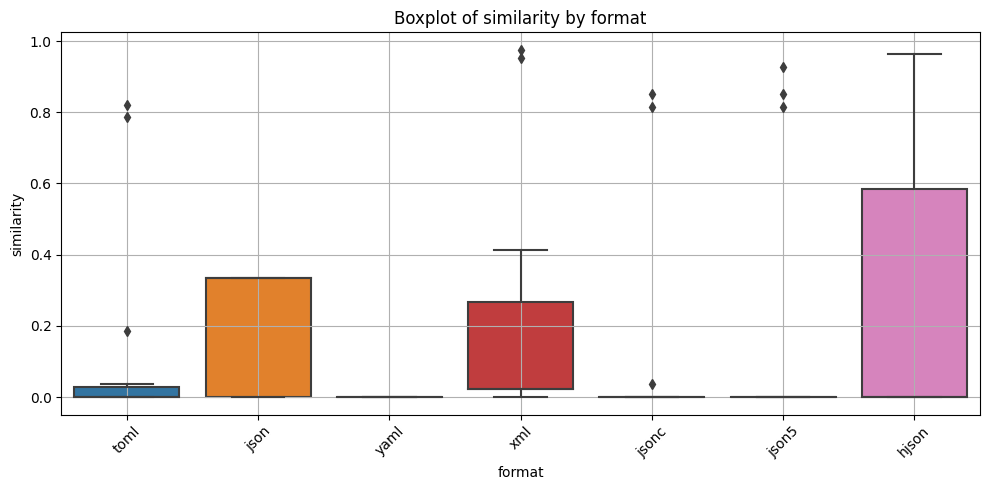

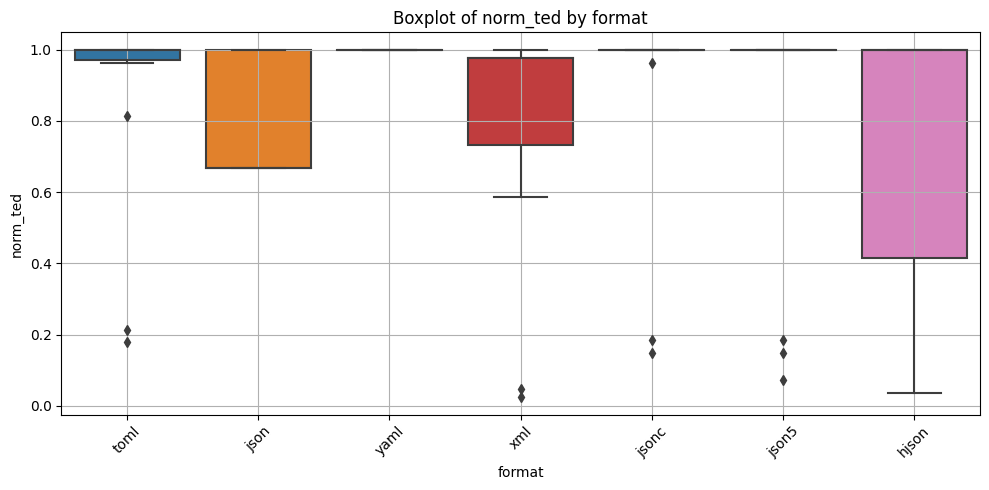

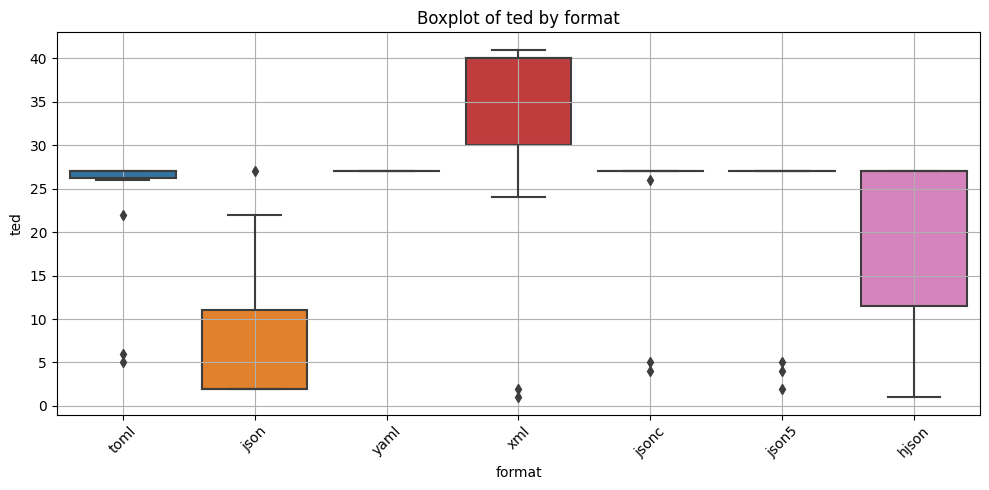

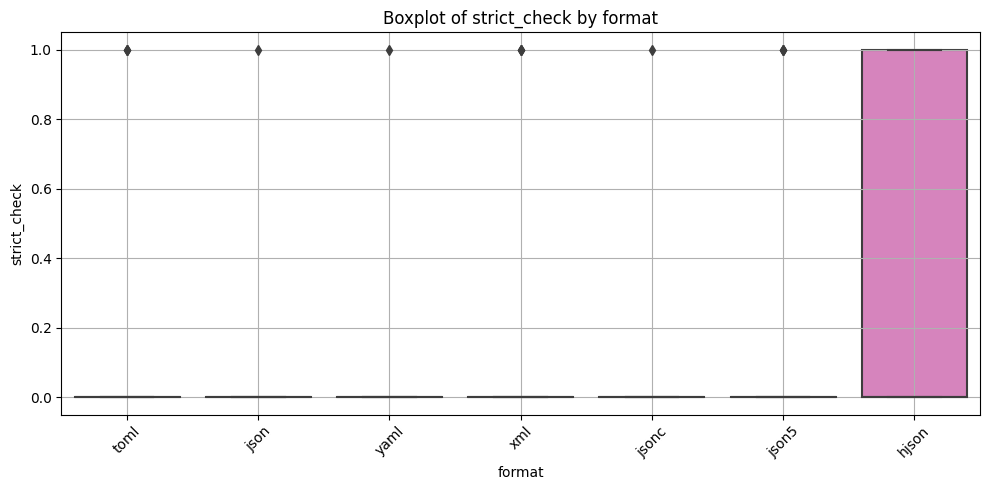

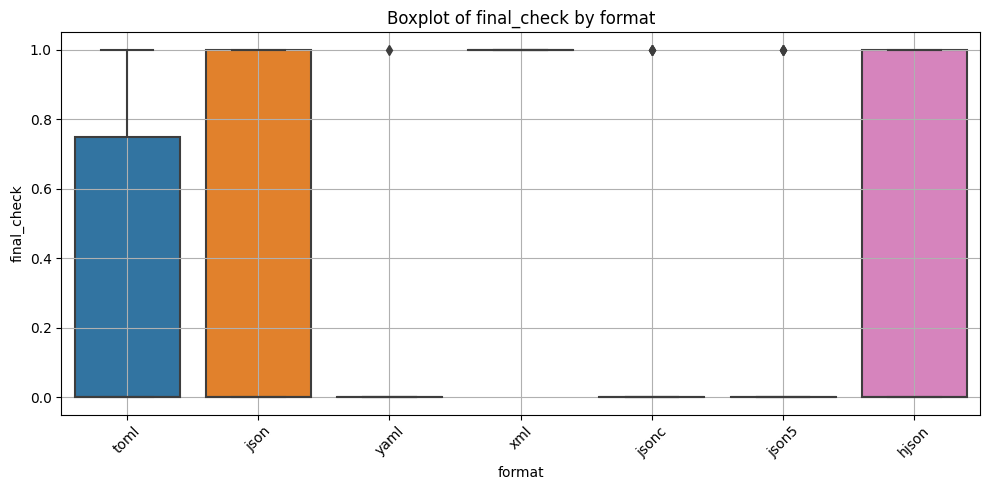

,metric,homogeneity_p,test,test_p,significant,posthoc
0,similarity,0.169929,ANOVA,1.282772e-01,False,[]
1,norm_ted,0.169929,ANOVA,1.282772e-01,False,[]
2,ted,0.167464,ANOVA,1.504657e-10,True,"[[hjson, json], [hjson, xml], [json, json5], [..."
3,strict_check,0.134602,ANOVA,1.346015e-01,False,[]
4,final_check,0.106948,ANOVA,1.136731e-07,True,"[[hjson, xml], [json, xml], [json5, xml], [jso..."


In [63]:
combined_df, anova_result = compare_and_plot_metrics_across_formats(
    toml_result, json_result, yaml_result, xml_result, jsonc_result, json5_result, hjson_result
)
summary_df = generate_statistical_summary(combined_df)
summary_df

In [66]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print(summary_df.to_string())

         metric  homogeneity_p   test        test_p  significant                                                                                               posthoc
0    similarity       0.169929  ANOVA  1.282772e-01        False                                                                                                    []
1      norm_ted       0.169929  ANOVA  1.282772e-01        False                                                                                                    []
2           ted       0.167464  ANOVA  1.504657e-10         True  [[hjson, json], [hjson, xml], [json, json5], [json, jsonc], [json, toml], [json, xml], [json, yaml]]
3  strict_check       0.134602  ANOVA  1.346015e-01        False                                                                                                    []
4   final_check       0.106948  ANOVA  1.136731e-07         True                     [[hjson, xml], [json, xml], [json5, xml], [jsonc, xml], [toml, xml], [xml, yaml]

## run modifying results

In [ ]:
import numpy as np
import pandas as pd

def add_overall_rows(df: pd.DataFrame) -> pd.DataFrame:
    agg = (
        df
        .groupby(['participantId', 'format'], as_index=False)
        .agg({
            'strict_check': 'mean',
            'final_check':  'mean',
            'ted':          'mean',
            'norm_ted':     'mean',
            'similarity':   'mean'
        })
    )

    agg['task_id']     = 'overall'
    agg['loose_check'] = np.nan   # 一律 NaN

    cols = df.columns.tolist()
    agg = agg[cols]

    return pd.concat([df, agg], ignore_index=True)


In [16]:
df_json_1=df_modifying_tabular_clean[df_modifying_tabular_clean['format']=='json'][df_modifying_tabular_clean['task']=='modifying-task-tabular-1']
df_json_2=df_modifying_tabular_clean[df_modifying_tabular_clean['format']=='json'][df_modifying_tabular_clean['task']=='modifying-task-tabular-2']
df_json_3=df_modifying_tabular_clean[df_modifying_tabular_clean['format']=='json'][df_modifying_tabular_clean['task']=='modifying-task-tabular-3']
df_json_4=df_modifying_tabular_clean[df_modifying_tabular_clean['format']=='json'][df_modifying_tabular_clean['task']=='modifying-task-tabular-4']
df_jsonc_1=df_modifying_tabular_clean[df_modifying_tabular_clean['format']=='jsonc'][df_modifying_tabular_clean['task']=='modifying-task-tabular-1']
df_jsonc_2=df_modifying_tabular_clean[df_modifying_tabular_clean['format']=='jsonc'][df_modifying_tabular_clean['task']=='modifying-task-tabular-2']
df_jsonc_3=df_modifying_tabular_clean[df_modifying_tabular_clean['format']=='jsonc'][df_modifying_tabular_clean['task']=='modifying-task-tabular-3']
df_jsonc_4=df_modifying_tabular_clean[df_modifying_tabular_clean['format']=='jsonc'][df_modifying_tabular_clean['task']=='modifying-task-tabular-4']
df_json5_1=df_modifying_tabular_clean[df_modifying_tabular_clean['format']=='json5'][df_modifying_tabular_clean['task']=='modifying-task-tabular-1']
df_json5_2=df_modifying_tabular_clean[df_modifying_tabular_clean['format']=='json5'][df_modifying_tabular_clean['task']=='modifying-task-tabular-2']
df_json5_3=df_modifying_tabular_clean[df_modifying_tabular_clean['format']=='json5'][df_modifying_tabular_clean['task']=='modifying-task-tabular-3']
df_json5_4=df_modifying_tabular_clean[df_modifying_tabular_clean['format']=='json5'][df_modifying_tabular_clean['task']=='modifying-task-tabular-4']
df_hjson_1=df_modifying_tabular_clean[df_modifying_tabular_clean['format']=='hjson'][df_modifying_tabular_clean['task']=='modifying-task-tabular-1']
df_hjson_2=df_modifying_tabular_clean[df_modifying_tabular_clean['format']=='hjson'][df_modifying_tabular_clean['task']=='modifying-task-tabular-2']
df_hjson_3=df_modifying_tabular_clean[df_modifying_tabular_clean['format']=='hjson'][df_modifying_tabular_clean['task']=='modifying-task-tabular-3']
df_hjson_4=df_modifying_tabular_clean[df_modifying_tabular_clean['format']=='hjson'][df_modifying_tabular_clean['task']=='modifying-task-tabular-4']
df_toml_1=df_modifying_tabular_clean[df_modifying_tabular_clean['format']=='toml'][df_modifying_tabular_clean['task']=='modifying-task-tabular-1']
df_toml_2=df_modifying_tabular_clean[df_modifying_tabular_clean['format']=='toml'][df_modifying_tabular_clean['task']=='modifying-task-tabular-2']
df_toml_3=df_modifying_tabular_clean[df_modifying_tabular_clean['format']=='toml'][df_modifying_tabular_clean['task']=='modifying-task-tabular-3']
df_toml_4=df_modifying_tabular_clean[df_modifying_tabular_clean['format']=='toml'][df_modifying_tabular_clean['task']=='modifying-task-tabular-4']
df_yaml_1=df_modifying_tabular_clean[df_modifying_tabular_clean['format']=='yaml'][df_modifying_tabular_clean['task']=='modifying-task-tabular-1']
df_yaml_2=df_modifying_tabular_clean[df_modifying_tabular_clean['format']=='yaml'][df_modifying_tabular_clean['task']=='modifying-task-tabular-2']
df_yaml_3=df_modifying_tabular_clean[df_modifying_tabular_clean['format']=='yaml'][df_modifying_tabular_clean['task']=='modifying-task-tabular-3']
df_yaml_4=df_modifying_tabular_clean[df_modifying_tabular_clean['format']=='yaml'][df_modifying_tabular_clean['task']=='modifying-task-tabular-4']
df_toml_1=df_modifying_tabular_clean[df_modifying_tabular_clean['format']=='toml'][df_modifying_tabular_clean['task']=='modifying-task-tabular-1']
df_toml_2=df_modifying_tabular_clean[df_modifying_tabular_clean['format']=='toml'][df_modifying_tabular_clean['task']=='modifying-task-tabular-2']
df_toml_3=df_modifying_tabular_clean[df_modifying_tabular_clean['format']=='toml'][df_modifying_tabular_clean['task']=='modifying-task-tabular-3']
df_toml_4=df_modifying_tabular_clean[df_modifying_tabular_clean['format']=='toml'][df_modifying_tabular_clean['task']=='modifying-task-tabular-4']
df_xml_1=df_modifying_tabular_clean[df_modifying_tabular_clean['format']=='xml'][df_modifying_tabular_clean['task']=='modifying-task-tabular-1']
df_xml_2=df_modifying_tabular_clean[df_modifying_tabular_clean['format']=='xml'][df_modifying_tabular_clean['task']=='modifying-task-tabular-2']
df_xml_3=df_modifying_tabular_clean[df_modifying_tabular_clean['format']=='xml'][df_modifying_tabular_clean['task']=='modifying-task-tabular-3']
df_xml_4=df_modifying_tabular_clean[df_modifying_tabular_clean['format']=='xml'][df_modifying_tabular_clean['task']=='modifying-task-tabular-4']

/var/folders/hs/htjkkv116fv94g1llc3jj8jc0000gn/T/ipykernel_50091/4180157677.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_json_1=df_modifying_tabular_clean[df_modifying_tabular_clean['format']=='json'][df_modifying_tabular_clean['task']=='modifying-task-tabular-1']
/var/folders/hs/htjkkv116fv94g1llc3jj8jc0000gn/T/ipykernel_50091/4180157677.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_json_2=df_modifying_tabular_clean[df_modifying_tabular_clean['format']=='json'][df_modifying_tabular_clean['task']=='modifying-task-tabular-2']
/var/folders/hs/htjkkv116fv94g1llc3jj8jc0000gn/T/ipykernel_50091/4180157677.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_json_3=df_modifying_tabular_clean[df_modifying_tabular_clean['format']=='json'][df_modifying_tabular_clean['task']=='modifying-task-tabular-3']
/var/folders/hs/htjkkv116fv94g1llc3jj8jc0000gn/T/ipykernel_50091/4180157677.py:

In [ ]:
gold_dict_json_1 = '''
{
  "movies": {
    "movie": [
      {
        "title": "After Dark in Central Park",
        "year": 1900,
        "cast": [],
        "genres": ["Silent", "Short"],
        "href": null,
        "country": "United States",
        "runtime": 3,
        "language": "Silent",
        "release_date": "1900-03-15",
        "production_company": "Edison Manufacturing Company",
        "director": "James H. White",
        "writer": "James H. White",
        "cinematography": "Unknown",
        "budget": 500,
        "box_office": null,
        "awards": []
      },
      {
        "title": "Boarding School Girls' Pajama Parade",
        "year": 1900,
        "cast": [],
        "genres": ["Silent", "Short"],
        "href": null,
        "country": "United States",
        "runtime": 2,
        "language": "Silent",
        "release_date": "1900-05-10",
        "production_company": "Edison Manufacturing Company",
        "director": "James H. White",
        "writer": "James H. White",
        "cinematography": "Unknown",
        "budget": 450,
        "box_office": null,
        "awards": []
      },
      {
        "title": "Buffalo Bill's Wild West Parade",
        "year": 1900,
        "cast": ["Buffalo Bill (William F. Cody)"],
        "genres": ["Documentary"],
        "href": null,
        "country": "United States",
        "runtime": 5,
        "language": "Silent",
        "release_date": "1900-07-04",
        "production_company": "Edison Manufacturing Company",
        "director": "Unknown",
        "writer": "Unknown",
        "cinematography": "Unknown",
        "budget": 600,
        "box_office": null,
        "awards": []
      },
      {
        "title": "Caught",
        "year": 1900,
        "cast": [],
        "genres": ["Drama"],
        "href": null,
        "country": "United States",
        "runtime": 2,
        "language": "Silent",
        "release_date": "1900-02-20",
        "production_company": "Biograph Company",
        "director": "William Heise",
        "writer": "William Heise",
        "cinematography": "Unknown",
        "budget": 400,
        "box_office": null,
        "awards": []
      },
      {
        "title": "Clowns Spinning Hats",
        "year": 1900,
        "cast": ["Unknown Clowns"],
        "genres": ["Silent", "Comedy"],
        "href": "Clowns_Spinning_Hats",
        "extract": "Clowns Spinning Hats is a black-and-white silent film featuring clowns throwing hats back and forth to each other. It was written and produced by Lubin Films and released April 7, 1900.",
        "country": "United States",
        "runtime": 3,
        "language": "Silent",
        "release_date": "1900-04-07",
        "production_company": "Lubin Films",
        "director": "Unknown",
        "writer": "Unknown",
        "cinematography": "Unknown",
        "budget": 500,
        "box_office": null,
        "awards": []
      },
      {
        "title": "The Enchanted Drawing",
        "year": 1900,
        "cast": ["J. Stuart Blackton"],
        "genres": ["Silent", "Animation"],
        "href": "The_Enchanted_Drawing",
        "extract": "The Enchanted Drawing is a 1900 silent film directed by J. Stuart Blackton. It is best known for containing the first animated sequences recorded on standard picture film, which has led Blackton to be considered the father of American animation.",
        "thumbnail_width": 320,
        "thumbnail_height": 240,
        "country": "United States",
        "runtime": 2,
        "language": "Silent",
        "release_date": "1900-11-16",
        "production_company": "Vitagraph Studios",
        "director": "J. Stuart Blackton",
        "writer": "J. Stuart Blackton",
        "cinematography": "Unknown",
        "budget": 700,
        "box_office": null,
        "awards": []
      },
      {
        "title": "Feeding Sea Lions",
        "year": 1900,
        "cast": ["Paul Boyton"],
        "genres": ["Short", "Silent"],
        "href": "Feeding_Sea_Lions",
        "extract": "Feeding Sea Lions is a short silent film featuring Paul Boyton feeding sea lions at his Sea Lion Park at Coney Island. Boyton is shown feeding the trained sea lions, twelve in number. The sea lions follow Boyton up the steps of the pool and then follow him back into the water. One of them steals food out of the basket. The film was made by Lubin Studios on March 10, 1900.",
        "country": "United States",
        "runtime": 3,
        "language": "Silent",
        "release_date": "1900-03-10",
        "production_company": "Lubin Studios",
        "director": "Unknown",
        "writer": "Unknown",
        "cinematography": "Unknown",
        "budget": 450,
        "box_office": null,
        "awards": []
      },
      {
        "title": "A Trip to the Moon",
        "year": 1902,
        "cast": ["Georges Méliès"],
        "genres": ["Sci-Fi", "Adventure"],
        "href": "A_Trip_to_the_Moon",
        "extract": "A Trip to the Moon (French: Le Voyage dans la Lune) is a 1902 French silent film directed by Georges Méliès. It is widely regarded as the first science fiction film ever made.",
        "thumbnail_width": 320,
        "thumbnail_height": 240,
        "country": "France",
        "runtime": 14,
        "language": "Silent",
        "release_date": "1902-09-01",
        "production_company": "Star Film Company",
        "director": "Georges Méliès",
        "writer": "Georges Méliès",
        "cinematography": "Georges Méliès",
        "budget": 10000,
        "box_office": 20000,
        "awards": ["Considered a milestone in cinema history"]
      },
      {
        "title": "The Great Train Robbery",
        "year": 1903,
        "cast": ["Gilbert M. Anderson", "A. C. Abadie"],
        "genres": ["Western", "Action"],
        "href": "The_Great_Train_Robbery",
        "extract": "The Great Train Robbery is a 1903 American silent short film directed by Edwin S. Porter. It is considered one of the earliest narrative films.",
        "thumbnail_width": 320,
        "thumbnail_height": 240,
        "country": "United States",
        "runtime": 12,
        "language": "Silent",
        "release_date": "1903-12-01",
        "production_company": "Edison Manufacturing Company",
        "director": "Edwin S. Porter",
        "writer": "Edwin S. Porter",
        "cinematography": "Edwin S. Porter",
        "budget": 150,
        "box_office": 5000,
        "awards": ["One of the earliest crime films"]
      }
    ]
  }
}
'''
gold_dict_json_2 = '''
{
  "movies": {
    "movie": [
      {
        "title": "After Dark in Central Park",
        "year": 1900,
        "cast": [],
        "genres": ["Silent", "Short"],
        "href": null,
        "country": "United States",
        "runtime": 3,
        "language": "Silent",
        "release_date": "1900-03-15",
        "production_company": "Edison Manufacturing Company",
        "director": "James H. White",
        "writer": "Unknown",
        "cinematography": "Unknown",
        "budget": 500,
        "box_office": null,
        "awards": []
      },
      {
        "title": "Boarding School Girls' Pajama Parade",
        "year": 1900,
        "cast": [],
        "genres": ["Silent", "Short"],
        "href": null,
        "country": "United States",
        "runtime": 2,
        "language": "Silent",
        "release_date": "1900-05-10",
        "production_company": "Edison Manufacturing Company",
        "director": "James H. White",
        "writer": "Unknown",
        "cinematography": "Unknown",
        "budget": 450,
        "box_office": null,
        "awards": []
      },
      {
        "title": "Buffalo Bill's Wild West Parade",
        "year": 1900,
        "cast": ["Buffalo Bill (William F. Cody)"],
        "genres": ["Documentary", "Silent"],
        "href": null,
        "country": "United States",
        "runtime": 5,
        "language": "Silent",
        "release_date": "1900-07-04",
        "production_company": "Edison Manufacturing Company",
        "director": "Unknown",
        "writer": "Unknown",
        "cinematography": "Unknown",
        "budget": 600,
        "box_office": null,
        "awards": []
      },
      {
        "title": "Caught",
        "year": 1900,
        "cast": [],
        "genres": ["Drama", "Silent"],
        "href": null,
        "country": "United States",
        "runtime": 2,
        "language": "Silent",
        "release_date": "1900-02-20",
        "production_company": "Biograph Company",
        "director": "William Heise",
        "writer": "Unknown",
        "cinematography": "Unknown",
        "budget": 400,
        "box_office": null,
        "awards": []
      },
      {
        "title": "Clowns Spinning Hats",
        "year": 1900,
        "cast": ["Unknown Clowns"],
        "genres": ["Silent", "Comedy"],
        "href": "Clowns_Spinning_Hats",
        "extract": "Clowns Spinning Hats is a black-and-white silent film featuring clowns throwing hats back and forth to each other. It was written and produced by Lubin Films and released April 7, 1900.",
        "country": "United States",
        "runtime": 3,
        "language": "Silent",
        "release_date": "1900-04-07",
        "production_company": "Lubin Films",
        "director": "Unknown",
        "writer": "Unknown",
        "cinematography": "Unknown",
        "budget": 500,
        "box_office": null,
        "awards": []
      },
      {
        "title": "The Enchanted Drawing",
        "year": 1900,
        "cast": ["J. Stuart Blackton"],
        "genres": ["Silent", "Animation"],
        "href": "The_Enchanted_Drawing",
        "extract": "The Enchanted Drawing is a 1900 silent film directed by J. Stuart Blackton. It is best known for containing the first animated sequences recorded on standard picture film, which has led Blackton to be considered the father of American animation.",
        "thumbnail_width": 320,
        "thumbnail_height": 240,
        "country": "United States",
        "runtime": 2,
        "language": "Silent",
        "release_date": "1900-11-16",
        "production_company": "Vitagraph Studios",
        "director": "J. Stuart Blackton",
        "writer": "J. Stuart Blackton",
        "cinematography": "Unknown",
        "budget": 700,
        "box_office": null,
        "awards": []
      },
      {
        "title": "Feeding Sea Lions",
        "year": 1900,
        "cast": ["Paul Boyton"],
        "genres": ["Short", "Silent"],
        "href": "Feeding_Sea_Lions",
        "extract": "Feeding Sea Lions is a short silent film featuring Paul Boyton feeding sea lions at his Sea Lion Park at Coney Island. Boyton is shown feeding the trained sea lions, twelve in number. The sea lions follow Boyton up the steps of the pool and then follow him back into the water. One of them steals food out of the basket. The film was made by Lubin Studios on March 10, 1900.",
        "country": "United States",
        "runtime": 3,
        "language": "Silent",
        "release_date": "1900-03-10",
        "production_company": "Lubin Studios",
        "director": "Unknown",
        "writer": "Unknown",
        "cinematography": "Unknown",
        "budget": 450,
        "box_office": null,
        "awards": []
      },
      {
        "title": "A Trip to the Moon",
        "year": 1902,
        "cast": ["Georges Méliès"],
        "genres": ["Sci-Fi", "Adventure", "Silent"],
        "href": "A_Trip_to_the_Moon",
        "extract": "A Trip to the Moon (French: Le Voyage dans la Lune) is a 1902 French silent film directed by Georges Méliès. It is widely regarded as the first science fiction film ever made.",
        "thumbnail_width": 320,
        "thumbnail_height": 240,
        "country": "France",
        "runtime": 14,
        "language": "Silent",
        "release_date": "1902-09-01",
        "production_company": "Star Film Company",
        "director": "Georges Méliès",
        "writer": "Georges Méliès",
        "cinematography": "Georges Méliès",
        "budget": 10000,
        "box_office": 20000,
        "awards": ["Considered a milestone in cinema history"]
      },
      {
        "title": "The Great Train Robbery",
        "year": 1903,
        "cast": ["Gilbert M. Anderson", "A. C. Abadie"],
        "genres": ["Western", "Action", "Silent"],
        "href": "The_Great_Train_Robbery",
        "extract": "The Great Train Robbery is a 1903 American silent short film directed by Edwin S. Porter. It is considered one of the earliest narrative films.",
        "thumbnail_width": 320,
        "thumbnail_height": 240,
        "country": "United States",
        "runtime": 12,
        "language": "Silent",
        "release_date": "1903-12-01",
        "production_company": "Edison Manufacturing Company",
        "director": "Edwin S. Porter",
        "writer": "Scott Marble",
        "cinematography": "Edwin S. Porter",
        "budget": 150,
        "box_office": 5000,
        "awards": ["One of the earliest crime films"]
      }
    ]
  }
}
'''
gold_dict_json_3 = '''
{
  "movies": {
    "movie": [
      {
        "title": "After Dark in Central Park",
        "year": 1900,
        "cast": [],
        "genres": ["Silent", "Short"],
        "href": null,
        "country": "United States",
        "runtime": 3,
        "language": "Silent",
        "release_date": "1900-03-15",
        "production_company": "Edison Manufacturing Company",
        "director": "James H. White",
        "writer": "Unknown",
        "cinematography": "Unknown",
        "budget": 500,
        "box_office": null,
        "awards": []
      },
      {
        "title": "Boarding School Girls' Pajama Parade",
        "year": 1900,
        "cast": [],
        "genres": ["Silent", "Short"],
        "href": null,
        "country": "United States",
        "runtime": 2,
        "language": "Silent",
        "release_date": "1900-05-10",
        "production_company": "Edison Manufacturing Company",
        "director": "James H. White",
        "writer": "Unknown",
        "cinematography": "Unknown",
        "budget": 450,
        "box_office": null,
        "awards": []
      },
      {
        "title": "Buffalo Bill's Wild West Parade",
        "year": 1900,
        "cast": ["Buffalo Bill (William F. Cody)"],
        "genres": ["Documentary"],
        "href": null,
        "country": "United States",
        "runtime": 5,
        "language": "Silent",
        "release_date": "1900-07-04",
        "production_company": "Edison Manufacturing Company",
        "director": "Unknown",
        "writer": "Unknown",
        "cinematography": "Unknown",
        "budget": 600,
        "box_office": null,
        "awards": []
      },
      {
        "title": "Caught",
        "year": 1900,
        "cast": [],
        "genres": ["Drama"],
        "href": null,
        "country": "United States",
        "runtime": 2,
        "language": "Silent",
        "release_date": "1900-02-20",
        "production_company": "Biograph Company",
        "director": "William Heise",
        "writer": "Unknown",
        "cinematography": "Unknown",
        "budget": 400,
        "box_office": null,
        "awards": []
      },
      {
        "title": "Clowns Spinning Hats",
        "year": 1900,
        "cast": ["Unknown Clowns"],
        "genres": ["Silent", "Comedy"],
        "href": "Clowns_Spinning_Hats",
        "extract": "Clowns Spinning Hats is a black-and-white silent film featuring clowns throwing hats back and forth to each other. It was written and produced by Lubin Films and released April 7, 1900.",
        "country": "United States",
        "runtime": 3,
        "language": "Silent",
        "release_date": "1900-04-07",
        "production_company": "Lubin Films",
        "director": "Unknown",
        "writer": "Unknown",
        "cinematography": "Unknown",
        "budget": 500,
        "box_office": null,
        "awards": []
      },
      {
        "title": "The Enchanted Drawing",
        "year": 1900,
        "cast": ["J. Stuart Blackton"],
        "genres": ["Silent", "Animation"],
        "href": "The_Enchanted_Drawing",
        "extract": "The Enchanted Drawing is a 1900 silent film directed by J. Stuart Blackton. It is best known for containing the first animated sequences recorded on standard picture film, which has led Blackton to be considered the father of American animation.",
        "thumbnail_width": 320,
        "thumbnail_height": 240,
        "country": "United States",
        "runtime": 2,
        "language": "Silent",
        "release_date": "1900-11-16",
        "production_company": "Vitagraph Studios",
        "director": "J. Stuart Blackton",
        "writer": "J. Stuart Blackton",
        "cinematography": "Unknown",
        "budget": 700,
        "box_office": null,
        "awards": []
      },
      {
        "title": "Feeding Sea Lions",
        "year": 1900,
        "cast": ["Paul Boyton"],
        "genres": ["Short", "Silent"],
        "href": "Feeding_Sea_Lions",
        "extract": "Feeding Sea Lions is a short silent film featuring Paul Boyton feeding sea lions at his Sea Lion Park at Coney Island. Boyton is shown feeding the trained sea lions, twelve in number. The sea lions follow Boyton up the steps of the pool and then follow him back into the water. One of them steals food out of the basket. The film was made by Lubin Studios on March 10, 1900.",
        "country": "United States",
        "runtime": 3,
        "language": "Silent",
        "release_date": "1900-03-10",
        "production_company": "Lubin Studios",
        "director": "Unknown",
        "writer": "Unknown",
        "cinematography": "Unknown",
        "budget": 450,
        "box_office": null,
        "awards": []
      }
    ]
  }
}

'''
gold_dict_json_4 = '''
{
  "movies": {
    "movie": [
      {
        "title": "After Dark in Central Park",
        "information": {
          "year": 1900,
          "cast": [],
          "genres": ["Silent", "Short"],
          "href": null,
          "country": "United States",
          "runtime": 3,
          "language": "Silent",
          "release_date": "1900-03-15",
          "production_company": "Edison Manufacturing Company",
          "director": "James H. White",
          "writer": "Unknown",
          "cinematography": "Unknown",
          "budget": 500,
          "box_office": null,
          "awards": []
        }
      },
      {
        "title": "Boarding School Girls' Pajama Parade",
        "information": {
          "year": 1900,
          "cast": [],
          "genres": ["Silent", "Short"],
          "href": null,
          "country": "United States",
          "runtime": 2,
          "language": "Silent",
          "release_date": "1900-05-10",
          "production_company": "Edison Manufacturing Company",
          "director": "James H. White",
          "writer": "Unknown",
          "cinematography": "Unknown",
          "budget": 450,
          "box_office": null,
          "awards": []
        }
      },
      {
        "title": "Buffalo Bill's Wild West Parade",
        "information": {
          "year": 1900,
          "cast": ["Buffalo Bill (William F. Cody)"],
          "genres": ["Documentary"],
          "href": null,
          "country": "United States",
          "runtime": 5,
          "language": "Silent",
          "release_date": "1900-07-04",
          "production_company": "Edison Manufacturing Company",
          "director": "Unknown",
          "writer": "Unknown",
          "cinematography": "Unknown",
          "budget": 600,
          "box_office": null,
          "awards": []
        }
      },
      {
        "title": "Caught",
        "information": {
          "year": 1900,
          "cast": [],
          "genres": ["Drama"],
          "href": null,
          "country": "United States",
          "runtime": 2,
          "language": "Silent",
          "release_date": "1900-02-20",
          "production_company": "Biograph Company",
          "director": "William Heise",
          "writer": "Unknown",
          "cinematography": "Unknown",
          "budget": 400,
          "box_office": null,
          "awards": []
        }
      },
      {
        "title": "Clowns Spinning Hats",
        "information": {
          "year": 1900,
          "cast": ["Unknown Clowns"],
          "genres": ["Silent", "Comedy"],
          "href": "Clowns_Spinning_Hats",
          "extract": "Clowns Spinning Hats is a black-and-white silent film featuring clowns throwing hats back and forth to each other. It was written and produced by Lubin Films and released April 7, 1900.",
          "country": "United States",
          "runtime": 3,
          "language": "Silent",
          "release_date": "1900-04-07",
          "production_company": "Lubin Films",
          "director": "Unknown",
          "writer": "Unknown",
          "cinematography": "Unknown",
          "budget": 500,
          "box_office": null,
          "awards": []
        }
      },
      {
        "title": "The Enchanted Drawing",
        "information": {
          "year": 1900,
          "cast": ["J. Stuart Blackton"],
          "genres": ["Silent","Animation"],
          "href":"The_Enchanted_Drawing",
          "extract":"The Enchanted Drawing is a 1900 silent film directed by J. Stuart Blackton. It is best known for containing the first animated sequences recorded on standard picture film, which has led Blackton to be considered the father of American animation.",
          "thumbnail_width":320,
          "thumbnail_height":240,
          "country":"United States",
          "runtime":2,
          "language":"Silent",
          "release_date":"1900-11-16",
          "production_company":"Vitagraph Studios",
          "director":"J. Stuart Blackton",
          "writer":"J. Stuart Blackton",
          "cinematography":"Unknown",
          "budget":700,
          "box_office":null,
          "awards":[]
        }
      },
      {
        "title": "Feeding Sea Lions",
        "information": {
          "year": 1900,
          "cast": ["Paul Boyton"],
          "genres": ["Short","Silent"],
          "href": "Feeding_Sea_Lions",
          "extract": "Feeding Sea Lions is a short silent film featuring Paul Boyton feeding sea lions at his Sea Lion Park at Coney Island. Boyton is shown feeding the trained sea lions, twelve in number. The sea lions follow Boyton up the steps of the pool and then follow him back into the water. One of them steals food out of the basket. The film was made by Lubin Studios on March 10, 1900.",
          "country":"United States",
          "runtime":3,
          "language":"Silent",
          "release_date":"1900-03-10",
          "production_company":"Lubin Studios",
          "director":"Unknown",
          "writer":"Unknown",
          "cinematography":"Unknown",
          "budget":450,
          "box_office":null,
          "awards":[]
        }
      },
      {
        "title": "A Trip to the Moon",
        "information": {
          "year": 1902,
          "cast": ["Georges Méliès"],
          "genres": ["Sci-Fi","Adventure"],
          "href":"A_Trip_to_the_Moon",
          "extract":"A Trip to the Moon (French: Le Voyage dans la Lune) is a 1902 French silent film directed by Georges Méliès. It is widely regarded as the first science fiction film ever made.",
          "thumbnail_width":320,
          "thumbnail_height":240,
          "country":"France",
          "runtime":14,
          "language":"Silent",
          "release_date":"1902-09-01",
          "production_company":"Star Film Company",
          "director":"Georges Méliès",
          "writer":"Georges Méliès",
          "cinematography":"Georges Méliès",
          "budget":10000,
          "box_office":20000,
          "awards":["Considered a milestone in cinema history"]
        }
      },
      {
        "title": "The Great Train Robbery",
        "information": {
          "year": 1903,
          "cast": ["Gilbert M. Anderson","A. C. Abadie"],
          "genres": ["Western","Action"],
          "href":"The_Great_Train_Robbery",
          "extract":"The Great Train Robbery is a 1903 American silent short film directed by Edwin S. Porter. It is considered one of the earliest narrative films.",
          "thumbnail_width":320,
          "thumbnail_height":240,
          "country":"United States",
          "runtime":12,
          "language":"Silent",
          "release_date":"1903-12-01",
          "production_company":"Edison Manufacturing Company",
          "director":"Edwin S. Porter",
          "writer":"Scott Marble",
          "cinematography":"Edwin S. Porter",
          "budget":150,
          "box_office":5000,
          "awards":["One of the earliest crime films"]
        }
      }
    ]
  }
}

'''
json_m_result_1 = process_dataframe_with_validation(df_json_1, gold_dict_json_1)
json_m_result_2 = process_dataframe_with_validation(df_json_2, gold_dict_json_2)
json_m_result_3 = process_dataframe_with_validation(df_json_3, gold_dict_json_3)
json_m_result_4 = process_dataframe_with_validation(df_json_4, gold_dict_json_4)
# json_m_result_1.sort_values(by='similarity', ascending=False)

In [ ]:
gold_dict_jsonc_1 = '''
{
  "movies": {
    "movie": [
      {
        "title": "After Dark in Central Park",
        "year": 1900,
        "cast": [],
        "genres": ["Silent", "Short"],
        "href": null,
        "country": "United States",
        "runtime": 3,
        "language": "Silent",
        "release_date": "1900-03-15",
        "production_company": "Edison Manufacturing Company",
        "director": "James H. White",
        "writer": "James H. White",
        "cinematography": "Unknown",
        "budget": 500,
        "box_office": null,
        "awards": []
      },
      {
        "title": "Boarding School Girls' Pajama Parade",
        "year": 1900,
        "cast": [],
        "genres": ["Silent", "Short"],
        "href": null,
        "country": "United States",
        "runtime": 2,
        "language": "Silent",
        "release_date": "1900-05-10",
        "production_company": "Edison Manufacturing Company",
        "director": "James H. White",
        "writer": "James H. White",
        "cinematography": "Unknown",
        "budget": 450,
        "box_office": null,
        "awards": []
      },
      {
        "title": "Buffalo Bill's Wild West Parade",
        "year": 1900,
        "cast": ["Buffalo Bill (William F. Cody)"],
        "genres": ["Documentary"],
        "href": null,
        "country": "United States",
        "runtime": 5,
        "language": "Silent",
        "release_date": "1900-07-04",
        "production_company": "Edison Manufacturing Company",
        "director": "Unknown",
        "writer": "Unknown",
        "cinematography": "Unknown",
        "budget": 600,
        "box_office": null,
        "awards": []
      },
      {
        "title": "Caught",
        "year": 1900,
        "cast": [],
        "genres": ["Drama"],
        "href": null,
        "country": "United States",
        "runtime": 2,
        "language": "Silent",
        "release_date": "1900-02-20",
        "production_company": "Biograph Company",
        "director": "William Heise",
        "writer": "William Heise",
        "cinematography": "Unknown",
        "budget": 400,
        "box_office": null,
        "awards": []
      },
      {
        "title": "Clowns Spinning Hats",
        "year": 1900,
        "cast": ["Unknown Clowns"],
        "genres": ["Silent", "Comedy"],
        "href": "Clowns_Spinning_Hats",
        "extract": "Clowns Spinning Hats is a black-and-white silent film featuring clowns throwing hats back and forth to each other. It was written and produced by Lubin Films and released April 7, 1900.",
        "country": "United States",
        "runtime": 3,
        "language": "Silent",
        "release_date": "1900-04-07",
        "production_company": "Lubin Films",
        "director": "Unknown",
        "writer": "Unknown",
        "cinematography": "Unknown",
        "budget": 500,
        "box_office": null,
        "awards": []
      },
      {
        "title": "The Enchanted Drawing",
        "year": 1900,
        "cast": ["J. Stuart Blackton"],
        "genres": ["Silent", "Animation"],
        "href": "The_Enchanted_Drawing",
        "extract": "The Enchanted Drawing is a 1900 silent film directed by J. Stuart Blackton. It is best known for containing the first animated sequences recorded on standard picture film, which has led Blackton to be considered the father of American animation.",
        "thumbnail_width": 320,
        "thumbnail_height": 240,
        "country": "United States",
        "runtime": 2,
        "language": "Silent",
        "release_date": "1900-11-16",
        "production_company": "Vitagraph Studios",
        "director": "J. Stuart Blackton",
        "writer": "J. Stuart Blackton",
        "cinematography": "Unknown",
        "budget": 700,
        "box_office": null,
        "awards": []
      },
      {
        "title": "Feeding Sea Lions",
        "year": 1900,
        "cast": ["Paul Boyton"],
        "genres": ["Short", "Silent"],
        "href": "Feeding_Sea_Lions",
        "extract": "Feeding Sea Lions is a short silent film featuring Paul Boyton feeding sea lions at his Sea Lion Park at Coney Island. Boyton is shown feeding the trained sea lions, twelve in number. The sea lions follow Boyton up the steps of the pool and then follow him back into the water. One of them steals food out of the basket. The film was made by Lubin Studios on March 10, 1900.",
        "country": "United States",
        "runtime": 3,
        "language": "Silent",
        "release_date": "1900-03-10",
        "production_company": "Lubin Studios",
        "director": "Unknown",
        "writer": "Unknown",
        "cinematography": "Unknown",
        "budget": 450,
        "box_office": null,
        "awards": []
      },
      {
        "title": "A Trip to the Moon",
        "year": 1902,
        "cast": ["Georges Méliès"],
        "genres": ["Sci-Fi", "Adventure"],
        "href": "A_Trip_to_the_Moon",
        "extract": "A Trip to the Moon (French: Le Voyage dans la Lune) is a 1902 French silent film directed by Georges Méliès. It is widely regarded as the first science fiction film ever made.",
        "thumbnail_width": 320,
        "thumbnail_height": 240,
        "country": "France",
        "runtime": 14,
        "language": "Silent",
        "release_date": "1902-09-01",
        "production_company": "Star Film Company",
        "director": "Georges Méliès",
        "writer": "Georges Méliès",
        "cinematography": "Georges Méliès",
        "budget": 10000,
        "box_office": 20000,
        "awards": ["Considered a milestone in cinema history"]
      },
      {
        "title": "The Great Train Robbery",
        "year": 1903,
        "cast": ["Gilbert M. Anderson", "A. C. Abadie"],
        "genres": ["Western", "Action"],
        "href": "The_Great_Train_Robbery",
        "extract": "The Great Train Robbery is a 1903 American silent short film directed by Edwin S. Porter. It is considered one of the earliest narrative films.",
        "thumbnail_width": 320,
        "thumbnail_height": 240,
        "country": "United States",
        "runtime": 12,
        "language": "Silent",
        "release_date": "1903-12-01",
        "production_company": "Edison Manufacturing Company",
        "director": "Edwin S. Porter",
        "writer": "Edwin S. Porter",
        "cinematography": "Edwin S. Porter",
        "budget": 150,
        "box_office": 5000,
        "awards": ["One of the earliest crime films"]
      }
    ]
  }
}
'''
gold_dict_jsonc_2 = '''
{
  "movies": {
    "movie": [
      {
        "title": "After Dark in Central Park",
        "year": 1900,
        "cast": [],
        "genres": ["Silent", "Short"],
        "href": null,
        "country": "United States",
        "runtime": 3,
        "language": "Silent",
        "release_date": "1900-03-15",
        "production_company": "Edison Manufacturing Company",
        "director": "James H. White",
        "writer": "Unknown",
        "cinematography": "Unknown",
        "budget": 500,
        "box_office": null,
        "awards": []
      },
      {
        "title": "Boarding School Girls' Pajama Parade",
        "year": 1900,
        "cast": [],
        "genres": ["Silent", "Short"],
        "href": null,
        "country": "United States",
        "runtime": 2,
        "language": "Silent",
        "release_date": "1900-05-10",
        "production_company": "Edison Manufacturing Company",
        "director": "James H. White",
        "writer": "Unknown",
        "cinematography": "Unknown",
        "budget": 450,
        "box_office": null,
        "awards": []
      },
      {
        "title": "Buffalo Bill's Wild West Parade",
        "year": 1900,
        "cast": ["Buffalo Bill (William F. Cody)"],
        "genres": ["Documentary", "Silent"],
        "href": null,
        "country": "United States",
        "runtime": 5,
        "language": "Silent",
        "release_date": "1900-07-04",
        "production_company": "Edison Manufacturing Company",
        "director": "Unknown",
        "writer": "Unknown",
        "cinematography": "Unknown",
        "budget": 600,
        "box_office": null,
        "awards": []
      },
      {
        "title": "Caught",
        "year": 1900,
        "cast": [],
        "genres": ["Drama", "Silent"],
        "href": null,
        "country": "United States",
        "runtime": 2,
        "language": "Silent",
        "release_date": "1900-02-20",
        "production_company": "Biograph Company",
        "director": "William Heise",
        "writer": "Unknown",
        "cinematography": "Unknown",
        "budget": 400,
        "box_office": null,
        "awards": []
      },
      {
        "title": "Clowns Spinning Hats",
        "year": 1900,
        "cast": ["Unknown Clowns"],
        "genres": ["Silent", "Comedy"],
        "href": "Clowns_Spinning_Hats",
        "extract": "Clowns Spinning Hats is a black-and-white silent film featuring clowns throwing hats back and forth to each other. It was written and produced by Lubin Films and released April 7, 1900.",
        "country": "United States",
        "runtime": 3,
        "language": "Silent",
        "release_date": "1900-04-07",
        "production_company": "Lubin Films",
        "director": "Unknown",
        "writer": "Unknown",
        "cinematography": "Unknown",
        "budget": 500,
        "box_office": null,
        "awards": []
      },

'''
gold_dict_jsonc_3 = '''
{
  "movies": {
    "movie": [
      {
        "title": "After Dark in Central Park",
        "year": 1900,
        "cast": [],
        "genres": ["Silent", "Short"],
        "href": null,
        "country": "United States",
        "runtime": 3,
        "language": "Silent",
        "release_date": "1900-03-15",
        "production_company": "Edison Manufacturing Company",
        "director": "James H. White",
        "writer": "Unknown",
        "cinematography": "Unknown",
        "budget": 500,
        "box_office": null,
        "awards": []
      },
      {
        "title": "Boarding School Girls' Pajama Parade",
        "year": 1900,
        "cast": [],
        "genres": ["Silent", "Short"],
        "href": null,
        "country": "United States",
        "runtime": 2,
        "language": "Silent",
        "release_date": "1900-05-10",
        "production_company": "Edison Manufacturing Company",
        "director": "James H. White",
        "writer": "Unknown",
        "cinematography": "Unknown",
        "budget": 450,
        "box_office": null,
        "awards": []
      },
      {
        "title": "Buffalo Bill's Wild West Parade",
        "year": 1900,
        "cast": ["Buffalo Bill (William F. Cody)"],
        "genres": ["Documentary"],
        "href": null,
        "country": "United States",
        "runtime": 5,
        "language": "Silent",
        "release_date": "1900-07-04",
        "production_company": "Edison Manufacturing Company",
        "director": "Unknown",
        "writer": "Unknown",
        "cinematography": "Unknown",
        "budget": 600,
        "box_office": null,
        "awards": []
      },
      {
        "title": "Caught",
        "year": 1900,
        "cast": [],
        "genres": ["Drama"],
        "href": null,
        "country": "United States",
        "runtime": 2,
        "language": "Silent",
        "release_date": "1900-02-20",
        "production_company": "Biograph Company",
        "director": "William Heise",
        "writer": "Unknown",
        "cinematography": "Unknown",
        "budget": 400,
        "box_office": null,
        "awards": []
      },
      {
        "title": "Clowns Spinning Hats",
        "year": 1900,
        "cast": ["Unknown Clowns"],
        "genres": ["Silent", "Comedy"],
        "href": "Clowns_Spinning_Hats",
        "extract": "Clowns Spinning Hats is a black-and-white silent film featuring clowns throwing hats back and forth to each other. It was written and produced by Lubin Films and released April 7, 1900.",
        "country": "United States",
        "runtime": 3,
        "language": "Silent",
        "release_date": "1900-04-07",
        "production_company": "Lubin Films",
        "director": "Unknown",
        "writer": "Unknown",
        "cinematography": "Unknown",
        "budget": 500,
        "box_office": null,
        "awards": []
      },
      {
        "title": "The Enchanted Drawing",
        "year": 1900,
        "cast": ["J. Stuart Blackton"],
        "genres": ["Silent", "Animation"],
        "href": "The_Enchanted_Drawing",
        "extract": "The Enchanted Drawing is a 1900 silent film directed by J. Stuart Blackton. It is best known for containing the first animated sequences recorded on standard picture film, which has led Blackton to be considered the father of American animation.",
        "thumbnail_width": 320,
        "thumbnail_height": 240,
        "country": "United States",
        "runtime": 2,
        "language": "Silent",
        "release_date": "1900-11-16",
        "production_company": "Vitagraph Studios",
        "director": "J. Stuart Blackton",
        "writer": "J. Stuart Blackton",
        "cinematography": "Unknown",
        "budget": 700,
        "box_office": null,
        "awards": []
      },
      {
        "title": "Feeding Sea Lions",
        "year": 1900,
        "cast": ["Paul Boyton"],
        "genres": ["Short", "Silent"],
        "href": "Feeding_Sea_Lions",
        "extract": "Feeding Sea Lions is a short silent film featuring Paul Boyton feeding sea lions at his Sea Lion Park at Coney Island. Boyton is shown feeding the trained sea lions, twelve in number. The sea lions follow Boyton up the steps of the pool and then follow him back into the water. One of them steals food out of the basket. The film was made by Lubin Studios on March 10, 1900.",
        "country": "United States",
        "runtime": 3,
        "language": "Silent",
        "release_date": "1900-03-10",
        "production_company": "Lubin Studios",
        "director": "Unknown",
        "writer": "Unknown",
        "cinematography": "Unknown",
        "budget": 450,
        "box_office": null,
        "awards": []
      }
    ]
  }
}
'''
gold_dict_jsonc_4 = '''
{
  "movies": {
    "movie": [
      {
        "title": "After Dark in Central Park",
        "information": {
          "year": 1900,
          "cast": [],
          "genres": ["Silent", "Short"],
          "href": null,
          "country": "United States",
          "runtime": 3,
          "language": "Silent",
          "release_date": "1900-03-15",
          "production_company": "Edison Manufacturing Company",
          "director": "James H. White",
          "writer": "Unknown",
          "cinematography": "Unknown",
          "budget": 500,
          "box_office": null,
          "awards": []
        }
      },
      {
        "title": "Boarding School Girls' Pajama Parade",
        "information": {
          "year": 1900,
          "cast": [],
          "genres": ["Silent", "Short"],
          "href": null,
          "country": "United States",
          "runtime": 2,
          "language": "Silent",
          "release_date": "1900-05-10",
          "production_company": "Edison Manufacturing Company",
          "director": "James H. White",
          "writer": "Unknown",
          "cinematography": "Unknown",
          "budget": 450,
          "box_office": null,
          "awards": []
        }
      },
      {
        "title": "Buffalo Bill's Wild West Parade",
        "information": {
          "year": 1900,
          "cast": ["Buffalo Bill (William F. Cody)"],
          "genres": ["Documentary"],
          "href": null,
          "country": "United States",
          "runtime": 5,
          "language": "Silent",
          "release_date": "1900-07-04",
          "production_company": "Edison Manufacturing Company",
          "director": "Unknown",
          "writer": "Unknown",
          "cinematography": "Unknown",
          "budget": 600,
          "box_office": null,
          "awards": []
        }
      },
      {
        "title": "Caught",
        "information": {
          "year": 1900,
          "cast": [],
          "genres": ["Drama"],
          "href": null,
          "country": "United States",
          "runtime": 2,
          "language": "Silent",
          "release_date": "1900-02-20",
          "production_company": "Biograph Company",
          "director": "William Heise",
          "writer": "Unknown",
          "cinematography": "Unknown",
          "budget": 400,
          "box_office": null,
          "awards": []
        }
      },
      {
        "title": "Clowns Spinning Hats",
        "information": {
          "year": 1900,
          "cast": ["Unknown Clowns"],
          "genres": ["Silent", "Comedy"],
          "href": "Clowns_Spinning_Hats",
          "extract": "Clowns Spinning Hats is a black-and-white silent film featuring clowns throwing hats back and forth to each other. It was written and produced by Lubin Films and released April 7, 1900.",
          "country": "United States",
          "runtime": 3,
          "language": "Silent",
          "release_date": "1900-04-07",
          "production_company": "Lubin Films",
          "director": "Unknown",
          "writer": "Unknown",
          "cinematography": "Unknown",
          "budget": 500,
          "box_office": null,
          "awards": []
        }
      },
      {
        "title": "The Enchanted Drawing",
        "information": {
          "year": 1900,
          "cast": ["J. Stuart Blackton"],
          "genres": ["Silent", "Animation"],
          "href": "The_Enchanted_Drawing",
          "extract": "The Enchanted Drawing is a 1900 silent film directed by J. Stuart Blackton. It is best known for containing the first animated sequences recorded on standard picture film, which has led Blackton to be considered the father of American animation.",
          "thumbnail_width": 320,
          "thumbnail_height": 240,
          "country": "United States",
          "runtime": 2,
          "language": "Silent",
          "release_date": "1900-11-16",
          "production_company": "Vitagraph Studios",
          "director": "J. Stuart Blackton",
          "writer": "J. Stuart Blackton",
          "cinematography": "Unknown",
          "budget": 700,
          "box_office": null,
          "awards": []
        }
      },
      {
        "title": "Feeding Sea Lions",
        "information": {
          "year": 1900,
          "cast": ["Paul Boyton"],
          "genres": ["Short", "Silent"],
          "href": "Feeding_Sea_Lions",
          "extract": "Feeding Sea Lions is a short silent film featuring Paul Boyton feeding sea lions at his Sea Lion Park at Coney Island. Boyton is shown feeding the trained sea lions, twelve in number. The sea lions follow Boyton up the steps of the pool and then follow him back into the water. One of them steals food out of the basket. The film was made by Lubin Studios on March 10, 1900.",
          "country": "United States",
          "runtime": 3,
          "language": "Silent",
          "release_date": "1900-03-10",
          "production_company": "Lubin Studios",
          "director": "Unknown",
          "writer": "Unknown",
          "cinematography": "Unknown",
          "budget": 450,
          "box_office": null,
          "awards": []
        }
      },
      {
        "title": "A Trip to the Moon",
        "information": {
          "year": 1902,
          "cast": ["Georges Méliès"],
          "genres": ["Sci-Fi", "Adventure"],
          "href": "A_Trip_to_the_Moon",
          "extract": "A Trip to the Moon (French: Le Voyage dans la Lune) is a 1902 French silent film directed by Georges Méliès. It is widely regarded as the first science fiction film ever made.",
          "thumbnail_width": 320,
          "thumbnail_height": 240,
          "country": "France",
          "runtime": 14,
          "language": "Silent",
          "release_date": "1902-09-01",
          "production_company": "Star Film Company",
          "director": "Georges Méliès",
          "writer": "Georges Méliès",
          "cinematography": "Georges Méliès",
          "budget": 10000,
          "box_office": 20000,
          "awards": ["Considered a milestone in cinema history"]
        }
      },
      {
        "title": "The Great Train Robbery",
        "information": {
          "year": 1903,
          "cast": ["Gilbert M. Anderson", "A. C. Abadie"],
          "genres": ["Western", "Action"],
          "href": "The_Great_Train_Robbery",
          "extract": "The Great Train Robbery is a 1903 American silent short film directed by Edwin S. Porter. It is considered one of the earliest narrative films.",
          "thumbnail_width": 320,
          "thumbnail_height": 240,
          "country": "United States",
          "runtime": 12,
          "language": "Silent",
          "release_date": "1903-12-01",
          "production_company": "Edison Manufacturing Company",
          "director": "Edwin S. Porter",
          "writer": "Edwin S. Porter",
          "cinematography": "Edwin S. Porter",
          "budget": 150,
          "box_office": 5000,
          "awards": ["One of the earliest crime films"]
        }
      }
    ]
  }
}
'''
jsonc_m_result_1 = process_dataframe_with_validation(df_jsonc_1, gold_dict_jsonc_1)
jsonc_m_result_2 = process_dataframe_with_validation(df_jsonc_2, gold_dict_jsonc_2)
jsonc_m_result_3 = process_dataframe_with_validation(df_jsonc_3, gold_dict_jsonc_3)
jsonc_m_result_4 = process_dataframe_with_validation(df_jsonc_4, gold_dict_jsonc_4)
# jsonc_m_result_1.sort_values(by='similarity', ascending=False)

In [ ]:
gold_dict_hjson_1 = '''
{
  movies:
  {
    movie:
    [
      {
        title: After Dark in Central Park
        year: 1900
        cast: []
        genres:
        [
          Silent
          Short
        ]
        href: null
        country: United States
        runtime: 3
        language: Silent
        release_date: 1900-03-15
        production_company: Edison Manufacturing Company
        director: James H. White
        writer: Unknown
        cinematography: Unknown
        budget: 500
        box_office: null
        awards: []
      }
      {
        title: Boarding School Girls' Pajama Parade
        year: 1900
        cast: []
        genres:
        [
          Silent
          Short
        ]
        href: null
        country: United States
        runtime: 2
        language: Silent
        release_date: 1900-05-10
        production_company: Edison Manufacturing Company
        director: James H. White
        writer: Unknown
        cinematography: Unknown
        budget: 450
        box_office: null
        awards: []
      }
      {
        title: Buffalo Bill's Wild West Parade
        year: 1900
        cast:
        [
          Buffalo Bill (William F. Cody)
        ]
        genres:
        [
          Documentary
        ]
        href: null
        country: United States
        runtime: 5
        language: Silent
        release_date: 1900-07-04
        production_company: Edison Manufacturing Company
        director: Unknown
        writer: Unknown
        cinematography: Unknown
        budget: 600
        box_office: null
        awards: []
      }
      {
        title: Caught
        year: 1900
        cast: []
        genres:
        [
          Drama
        ]
        href: null
        country: United States
        runtime: 2
        language: Silent
        release_date: 1900-02-20
        production_company: Biograph Company
        director: William Heise
        writer: Unknown
        cinematography: Unknown
        budget: 400
        box_office: null
        awards: []
      }
      {
        title: Clowns Spinning Hats
        year: 1900
        cast:
        [
          Unknown Clowns
        ]
        genres:
        [
          Silent
          Comedy
        ]
        href: Clowns_Spinning_Hats
        extract: Clowns Spinning Hats is a black-and-white silent film featuring clowns throwing hats back and forth to each other. It was written and produced by Lubin Films and released April 7, 1900.
        country: United States
        runtime: 3
        language: Silent
        release_date: 1900-04-07
        production_company: Lubin Films
        director: Unknown
        writer: Unknown
        cinematography: Unknown
        budget: 500
        box_office: null
        awards: []
      }
      {
        title: The Enchanted Drawing
        year: 1900
        cast:
        [
          J. Stuart Blackton
        ]
        genres:
        [
          Silent
          Animation
        ]
        href: The_Enchanted_Drawing
        extract: The Enchanted Drawing is a 1900 silent film directed by J. Stuart Blackton. It is best known for containing the first animated sequences recorded on standard picture film, which has led Blackton to be considered the father of American animation.
        thumbnail_width: 320
        thumbnail_height: 240
        country: United States
        runtime: 2
        language: Silent
        release_date: 1900-11-16
        production_company: Vitagraph Studios
        director: J. Stuart Blackton
        writer: J. Stuart Blackton
        cinematography: Unknown
        budget: 700
        box_office: null
        awards: []
      }
      {
        title: Feeding Sea Lions
        year: 1900
        cast:
        [
          Paul Boyton
        ]
        genres:
        [
          Short
          Silent
        ]
        href: Feeding_Sea_Lions
        extract: Feeding Sea Lions is a short silent film featuring Paul Boyton feeding sea lions at his Sea Lion Park at Coney Island. Boyton is shown feeding the trained sea lions, twelve in number. The sea lions follow Boyton up the steps of the pool and then follow him back into the water. One of them steals food out of the basket. The film was made by Lubin Studios on March 10, 1900.
        country: United States
        runtime: 3
        language: Silent
        release_date: 1900-03-10
        production_company: Lubin Studios
        director: Unknown
        writer: Unknown
        cinematography: Unknown
        budget: 450
        box_office: null
        awards: []
      }
      {
        title: A Trip to the Moon
        year: 1902    // This movie was released after 1900.
        cast:
        [
          Georges Méliès
        ]
        genres:
        [
          Sci-Fi
          Adventure
        ]
        href: A_Trip_to_the_Moon
        extract: A Trip to the Moon (French: Le Voyage dans la Lune) is a 1902 French silent film directed by Georges Méliès. It is widely regarded as the first science fiction film ever made.
        thumbnail_width: 320
        thumbnail_height: 240
        country: France
        runtime: 14
        language: Silent
        release_date: 1902-09-01
        production_company: Star Film Company
        director: Georges Méliès
        writer: Georges Méliès
        cinematography: Georges Méliès
        budget: 10000
        box_office: 20000
        awards:
        [
          Considered a milestone in cinema history
        ]
      }
      {
        title: The Great Train Robbery
        year: 1903  
        cast:
        [
          Gilbert M. Anderson
          A. C. Abadie
        ]
        genres:
        [
          Western
          Action
        ]
        href: The_Great_Train_Robbery
        extract: The Great Train Robbery is a 1903 American silent short film directed by Edwin S. Porter. It is considered one of the earliest narrative films.
        thumbnail_width: 320
        thumbnail_height: 240
        country: United States
        runtime: 12
        language: Silent
        release_date: 1903-12-01
        production_company: Edison Manufacturing Company
        director: Edwin S. Porter
        writer: Scott Marble
        cinematography: Edwin S. Porter
        budget: 150
        box_office: 5000
        awards:
        [
          One of the earliest crime films
        ]
      }
    ]
  }
}
'''
gold_dict_hjson_2 = '''
{
  movies:
  {
    movie:
    [
      {
        title: After Dark in Central Park
        year: 1900
        cast: []
        genres:
        [
          Silent
          Short
        ]
        href: null
        country: United States
        runtime: 3
        language: Silent
        release_date: 1900-03-15
        production_company: Edison Manufacturing Company
        director: James H. White
        writer: Unknown
        cinematography: Unknown
        budget: 500
        box_office: null
        awards: []
      }
      {
        title: Boarding School Girls' Pajama Parade
        year: 1900
        cast: []
        genres:
        [
          Silent
          Short
        ]
        href: null
        country: United States
        runtime: 2
        language: Silent
        release_date: 1900-05-10
        production_company: Edison Manufacturing Company
        director: James H. White
        writer: Unknown
        cinematography: Unknown
        budget: 450
        box_office: null
        awards: []
      }
      {
        title: Buffalo Bill's Wild West Parade
        year: 1900
        cast:
        [
          Buffalo Bill (William F. Cody)
        ]
        genres:
        [
          Documentary
        ]
        href: null
        country: United States
        runtime: 5
        language: Silent
        release_date: 1900-07-04
        production_company: Edison Manufacturing Company
        director: Unknown
        writer: Unknown
        cinematography: Unknown
        budget: 600
        box_office: null
        awards: []
      }
      {
        title: Caught
        year: 1900
        cast: []
        genres:
        [
          Drama
        ]
        href: null
        country: United States
        runtime: 2
        language: Silent
        release_date: 1900-02-20
        production_company: Biograph Company
        director: William Heise
        writer: Unknown
        cinematography: Unknown
        budget: 400
        box_office: null
        awards: []
      }
      {
        title: Clowns Spinning Hats
        year: 1900
        cast:
        [
          Unknown Clowns
        ]
        genres:
        [
          Silent
          Comedy
        ]
        href: Clowns_Spinning_Hats
        extract: Clowns Spinning Hats is a black-and-white silent film featuring clowns throwing hats back and forth to each other. It was written and produced by Lubin Films and released April 7, 1900.
        country: United States
        runtime: 3
        language: Silent
        release_date: 1900-04-07
        production_company: Lubin Films
        director: Unknown
        writer: Unknown
        cinematography: Unknown
        budget: 500
        box_office: null
        awards: []
      }
      {
        title: The Enchanted Drawing
        year: 1900
        cast:
        [
          J. Stuart Blackton
        ]
        genres:
        [
          Silent
          Animation
        ]
        href: The_Enchanted_Drawing
        extract: The Enchanted Drawing is a 1900 silent film directed by J. Stuart Blackton. It is best known for containing the first animated sequences recorded on standard picture film, which has led Blackton to be considered the father of American animation.
        thumbnail_width: 320
        thumbnail_height: 240
        country: United States
        runtime: 2
        language: Silent
        release_date: 1900-11-16
        production_company: Vitagraph Studios
        director: J. Stuart Blackton
        writer: J. Stuart Blackton
        cinematography: Unknown
        budget: 700
        box_office: null
        awards: []
      }
      {
        title: Feeding Sea Lions
        year: 1900
        cast:
        [
          Paul Boyton
        ]
        genres:
        [
          Short
          Silent
        ]
        href: Feeding_Sea_Lions
        extract: Feeding Sea Lions is a short silent film featuring Paul Boyton feeding sea lions at his Sea Lion Park at Coney Island. Boyton is shown feeding the trained sea lions, twelve in number. The sea lions follow Boyton up the steps of the pool and then follow him back into the water. One of them steals food out of the basket. The film was made by Lubin Studios on March 10, 1900.
        country: United States
        runtime: 3
        language: Silent
        release_date: 1900-03-10
        production_company: Lubin Studios
        director: Unknown
        writer: Unknown
        cinematography: Unknown
        budget: 450
        box_office: null
        awards: []
      }
      {
        title: A Trip to the Moon
        year: 1902    // This movie was released after 1900.
        cast:
        [
          Georges Méliès
        ]
        genres:
        [
          Sci-Fi
          Adventure
        ]
        href: A_Trip_to_the_Moon
        extract: A Trip to the Moon (French: Le Voyage dans la Lune) is a 1902 French silent film directed by Georges Méliès. It is widely regarded as the first science fiction film ever made.
        thumbnail_width: 320
        thumbnail_height: 240
        country: France
        runtime: 14
        language: Silent
        release_date: 1902-09-01
        production_company: Star Film Company
        director: Georges Méliès
        writer: Georges Méliès
        cinematography: Georges Méliès
        budget: 10000
        box_office: 20000
        awards:
        [
          Considered a milestone in cinema history
        ]
      }
      {
        title: The Great Train Robbery
        year: 1903  
        cast:
        [
          Gilbert M. Anderson
          A. C. Abadie
        ]
        genres:
        [
          Western
          Action
        ]
        href: The_Great_Train_Robbery
        extract: The Great Train Robbery is a 1903 American silent short film directed by Edwin S. Porter. It is considered one of the earliest narrative films.
        thumbnail_width: 320
        thumbnail_height: 240
        country: United States
        runtime: 12
        language: Silent
        release_date: 1903-12-01
        production_company: Edison Manufacturing Company
        director: Edwin S. Porter
        writer: Scott Marble
        cinematography: Edwin S. Porter
        budget: 150
        box_office: 5000
        awards:
        [
          One of the earliest crime films
        ]
      }
    ]
  }
}
'''
gold_dict_hjson_3 = '''
{
  movies:
  {
    movie:
    [
      {
        title: After Dark in Central Park
        year: 1900
        cast: []
        genres:
        [
          Silent
          Short
        ]
        href: null
        country: United States
        runtime: 3
        language: Silent
        release_date: 1900-03-15
        production_company: Edison Manufacturing Company
        director: James H. White
        writer: Unknown
        cinematography: Unknown
        budget: 500
        box_office: null
        awards: []
      }
      {
        title: Boarding School Girls' Pajama Parade
        year: 1900
        cast: []
        genres:
        [
          Silent
          Short
        ]
        href: null
        country: United States
        runtime: 2
        language: Silent
        release_date: 1900-05-10
        production_company: Edison Manufacturing Company
        director: James H. White
        writer: Unknown
        cinematography: Unknown
        budget: 450
        box_office: null
        awards: []
      }
      {
        title: Buffalo Bill's Wild West Parade
        year: 1900
        cast:
        [
          Buffalo Bill (William F. Cody)
        ]
        genres:
        [
          Documentary
        ]
        href: null
        country: United States
        runtime: 5
        language: Silent
        release_date: 1900-07-04
        production_company: Edison Manufacturing Company
        director: Unknown
        writer: Unknown
        cinematography: Unknown
        budget: 600
        box_office: null
        awards: []
      }
      {
        title: Caught
        year: 1900
        cast: []
        genres:
        [
          Drama
        ]
        href: null
        country: United States
        runtime: 2
        language: Silent
        release_date: 1900-02-20
        production_company: Biograph Company
        director: William Heise
        writer: Unknown
        cinematography: Unknown
        budget: 400
        box_office: null
        awards: []
      }
      {
        title: Clowns Spinning Hats
        year: 1900
        cast:
        [
          Unknown Clowns
        ]
        genres:
        [
          Silent
          Comedy
        ]
        href: Clowns_Spinning_Hats
        extract: Clowns Spinning Hats is a black-and-white silent film featuring clowns throwing hats back and forth to each other. It was written and produced by Lubin Films and released April 7, 1900.
        country: United States
        runtime: 3
        language: Silent
        release_date: 1900-04-07
        production_company: Lubin Films
        director: Unknown
        writer: Unknown
        cinematography: Unknown
        budget: 500
        box_office: null
        awards: []
      }
      {
        title: The Enchanted Drawing
        year: 1900
        cast:
        [
          J. Stuart Blackton
        ]
        genres:
        [
          Silent
          Animation
        ]
        href: The_Enchanted_Drawing
        extract: The Enchanted Drawing is a 1900 silent film directed by J. Stuart Blackton. It is best known for containing the first animated sequences recorded on standard picture film, which has led Blackton to be considered the father of American animation.
        thumbnail_width: 320
        thumbnail_height: 240
        country: United States
        runtime: 2
        language: Silent
        release_date: 1900-11-16
        production_company: Vitagraph Studios
        director: J. Stuart Blackton
        writer: J. Stuart Blackton
        cinematography: Unknown
        budget: 700
        box_office: null
        awards: []
      }
      {
        title: Feeding Sea Lions
        year: 1900
        cast:
        [
          Paul Boyton
        ]
        genres:
        [
          Short
          Silent
        ]
        href: Feeding_Sea_Lions
        extract: Feeding Sea Lions is a short silent film featuring Paul Boyton feeding sea lions at his Sea Lion Park at Coney Island. Boyton is shown feeding the trained sea lions, twelve in number. The sea lions follow Boyton up the steps of the pool and then follow him back into the water. One of them steals food out of the basket. The film was made by Lubin Studios on March 10, 1900.
        country: United States
        runtime: 3
        language: Silent
        release_date: 1900-03-10
        production_company: Lubin Studios
        director: Unknown
        writer: Unknown
        cinematography: Unknown
        budget: 450
        box_office: null
        awards: []
      }
      {
        title: A Trip to the Moon
        year: 1902    // This movie was released after 1900.
        cast:
        [
          Georges Méliès
        ]
        genres:
        [
          Sci-Fi
          Adventure
        ]
        href: A_Trip_to_the_Moon
        extract: A Trip to the Moon (French: Le Voyage dans la Lune) is a 1902 French silent film directed by Georges Méliès. It is widely regarded as the first science fiction film ever made.
        thumbnail_width: 320
        thumbnail_height: 240
        country: France
        runtime: 14
        language: Silent
        release_date: 1902-09-01
        production_company: Star Film Company
        director: Georges Méliès
        writer: Georges Méliès
        cinematography: Georges Méliès
        budget: 10000
        box_office: 20000
        awards:
        [
          Considered a milestone in cinema history
        ]
      }
      {
        title: The Great Train Robbery
        year: 1903  
        cast:
        [
          Gilbert M. Anderson
          A. C. Abadie
        ]
        genres:
        [
          Western
          Action
        ]
        href: The_Great_Train_Robbery
        extract: The Great Train Robbery is a 1903 American silent short film directed by Edwin S. Porter. It is considered one of the earliest narrative films.
        thumbnail_width: 320
        thumbnail_height: 240
        country: United States
        runtime: 12
        language: Silent
        release_date: 1903-12-01
        production_company: Edison Manufacturing Company
        director: Edwin S. Porter
        writer: Scott Marble
        cinematography: Edwin S. Porter
        budget: 150
        box_office: 5000
        awards:
        [
          One of the earliest crime films
        ]
      }
    ]
  }
}
'''
gold_dict_hjson_4 = '''
{
  movies:
  {
    movie:
    [
      {
        title: After Dark in Central Park
        year: 1900
        cast: []
        genres:
        [
          Silent
          Short
        ]
        href: null
        country: United States
        runtime: 3
        language: Silent
        release_date: 1900-03-15
        production_company: Edison Manufacturing Company
        director: James H. White
        writer: Unknown
        cinematography: Unknown
        budget: 500
        box_office: null
        awards: []
      }
      {
        title: Boarding School Girls' Pajama Parade
        year: 1900
        cast: []
        genres:
        [
          Silent
          Short
        ]
        href: null
        country: United States
        runtime: 2
        language: Silent
        release_date: 1900-05-10
        production_company: Edison Manufacturing Company
        director: James H. White
        writer: Unknown
        cinematography: Unknown
        budget: 450
        box_office: null
        awards: []
      }
      {
        title: Buffalo Bill's Wild West Parade
        year: 1900
        cast:
        [
          Buffalo Bill (William F. Cody)
        ]
        genres:
        [
          Documentary
        ]
        href: null
        country: United States
        runtime: 5
        language: Silent
        release_date: 1900-07-04
        production_company: Edison Manufacturing Company
        director: Unknown
        writer: Unknown
        cinematography: Unknown
        budget: 600
        box_office: null
        awards: []
      }
      {
        title: Caught
        year: 1900
        cast: []
        genres:
        [
          Drama
        ]
        href: null
        country: United States
        runtime: 2
        language: Silent
        release_date: 1900-02-20
        production_company: Biograph Company
        director: William Heise
        writer: Unknown
        cinematography: Unknown
        budget: 400
        box_office: null
        awards: []
      }
      {
        title: Clowns Spinning Hats
        year: 1900
        cast:
        [
          Unknown Clowns
        ]
        genres:
        [
          Silent
          Comedy
        ]
        href: Clowns_Spinning_Hats
        extract: Clowns Spinning Hats is a black-and-white silent film featuring clowns throwing hats back and forth to each other. It was written and produced by Lubin Films and released April 7, 1900.
        country: United States
        runtime: 3
        language: Silent
        release_date: 1900-04-07
        production_company: Lubin Films
        director: Unknown
        writer: Unknown
        cinematography: Unknown
        budget: 500
        box_office: null
        awards: []
      }
      {
        title: The Enchanted Drawing
        year: 1900
        cast:
        [
          J. Stuart Blackton
        ]
        genres:
        [
          Silent
          Animation
        ]
        href: The_Enchanted_Drawing
        extract: The Enchanted Drawing is a 1900 silent film directed by J. Stuart Blackton. It is best known for containing the first animated sequences recorded on standard picture film, which has led Blackton to be considered the father of American animation.
        thumbnail_width: 320
        thumbnail_height: 240
        country: United States
        runtime: 2
        language: Silent
        release_date: 1900-11-16
        production_company: Vitagraph Studios
        director: J. Stuart Blackton
        writer: J. Stuart Blackton
        cinematography: Unknown
        budget: 700
        box_office: null
        awards: []
      }
      {
        title: Feeding Sea Lions
        year: 1900
        cast:
        [
          Paul Boyton
        ]
        genres:
        [
          Short
          Silent
        ]
        href: Feeding_Sea_Lions
        extract: Feeding Sea Lions is a short silent film featuring Paul Boyton feeding sea lions at his Sea Lion Park at Coney Island. Boyton is shown feeding the trained sea lions, twelve in number. The sea lions follow Boyton up the steps of the pool and then follow him back into the water. One of them steals food out of the basket. The film was made by Lubin Studios on March 10, 1900.
        country: United States
        runtime: 3
        language: Silent
        release_date: 1900-03-10
        production_company: Lubin Studios
        director: Unknown
        writer: Unknown
        cinematography: Unknown
        budget: 450
        box_office: null
        awards: []
      }
      {
        title: A Trip to the Moon
        year: 1902    // This movie was released after 1900.
        cast:
        [
          Georges Méliès
        ]
        genres:
        [
          Sci-Fi
          Adventure
        ]
        href: A_Trip_to_the_Moon
        extract: A Trip to the Moon (French: Le Voyage dans la Lune) is a 1902 French silent film directed by Georges Méliès. It is widely regarded as the first science fiction film ever made.
        thumbnail_width: 320
        thumbnail_height: 240
        country: France
        runtime: 14
        language: Silent
        release_date: 1902-09-01
        production_company: Star Film Company
        director: Georges Méliès
        writer: Georges Méliès
        cinematography: Georges Méliès
        budget: 10000
        box_office: 20000
        awards:
        [
          Considered a milestone in cinema history
        ]
      }
      {
        title: The Great Train Robbery
        year: 1903  
        cast:
        [
          Gilbert M. Anderson
          A. C. Abadie
        ]
        genres:
        [
          Western
          Action
        ]
        href: The_Great_Train_Robbery
        extract: The Great Train Robbery is a 1903 American silent short film directed by Edwin S. Porter. It is considered one of the earliest narrative films.
        thumbnail_width: 320
        thumbnail_height: 240
        country: United States
        runtime: 12
        language: Silent
        release_date: 1903-12-01
        production_company: Edison Manufacturing Company
        director: Edwin S. Porter
        writer: Scott Marble
        cinematography: Edwin S. Porter
        budget: 150
        box_office: 5000
        awards:
        [
          One of the earliest crime films
        ]
      }
    ]
  }
}
'''
hjson_m_result_1 = process_dataframe_with_validation(df_hjson_1, gold_dict_hjson_1)
hjson_m_result_2 = process_dataframe_with_validation(df_hjson_2, gold_dict_hjson_2)
hjson_m_result_3 = process_dataframe_with_validation(df_hjson_3, gold_dict_hjson_3)
hjson_m_result_4 = process_dataframe_with_validation(df_hjson_4, gold_dict_hjson_4)
# hjson_m_result_1.sort_values(by='similarity', ascending=False)

In [ ]:
gold_dict_json5_1 = '''
{
    movies: {
        movie: [
            {
                title: 'After Dark in Central Park',
                year: 1900,
                cast: [],
                genres: [
                    'Silent',
                    'Short'
                ],
                href: null,
                country: 'United States',
                runtime: 3,
                language: 'Silent',
                release_date: '1900-03-15',
                production_company: 'Edison Manufacturing Company',
                director: 'James H. White',
                writer: 'Unknown',
                cinematography: 'Unknown',
                budget: 500,
                box_office: null,
                awards: []
            },
            {
                title: "Boarding School Girls' Pajama Parade",
                year: 1900,
                cast: [],
                genres: [
                    'Silent',
                    'Short'
                ],
                href: null,
                country: 'United States',
                runtime: 2,
                language: 'Silent',
                release_date: '1900-05-10',
                production_company: 'Edison Manufacturing Company',
                director: 'James H. White',
                writer: 'Unknown',
                cinematography: 'Unknown',
                budget: 450,
                box_office: null,
                awards: []
            },
            {
                title: "Buffalo Bill's Wild West Parade",
                year: 1900,
                cast: [
                    'Buffalo Bill (William F. Cody)'
                ],
                genres: [
                    'Documentary',
                ],
                href: null,
                country: 'United States',
                runtime: 5,
                language: 'Silent',
                release_date: '1900-07-04',
                production_company: 'Edison Manufacturing Company',
                director: 'Unknown',
                writer: 'Unknown',
                cinematography: 'Unknown',
                budget: 600,
                box_office: null,
                awards: []
            },
            {
                title: 'Caught',
                year: 1900,
                cast: [],
                genres: [
                    'Drama'
                ],
                href: null,
                country: 'United States',
                runtime: 2,
                language: 'Silent',
                release_date: '1900-02-20',
                production_company: 'Biograph Company',
                director: 'William Heise',
                writer: 'Unknown',
                cinematography: 'Unknown',
                budget: 400,
                box_office: null,
                awards: []
            },
            {
                title: 'Clowns Spinning Hats',
                year: 1900,
                cast: [
                    'Unknown Clowns'
                ],
                genres: [
                    'Silent',
                    'Comedy'
                ],
                href: 'Clowns_Spinning_Hats',
                extract: 'Clowns Spinning Hats is a black-and-white silent film featuring clowns throwing hats back and forth to each other. It was written and produced by Lubin Films and released April 7, 1900.',
                country: 'United States',
                runtime: 3,
                language: 'Silent',
                release_date: '1900-04-07',
                production_company: 'Lubin Films',
                director: 'Unknown',
                writer: 'Unknown',
                cinematography: 'Unknown',
                budget: 500,
                box_office: null,
                awards: []
            },
            {
                title: 'The Enchanted Drawing',
                year: 1900,
                cast: [
                    'J. Stuart Blackton'
                ],
                genres: [
                    'Silent',
                    'Animation'
                ],
                href: 'The_Enchanted_Drawing',
                extract: 'The Enchanted Drawing is a 1900 silent film directed by J. Stuart Blackton. It is best known for containing the first animated sequences recorded on standard picture film, which has led Blackton to be considered the father of American animation.',
                thumbnail_width: 320,
                thumbnail_height: 240,
                country: 'United States',
                runtime: 2,
                language: 'Silent',
                release_date: '1900-11-16',
                production_company: 'Vitagraph Studios',
                director: 'J. Stuart Blackton',
                writer: 'J. Stuart Blackton',
                cinematography: 'Unknown',
                budget: 700,
                box_office: null,
                awards: []
            },
            {
                title: 'Feeding Sea Lions',
                year: 1900,
                cast: [
                    'Paul Boyton'
                ],
                genres: [
                    'Short',
                    'Silent'
                ],
                href: 'Feeding_Sea_Lions',
                extract: 'Feeding Sea Lions is a short silent film featuring Paul Boyton feeding sea lions at his Sea Lion Park at Coney Island. Boyton is shown feeding the trained sea lions, twelve in number. The sea lions follow Boyton up the steps of the pool and then follow him back into the water. One of them steals food out of the basket. The film was made by Lubin Studios on March 10, 1900.',
                country: 'United States',
                runtime: 3,
                language: 'Silent',
                release_date: '1900-03-10',
                production_company: 'Lubin Studios',
                director: 'Unknown',
                writer: 'Unknown',
                cinematography: 'Unknown',
                budget: 450,
                box_office: null,
                awards: []
            },
            {
                title: 'A Trip to the Moon',
                year: 1902,    // This movie was released after 1900.
                cast: [
                    'Georges Méliès'
                ],
                genres: [
                    'Sci-Fi',
                    'Adventure'
                ],
                href: 'A_Trip_to_the_Moon',
                extract: 'A Trip to the Moon (French: Le Voyage dans la Lune) is a 1902 French silent film directed by Georges Méliès. It is widely regarded as the first science fiction film ever made.',
                thumbnail_width: 320,
                thumbnail_height: 240,
                country: 'France',
                runtime: 14,
                language: 'Silent',
                release_date: '1902-09-01',
                production_company: 'Star Film Company',
                director: 'Georges Méliès',
                writer: 'Georges Méliès',
                cinematography: 'Georges Méliès',
                budget: 10000,
                box_office: 20000,
                awards: [
                    'Considered a milestone in cinema history'
                ]
            },
            {
                title: 'The Great Train Robbery',
                year: 1903,    // This movie was released after 1900.
                cast: [
                    'Gilbert M. Anderson',
                    'A. C. Abadie'
                ],
                genres: [
                    'Western',
                    'Action'
                ],
                href: 'The_Great_Train_Robbery',
                extract: 'The Great Train Robbery is a 1903 American silent short film directed by Edwin S. Porter. It is considered one of the earliest narrative films.',
                thumbnail_width: 320,
                thumbnail_height: 240,
                country: 'United States',
                runtime: 12,
                language: 'Silent',
                release_date: '1903-12-01',
                production_company: 'Edison Manufacturing Company',
                director: 'Edwin S. Porter',
                writer: 'Scott Marble',
                cinematography: 'Edwin S. Porter',
                budget: 150,
                box_office: 5000,
                awards: [
                    'One of the earliest crime films'
                ]
            }
        ]
    }
}
'''
gold_dict_json5_2 = '''
{
    movies: {
        movie: [
            {
                title: 'After Dark in Central Park',
                year: 1900,
                cast: [],
                genres: [
                    'Silent',
                    'Short'
                ],
                href: null,
                country: 'United States',
                runtime: 3,
                language: 'Silent',
                release_date: '1900-03-15',
                production_company: 'Edison Manufacturing Company',
                director: 'James H. White',
                writer: 'Unknown',
                cinematography: 'Unknown',
                budget: 500,
                box_office: null,
                awards: []
            },
            {
                title: "Boarding School Girls' Pajama Parade",
                year: 1900,
                cast: [],
                genres: [
                    'Silent',
                    'Short'
                ],
                href: null,
                country: 'United States',
                runtime: 2,
                language: 'Silent',
                release_date: '1900-05-10',
                production_company: 'Edison Manufacturing Company',
                director: 'James H. White',
                writer: 'Unknown',
                cinematography: 'Unknown',
                budget: 450,
                box_office: null,
                awards: []
            },
            {
                title: "Buffalo Bill's Wild West Parade",
                year: 1900,
                cast: [
                    'Buffalo Bill (William F. Cody)'
                ],
                genres: [
                    'Documentary',
                ],
                href: null,
                country: 'United States',
                runtime: 5,
                language: 'Silent',
                release_date: '1900-07-04',
                production_company: 'Edison Manufacturing Company',
                director: 'Unknown',
                writer: 'Unknown',
                cinematography: 'Unknown',
                budget: 600,
                box_office: null,
                awards: []
            },
            {
                title: 'Caught',
                year: 1900,
                cast: [],
                genres: [
                    'Drama'
                ],
                href: null,
                country: 'United States',
                runtime: 2,
                language: 'Silent',
                release_date: '1900-02-20',
                production_company: 'Biograph Company',
                director: 'William Heise',
                writer: 'Unknown',
                cinematography: 'Unknown',
                budget: 400,
                box_office: null,
                awards: []
            },
            {
                title: 'Clowns Spinning Hats',
                year: 1900,
                cast: [
                    'Unknown Clowns'
                ],
                genres: [
                    'Silent',
                    'Comedy'
                ],
                href: 'Clowns_Spinning_Hats',
                extract: 'Clowns Spinning Hats is a black-and-white silent film featuring clowns throwing hats back and forth to each other. It was written and produced by Lubin Films and released April 7, 1900.',
                country: 'United States',
                runtime: 3,
                language: 'Silent',
                release_date: '1900-04-07',
                production_company: 'Lubin Films',
                director: 'Unknown',
                writer: 'Unknown',
                cinematography: 'Unknown',
                budget: 500,
                box_office: null,
                awards: []
            },
            {
                title: 'The Enchanted Drawing',
                year: 1900,
                cast: [
                    'J. Stuart Blackton'
                ],
                genres: [
                    'Silent',
                    'Animation'
                ],
                href: 'The_Enchanted_Drawing',
                extract: 'The Enchanted Drawing is a 1900 silent film directed by J. Stuart Blackton. It is best known for containing the first animated sequences recorded on standard picture film, which has led Blackton to be considered the father of American animation.',
                thumbnail_width: 320,
                thumbnail_height: 240,
                country: 'United States',
                runtime: 2,
                language: 'Silent',
                release_date: '1900-11-16',
                production_company: 'Vitagraph Studios',
                director: 'J. Stuart Blackton',
                writer: 'J. Stuart Blackton',
                cinematography: 'Unknown',
                budget: 700,
                box_office: null,
                awards: []
            },
            {
                title: 'Feeding Sea Lions',
                year: 1900,
                cast: [
                    'Paul Boyton'
                ],
                genres: [
                    'Short',
                    'Silent'
                ],
                href: 'Feeding_Sea_Lions',
                extract: 'Feeding Sea Lions is a short silent film featuring Paul Boyton feeding sea lions at his Sea Lion Park at Coney Island. Boyton is shown feeding the trained sea lions, twelve in number. The sea lions follow Boyton up the steps of the pool and then follow him back into the water. One of them steals food out of the basket. The film was made by Lubin Studios on March 10, 1900.',
                country: 'United States',
                runtime: 3,
                language: 'Silent',
                release_date: '1900-03-10',
                production_company: 'Lubin Studios',
                director: 'Unknown',
                writer: 'Unknown',
                cinematography: 'Unknown',
                budget: 450,
                box_office: null,
                awards: []
            },
            {
                title: 'A Trip to the Moon',
                year: 1902,    // This movie was released after 1900.
                cast: [
                    'Georges Méliès'
                ],
                genres: [
                    'Sci-Fi',
                    'Adventure'
                ],
                href: 'A_Trip_to_the_Moon',
                extract: 'A Trip to the Moon (French: Le Voyage dans la Lune) is a 1902 French silent film directed by Georges Méliès. It is widely regarded as the first science fiction film ever made.',
                thumbnail_width: 320,
                thumbnail_height: 240,
                country: 'France',
                runtime: 14,
                language: 'Silent',
                release_date: '1902-09-01',
                production_company: 'Star Film Company',
                director: 'Georges Méliès',
                writer: 'Georges Méliès',
                cinematography: 'Georges Méliès',
                budget: 10000,
                box_office: 20000,
                awards: [
                    'Considered a milestone in cinema history'
                ]
            },
            {
                title: 'The Great Train Robbery',
                year: 1903,    // This movie was released after 1900.
                cast: [
                    'Gilbert M. Anderson',
                    'A. C. Abadie'
                ],
                genres: [
                    'Western',
                    'Action'
                ],
                href: 'The_Great_Train_Robbery',
                extract: 'The Great Train Robbery is a 1903 American silent short film directed by Edwin S. Porter. It is considered one of the earliest narrative films.',
                thumbnail_width: 320,
                thumbnail_height: 240,
                country: 'United States',
                runtime: 12,
                language: 'Silent',
                release_date: '1903-12-01',
                production_company: 'Edison Manufacturing Company',
                director: 'Edwin S. Porter',
                writer: 'Scott Marble',
                cinematography: 'Edwin S. Porter',
                budget: 150,
                box_office: 5000,
                awards: [
                    'One of the earliest crime films'
                ]
            }
        ]
    }
}
'''
gold_dict_json5_3 = '''
{
    movies: {
        movie: [
            {
                title: 'After Dark in Central Park',
                year: 1900,
                cast: [],
                genres: [
                    'Silent',
                    'Short'
                ],
                href: null,
                country: 'United States',
                runtime: 3,
                language: 'Silent',
                release_date: '1900-03-15',
                production_company: 'Edison Manufacturing Company',
                director: 'James H. White',
                writer: 'Unknown',
                cinematography: 'Unknown',
                budget: 500,
                box_office: null,
                awards: []
            },
            {
                title: "Boarding School Girls' Pajama Parade",
                year: 1900,
                cast: [],
                genres: [
                    'Silent',
                    'Short'
                ],
                href: null,
                country: 'United States',
                runtime: 2,
                language: 'Silent',
                release_date: '1900-05-10',
                production_company: 'Edison Manufacturing Company',
                director: 'James H. White',
                writer: 'Unknown',
                cinematography: 'Unknown',
                budget: 450,
                box_office: null,
                awards: []
            },
            {
                title: "Buffalo Bill's Wild West Parade",
                year: 1900,
                cast: [
                    'Buffalo Bill (William F. Cody)'
                ],
                genres: [
                    'Documentary',
                ],
                href: null,
                country: 'United States',
                runtime: 5,
                language: 'Silent',
                release_date: '1900-07-04',
                production_company: 'Edison Manufacturing Company',
                director: 'Unknown',
                writer: 'Unknown',
                cinematography: 'Unknown',
                budget: 600,
                box_office: null,
                awards: []
            },
            {
                title: 'Caught',
                year: 1900,
                cast: [],
                genres: [
                    'Drama'
                ],
                href: null,
                country: 'United States',
                runtime: 2,
                language: 'Silent',
                release_date: '1900-02-20',
                production_company: 'Biograph Company',
                director: 'William Heise',
                writer: 'Unknown',
                cinematography: 'Unknown',
                budget: 400,
                box_office: null,
                awards: []
            },
            {
                title: 'Clowns Spinning Hats',
                year: 1900,
                cast: [
                    'Unknown Clowns'
                ],
                genres: [
                    'Silent',
                    'Comedy'
                ],
                href: 'Clowns_Spinning_Hats',
                extract: 'Clowns Spinning Hats is a black-and-white silent film featuring clowns throwing hats back and forth to each other. It was written and produced by Lubin Films and released April 7, 1900.',
                country: 'United States',
                runtime: 3,
                language: 'Silent',
                release_date: '1900-04-07',
                production_company: 'Lubin Films',
                director: 'Unknown',
                writer: 'Unknown',
                cinematography: 'Unknown',
                budget: 500,
                box_office: null,
                awards: []
            },
            {
                title: 'The Enchanted Drawing',
                year: 1900,
                cast: [
                    'J. Stuart Blackton'
                ],
                genres: [
                    'Silent',
                    'Animation'
                ],
                href: 'The_Enchanted_Drawing',
                extract: 'The Enchanted Drawing is a 1900 silent film directed by J. Stuart Blackton. It is best known for containing the first animated sequences recorded on standard picture film, which has led Blackton to be considered the father of American animation.',
                thumbnail_width: 320,
                thumbnail_height: 240,
                country: 'United States',
                runtime: 2,
                language: 'Silent',
                release_date: '1900-11-16',
                production_company: 'Vitagraph Studios',
                director: 'J. Stuart Blackton',
                writer: 'J. Stuart Blackton',
                cinematography: 'Unknown',
                budget: 700,
                box_office: null,
                awards: []
            },
            {
                title: 'Feeding Sea Lions',
                year: 1900,
                cast: [
                    'Paul Boyton'
                ],
                genres: [
                    'Short',
                    'Silent'
                ],
                href: 'Feeding_Sea_Lions',
                extract: 'Feeding Sea Lions is a short silent film featuring Paul Boyton feeding sea lions at his Sea Lion Park at Coney Island. Boyton is shown feeding the trained sea lions, twelve in number. The sea lions follow Boyton up the steps of the pool and then follow him back into the water. One of them steals food out of the basket. The film was made by Lubin Studios on March 10, 1900.',
                country: 'United States',
                runtime: 3,
                language: 'Silent',
                release_date: '1900-03-10',
                production_company: 'Lubin Studios',
                director: 'Unknown',
                writer: 'Unknown',
                cinematography: 'Unknown',
                budget: 450,
                box_office: null,
                awards: []
            },
            {
                title: 'A Trip to the Moon',
                year: 1902,    // This movie was released after 1900.
                cast: [
                    'Georges Méliès'
                ],
                genres: [
                    'Sci-Fi',
                    'Adventure'
                ],
                href: 'A_Trip_to_the_Moon',
                extract: 'A Trip to the Moon (French: Le Voyage dans la Lune) is a 1902 French silent film directed by Georges Méliès. It is widely regarded as the first science fiction film ever made.',
                thumbnail_width: 320,
                thumbnail_height: 240,
                country: 'France',
                runtime: 14,
                language: 'Silent',
                release_date: '1902-09-01',
                production_company: 'Star Film Company',
                director: 'Georges Méliès',
                writer: 'Georges Méliès',
                cinematography: 'Georges Méliès',
                budget: 10000,
                box_office: 20000,
                awards: [
                    'Considered a milestone in cinema history'
                ]
            },
            {
                title: 'The Great Train Robbery',
                year: 1903,    // This movie was released after 1900.
                cast: [
                    'Gilbert M. Anderson',
                    'A. C. Abadie'
                ],
                genres: [
                    'Western',
                    'Action'
                ],
                href: 'The_Great_Train_Robbery',
                extract: 'The Great Train Robbery is a 1903 American silent short film directed by Edwin S. Porter. It is considered one of the earliest narrative films.',
                thumbnail_width: 320,
                thumbnail_height: 240,
                country: 'United States',
                runtime: 12,
                language: 'Silent',
                release_date: '1903-12-01',
                production_company: 'Edison Manufacturing Company',
                director: 'Edwin S. Porter',
                writer: 'Scott Marble',
                cinematography: 'Edwin S. Porter',
                budget: 150,
                box_office: 5000,
                awards: [
                    'One of the earliest crime films'
                ]
            }
        ]
    }
}
'''
gold_dict_json5_4 = '''
{
    movies: {
        movie: [
            {
                title: 'After Dark in Central Park',
                year: 1900,
                cast: [],
                genres: [
                    'Silent',
                    'Short'
                ],
                href: null,
                country: 'United States',
                runtime: 3,
                language: 'Silent',
                release_date: '1900-03-15',
                production_company: 'Edison Manufacturing Company',
                director: 'James H. White',
                writer: 'Unknown',
                cinematography: 'Unknown',
                budget: 500,
                box_office: null,
                awards: []
            },
            {
                title: "Boarding School Girls' Pajama Parade",
                year: 1900,
                cast: [],
                genres: [
                    'Silent',
                    'Short'
                ],
                href: null,
                country: 'United States',
                runtime: 2,
                language: 'Silent',
                release_date: '1900-05-10',
                production_company: 'Edison Manufacturing Company',
                director: 'James H. White',
                writer: 'Unknown',
                cinematography: 'Unknown',
                budget: 450,
                box_office: null,
                awards: []
            },
            {
                title: "Buffalo Bill's Wild West Parade",
                year: 1900,
                cast: [
                    'Buffalo Bill (William F. Cody)'
                ],
                genres: [
                    'Documentary',
                ],
                href: null,
                country: 'United States',
                runtime: 5,
                language: 'Silent',
                release_date: '1900-07-04',
                production_company: 'Edison Manufacturing Company',
                director: 'Unknown',
                writer: 'Unknown',
                cinematography: 'Unknown',
                budget: 600,
                box_office: null,
                awards: []
            },
            {
                title: 'Caught',
                year: 1900,
                cast: [],
                genres: [
                    'Drama'
                ],
                href: null,
                country: 'United States',
                runtime: 2,
                language: 'Silent',
                release_date: '1900-02-20',
                production_company: 'Biograph Company',
                director: 'William Heise',
                writer: 'Unknown',
                cinematography: 'Unknown',
                budget: 400,
                box_office: null,
                awards: []
            },
            {
                title: 'Clowns Spinning Hats',
                year: 1900,
                cast: [
                    'Unknown Clowns'
                ],
                genres: [
                    'Silent',
                    'Comedy'
                ],
                href: 'Clowns_Spinning_Hats',
                extract: 'Clowns Spinning Hats is a black-and-white silent film featuring clowns throwing hats back and forth to each other. It was written and produced by Lubin Films and released April 7, 1900.',
                country: 'United States',
                runtime: 3,
                language: 'Silent',
                release_date: '1900-04-07',
                production_company: 'Lubin Films',
                director: 'Unknown',
                writer: 'Unknown',
                cinematography: 'Unknown',
                budget: 500,
                box_office: null,
                awards: []
            },
            {
                title: 'The Enchanted Drawing',
                year: 1900,
                cast: [
                    'J. Stuart Blackton'
                ],
                genres: [
                    'Silent',
                    'Animation'
                ],
                href: 'The_Enchanted_Drawing',
                extract: 'The Enchanted Drawing is a 1900 silent film directed by J. Stuart Blackton. It is best known for containing the first animated sequences recorded on standard picture film, which has led Blackton to be considered the father of American animation.',
                thumbnail_width: 320,
                thumbnail_height: 240,
                country: 'United States',
                runtime: 2,
                language: 'Silent',
                release_date: '1900-11-16',
                production_company: 'Vitagraph Studios',
                director: 'J. Stuart Blackton',
                writer: 'J. Stuart Blackton',
                cinematography: 'Unknown',
                budget: 700,
                box_office: null,
                awards: []
            },
            {
                title: 'Feeding Sea Lions',
                year: 1900,
                cast: [
                    'Paul Boyton'
                ],
                genres: [
                    'Short',
                    'Silent'
                ],
                href: 'Feeding_Sea_Lions',
                extract: 'Feeding Sea Lions is a short silent film featuring Paul Boyton feeding sea lions at his Sea Lion Park at Coney Island. Boyton is shown feeding the trained sea lions, twelve in number. The sea lions follow Boyton up the steps of the pool and then follow him back into the water. One of them steals food out of the basket. The film was made by Lubin Studios on March 10, 1900.',
                country: 'United States',
                runtime: 3,
                language: 'Silent',
                release_date: '1900-03-10',
                production_company: 'Lubin Studios',
                director: 'Unknown',
                writer: 'Unknown',
                cinematography: 'Unknown',
                budget: 450,
                box_office: null,
                awards: []
            },
            {
                title: 'A Trip to the Moon',
                year: 1902,    // This movie was released after 1900.
                cast: [
                    'Georges Méliès'
                ],
                genres: [
                    'Sci-Fi',
                    'Adventure'
                ],
                href: 'A_Trip_to_the_Moon',
                extract: 'A Trip to the Moon (French: Le Voyage dans la Lune) is a 1902 French silent film directed by Georges Méliès. It is widely regarded as the first science fiction film ever made.',
                thumbnail_width: 320,
                thumbnail_height: 240,
                country: 'France',
                runtime: 14,
                language: 'Silent',
                release_date: '1902-09-01',
                production_company: 'Star Film Company',
                director: 'Georges Méliès',
                writer: 'Georges Méliès',
                cinematography: 'Georges Méliès',
                budget: 10000,
                box_office: 20000,
                awards: [
                    'Considered a milestone in cinema history'
                ]
            },
            {
                title: 'The Great Train Robbery',
                year: 1903,    // This movie was released after 1900.
                cast: [
                    'Gilbert M. Anderson',
                    'A. C. Abadie'
                ],
                genres: [
                    'Western',
                    'Action'
                ],
                href: 'The_Great_Train_Robbery',
                extract: 'The Great Train Robbery is a 1903 American silent short film directed by Edwin S. Porter. It is considered one of the earliest narrative films.',
                thumbnail_width: 320,
                thumbnail_height: 240,
                country: 'United States',
                runtime: 12,
                language: 'Silent',
                release_date: '1903-12-01',
                production_company: 'Edison Manufacturing Company',
                director: 'Edwin S. Porter',
                writer: 'Scott Marble',
                cinematography: 'Edwin S. Porter',
                budget: 150,
                box_office: 5000,
                awards: [
                    'One of the earliest crime films'
                ]
            }
        ]
    }
}
'''
json5_m_result_1 = process_dataframe_with_validation(df_json5_1, gold_dict_json5_1)
json5_m_result_2 = process_dataframe_with_validation(df_json5_2, gold_dict_json5_2)
json5_m_result_3 = process_dataframe_with_validation(df_json5_3, gold_dict_json5_3)
json5_m_result_4 = process_dataframe_with_validation(df_json5_4, gold_dict_json5_4)
# json5_m_result_1.sort_values(by='similarity', ascending=False)

In [ ]:
gold_dict_toml_1 = '''
[[movies.movie]]
title = "After Dark in Central Park"
year = 1900
cast = []
genres = ["Silent", "Short"]
href = ""
country = "United States"
runtime = 3
language = "Silent"
release_date = "1900-03-15"
production_company = "Edison Manufacturing Company"
director = "James H. White"
writer = "James H. White"
cinematography = "Unknown"
budget = 500
box_office = ""
awards = []

[[movies.movie]]
title = "Boarding School Girls' Pajama Parade"
year = 1900
cast = []
genres = ["Silent", "Short"]
href = ""
country = "United States"
runtime = 2
language = "Silent"
release_date = "1900-05-10"
production_company = "Edison Manufacturing Company"
director = "James H. White"
writer = "James H. White"
cinematography = "Unknown"
budget = 450
box_office = ""
awards = []

[[movies.movie]]
title = "Buffalo Bill's Wild West Parade"
year = 1900
cast = ["Buffalo Bill (William F. Cody)"]
genres = ["Documentary"]
href = ""
country = "United States"
runtime = 5
language = "Silent"
release_date = "1900-07-04"
production_company = "Edison Manufacturing Company"
director = "Unknown"
writer = "Unknown"
cinematography = "Unknown"
budget = 600
box_office = ""
awards = []

[[movies.movie]]
title = "Caught"
year = 1900
cast = []
genres = ["Drama"]
href = ""
country = "United States"
runtime = 2
language = "Silent"
release_date = "1900-02-20"
production_company = "Biograph Company"
director = "William Heise"
writer = "William Heise"
cinematography = "Unknown"
budget = 400
box_office = ""
awards = []

[[movies.movie]]
title = "Clowns Spinning Hats"
year = 1900
cast = ["Unknown Clowns"]
genres = ["Silent", "Comedy"]
href = "Clowns_Spinning_Hats"
extract = "Clowns Spinning Hats is a black-and-white silent film featuring clowns throwing hats back and forth to each other. It was written and produced by Lubin Films and released April 7, 1900."
country = "United States"
runtime = 3
language = "Silent"
release_date = "1900-04-07"
production_company = "Lubin Films"
director = "Unknown"
writer = "Unknown"
cinematography = "Unknown"
budget = 500
box_office = ""
awards = []

[[movies.movie]]
title = "The Enchanted Drawing"
year = 1900
cast = ["J. Stuart Blackton"]
genres = ["Silent", "Animation"]
href = "The_Enchanted_Drawing"
extract = "The Enchanted Drawing is a 1900 silent film directed by J. Stuart Blackton. It is best known for containing the first animated sequences recorded on standard picture film, which has led Blackton to be considered the father of American animation."
thumbnail_width = 320
thumbnail_height = 240
country = "United States"
runtime = 2
language = "Silent"
release_date = "1900-11-16"
production_company = "Vitagraph Studios"
director = "J. Stuart Blackton"
writer = "J. Stuart Blackton"
cinematography = "Unknown"
budget = 700
box_office = ""
awards = []

[[movies.movie]]
title = "Feeding Sea Lions"
year = 1900
cast = ["Paul Boyton"]
genres = ["Short", "Silent"]
href = "Feeding_Sea_Lions"
extract = "Feeding Sea Lions is a short silent film featuring Paul Boyton feeding sea lions at his Sea Lion Park at Coney Island. Boyton is shown feeding the trained sea lions, twelve in number. The sea lions follow Boyton up the steps of the pool and then follow him back into the water. One of them steals food out of the basket. The film was made by Lubin Studios on March 10, 1900."
country = "United States"
runtime = 3
language = "Silent"
release_date = "1900-03-10"
production_company = "Lubin Studios"
director = "Unknown"
writer = "Unknown"
cinematography = "Unknown"
budget = 450
box_office = ""
awards = []

[[movies.movie]]
title = "A Trip to the Moon"
year = 1902
cast = ["Georges Méliès"]
genres = ["Sci-Fi", "Adventure"]
href = "A_Trip_to_the_Moon"
extract = "A Trip to the Moon (French: Le Voyage dans la Lune) is a 1902 French silent film directed by Georges Méliès. It is widely regarded as the first science fiction film ever made."
thumbnail_width = 320
thumbnail_height = 240
country = "France"
runtime = 14
language = "Silent"
release_date = "1902-09-01"
production_company = "Star Film Company"
director = "Georges Méliès"
writer = "Georges Méliès"
cinematography = "Georges Méliès"
budget = 10000
box_office = 20000
awards = ["Considered a milestone in cinema history"]

[[movies.movie]]
title = "The Great Train Robbery"
year = 1903
cast = ["Gilbert M. Anderson", "A. C. Abadie"]
genres = ["Western", "Action"]
href = "The_Great_Train_Robbery"
extract = "The Great Train Robbery is a 1903 American silent short film directed by Edwin S. Porter. It is considered one of the earliest narrative films."
thumbnail_width = 320
thumbnail_height = 240
country = "United States"
runtime = 12
language = "Silent"
release_date = "1903-12-01"
production_company = "Edison Manufacturing Company"
director = "Edwin S. Porter"
writer = "Edwin S. Porter"
cinematography = "Edwin S. Porter"
budget = 150
box_office = 5000
awards = ["One of the earliest crime films"]

'''
gold_dict_toml_2 = '''
[[movies.movie]]
title = "After Dark in Central Park"
year = 1900
cast = []
genres = ["Silent", "Short"]
href = ""
country = "United States"
runtime = 3
language = "Silent"
release_date = "1900-03-15"
production_company = "Edison Manufacturing Company"
director = "James H. White"
writer = "Unknown"
cinematography = "Unknown"
budget = 500
box_office = ""
awards = []

[[movies.movie]]
title = "Boarding School Girls' Pajama Parade"
year = 1900
cast = []
genres = ["Silent", "Short"]
href = ""
country = "United States"
runtime = 2
language = "Silent"
release_date = "1900-05-10"
production_company = "Edison Manufacturing Company"
director = "James H. White"
writer = "Unknown"
cinematography = "Unknown"
budget = 450
box_office = ""
awards = []

[[movies.movie]]
title = "Buffalo Bill's Wild West Parade"
year = 1900
cast = ["Buffalo Bill (William F. Cody)"]
genres = ["Documentary", "Silent"]
href = ""
country = "United States"
runtime = 5
language = "Silent"
release_date = "1900-07-04"
production_company = "Edison Manufacturing Company"
director = "Unknown"
writer = "Unknown"
cinematography = "Unknown"
budget = 600
box_office = ""
awards = []

[[movies.movie]]
title = "Caught"
year = 1900
cast = []
genres = ["Drama", "Silent"]
href = ""
country = "United States"
runtime = 2
language = "Silent"
release_date = "1900-02-20"
production_company = "Biograph Company"
director = "William Heise"
writer = "Unknown"
cinematography = "Unknown"
budget = 400
box_office = ""
awards = []

[[movies.movie]]
title = "Clowns Spinning Hats"
year = 1900
cast = ["Unknown Clowns"]
genres = ["Silent", "Comedy"]
href = "Clowns_Spinning_Hats"
extract = "Clowns Spinning Hats is a black-and-white silent film featuring clowns throwing hats back and forth to each other. It was written and produced by Lubin Films and released April 7, 1900."
country = "United States"
runtime = 3
language = "Silent"
release_date = "1900-04-07"
production_company = "Lubin Films"
director = "Unknown"
writer = "Unknown"
cinematography = "Unknown"
budget = 500
box_office = ""
awards = []

[[movies.movie]]
title = "The Enchanted Drawing"
year = 1900
cast = ["J. Stuart Blackton"]
genres = ["Silent", "Animation"]
href = "The_Enchanted_Drawing"
extract = "The Enchanted Drawing is a 1900 silent film directed by J. Stuart Blackton. It is best known for containing the first animated sequences recorded on standard picture film, which has led Blackton to be considered the father of American animation."
thumbnail_width = 320
thumbnail_height = 240
country = "United States"
runtime = 2
language = "Silent"
release_date = "1900-11-16"
production_company = "Vitagraph Studios"
director = "J. Stuart Blackton"
writer = "J. Stuart Blackton"
cinematography = "Unknown"
budget = 700
box_office = ""
awards = []

[[movies.movie]]
title = "Feeding Sea Lions"
year = 1900
cast = ["Paul Boyton"]
genres = ["Short", "Silent"]
href = "Feeding_Sea_Lions"
extract = "Feeding Sea Lions is a short silent film featuring Paul Boyton feeding sea lions at his Sea Lion Park at Coney Island…"
country = "United States"
runtime = 3
language = "Silent"
release_date = "1900-03-10"
production_company = "Lubin Studios"
director = "Unknown"
writer = "Unknown"
cinematography = "Unknown"
budget = 450
box_office = ""
awards = []

[[movies.movie]]
title = "A Trip to the Moon"
year = 1902
cast = ["Georges Méliès"]
genres = ["Sci-Fi", "Adventure", "Silent"]
href = "A_Trip_to_the_Moon"
extract = "A Trip to the Moon (French: Le Voyage dans la Lune) is a 1902 French silent film directed by Georges Méliès…"
thumbnail_width = 320
thumbnail_height = 240
country = "France"
runtime = 14
language = "Silent"
release_date = "1900-09-01"
production_company = "Star Film Company"
director = "Georges Méliès"
writer = "Georges Méliès"
cinematography = "Georges Méliès"
budget = 10000
box_office = 20000
awards = ["Considered a milestone in cinema history"]

[[movies.movie]]
title = "The Great Train Robbery"
year = 1903
cast = ["Gilbert M. Anderson", "A. C. Abadie"]
genres = ["Western", "Action", "Silent"]
href = "The_Great_Train_Robbery"
extract = "The Great Train Robbery is a 1903 American silent short film directed by Edwin S. Porter…"
thumbnail_width = 320
thumbnail_height = 240
country = "United States"
runtime = 12
language = "Silent"
release_date = "1903-12-01"
production_company = "Edison Manufacturing Company"
director = "Edwin S. Porter"
writer = "Edwin S. Porter"
cinematography = "Edwin S. Porter"
budget = 150
box_office = 5000
awards = ["One of the earliest crime films"]
'''
gold_dict_toml_3 = '''
# Doc3: 仅保留 release_date 属于 1900 的电影

[[movies.movie]]
title = "After Dark in Central Park"
year = 1900
cast = []
genres = ["Silent", "Short"]
href = ""
country = "United States"
runtime = 3
language = "Silent"
release_date = "1900-03-15"
production_company = "Edison Manufacturing Company"
director = "James H. White"
writer = "Unknown"
cinematography = "Unknown"
budget = 500
box_office = ""
awards = []

[[movies.movie]]
title = "Boarding School Girls' Pajama Parade"
year = 1900
cast = []
genres = ["Silent", "Short"]
href = ""
country = "United States"
runtime = 2
language = "Silent"
release_date = "1900-05-10"
production_company = "Edison Manufacturing Company"
director = "James H. White"
writer = "Unknown"
cinematography = "Unknown"
budget = 450
box_office = ""
awards = []

[[movies.movie]]
title = "Buffalo Bill's Wild West Parade"
year = 1900
cast = ["Buffalo Bill (William F. Cody)"]
genres = ["Documentary"]
href = ""
country = "United States"
runtime = 5
language = "Silent"
release_date = "1900-07-04"
production_company = "Edison Manufacturing Company"
director = "Unknown"
writer = "Unknown"
cinematography = "Unknown"
budget = 600
box_office = ""
awards = []

[[movies.movie]]
title = "Caught"
year = 1900
cast = []
genres = ["Drama"]
href = ""
country = "United States"
runtime = 2
language = "Silent"
release_date = "1900-02-20"
production_company = "Biograph Company"
director = "William Heise"
writer = "Unknown"
cinematography = "Unknown"
budget = 400
box_office = ""
awards = []

[[movies.movie]]
title = "Clowns Spinning Hats"
year = 1900
cast = ["Unknown Clowns"]
genres = ["Silent", "Comedy"]
href = "Clowns_Spinning_Hats"
extract = "Clowns Spinning Hats is a black-and-white silent film featuring clowns throwing hats back and forth..."
country = "United States"
runtime = 3
language = "Silent"
release_date = "1900-04-07"
production_company = "Lubin Films"
director = "Unknown"
writer = "Unknown"
cinematography = "Unknown"
budget = 500
box_office = ""
awards = []

[[movies.movie]]
title = "The Enchanted Drawing"
year = 1900
cast = ["J. Stuart Blackton"]
genres = ["Silent", "Animation"]
href = "The_Enchanted_Drawing"
extract = "The Enchanted Drawing is a 1900 silent film directed by J. Stuart Blackton..."
thumbnail_width = 320
thumbnail_height = 240
country = "United States"
runtime = 2
language = "Silent"
release_date = "1900-11-16"
production_company = "Vitagraph Studios"
director = "J. Stuart Blackton"
writer = "J. Stuart Blackton"
cinematography = "Unknown"
budget = 700
box_office = ""
awards = []

[[movies.movie]]
title = "Feeding Sea Lions"
year = 1900
cast = ["Paul Boyton"]
genres = ["Short", "Silent"]
href = "Feeding_Sea_Lions"
extract = "Feeding Sea Lions is a short silent film featuring Paul Boyton feeding sea lions..."
country = "United States"
runtime = 3
language = "Silent"
release_date = "1900-03-10"
production_company = "Lubin Studios"
director = "Unknown"
writer = "Unknown"
cinematography = "Unknown"
budget = 450
box_office = ""
awards = []
'''
gold_dict_toml_4 = '''
# Doc4: 所有字段移入 information

[[movies.movie]]
title = "After Dark in Central Park"
information = { year = 1900, cast = [], genres = ["Silent", "Short"], href = "", country = "United States",
                runtime = 3, language = "Silent", release_date = "1900-03-15",
                production_company = "Edison Manufacturing Company", director = "James H. White",
                writer = "Unknown", cinematography = "Unknown", budget = 500, box_office = "",
                awards = [] }

[[movies.movie]]
title = "Boarding School Girls' Pajama Parade"
information = { year = 1900, cast = [], genres = ["Silent", "Short"], href = "", country = "United States",
                runtime = 2, language = "Silent", release_date = "1900-05-10",
                production_company = "Edison Manufacturing Company", director = "James H. White",
                writer = "Unknown", cinematography = "Unknown", budget = 450, box_office = "",
                awards = [] }

[[movies.movie]]
title = "Buffalo Bill's Wild West Parade"
information = { year = 1900, cast = ["Buffalo Bill (William F. Cody)"], genres = ["Documentary"], href = "",
                country = "United States", runtime = 5, language = "Silent", release_date = "1900-07-04",
                production_company = "Edison Manufacturing Company", director = "Unknown",
                writer = "Unknown", cinematography = "Unknown", budget = 600, box_office = "",
                awards = [] }

[[movies.movie]]
title = "Caught"
information = { year = 1900, cast = [], genres = ["Drama"], href = "", country = "United States",
                runtime = 2, language = "Silent", release_date = "1900-02-20",
                production_company = "Biograph Company", director = "William Heise",
                writer = "Unknown", cinematography = "Unknown", budget = 400, box_office = "",
                awards = [] }

[[movies.movie]]
title = "Clowns Spinning Hats"
information = { year = 1900, cast = ["Unknown Clowns"], genres = ["Silent", "Comedy"], href = "Clowns_Spinning_Hats",
                extract = "Clowns Spinning Hats is a black-and-white silent film featuring clowns throwing hats back and forth to each other. It was written and produced by Lubin Films and released April 7, 1900.",
                country = "United States", runtime = 3, language = "Silent", release_date = "1900-04-07",
                production_company = "Lubin Films", director = "Unknown", writer = "Unknown",
                cinematography = "Unknown", budget = 500, box_office = "", awards = [] }

[[movies.movie]]
title = "The Enchanted Drawing"
information = { year = 1900, cast = ["J. Stuart Blackton"], genres = ["Silent", "Animation"],
                href = "The_Enchanted_Drawing",
                extract = "The Enchanted Drawing is a 1900 silent film directed by J. Stuart Blackton. It is best known for containing the first animated sequences recorded on standard picture film, which has led Blackton to be considered the father of American animation.",
                thumbnail_width = 320, thumbnail_height = 240, country = "United States",
                runtime = 2, language = "Silent", release_date = "1900-11-16",
                production_company = "Vitagraph Studios", director = "J. Stuart Blackton",
                writer = "J. Stuart Blackton", cinematography = "Unknown", budget = 700,
                box_office = "", awards = [] }

[[movies.movie]]
title = "Feeding Sea Lions"
information = { year = 1900, cast = ["Paul Boyton"], genres = ["Short", "Silent"],
                href = "Feeding_Sea_Lions",
                extract = "Feeding Sea Lions is a short silent film featuring Paul Boyton feeding sea lions at his Sea Lion Park at Coney Island. Boyton is shown feeding the trained sea lions, twelve in number. The sea lions follow Boyton up the steps of the pool and then follow him back into the water. One of them steals food out of the basket. The film was made by Lubin Studios on March 10, 1900.",
                country = "United States", runtime = 3, language = "Silent", release_date = "1900-03-10",
                production_company = "Lubin Studios", director = "Unknown", writer = "Unknown",
                cinematography = "Unknown", budget = 450, box_office = "", awards = [] }

[[movies.movie]]
title = "A Trip to the Moon"
information = { year = 1902, cast = ["Georges Méliès"], genres = ["Sci-Fi", "Adventure"],
                href = "A_Trip_to_the_Moon",
                extract = "A Trip to the Moon (French: Le Voyage dans la Lune) is a 1902 French silent film directed by Georges Méliès. It is widely regarded as the first science fiction film ever made.",
                thumbnail_width = 320, thumbnail_height = 240, country = "France", runtime = 14,
                language = "Silent", release_date = "1902-09-01",
                production_company = "Star Film Company", director = "Georges Méliès",
                writer = "Georges Méliès", cinematography = "Georges Méliès", budget = 10000,
                box_office = 20000, awards = ["Considered a milestone in cinema history"] }

[[movies.movie]]
title = "The Great Train Robbery"
information = { year = 1903, cast = ["Gilbert M. Anderson", "A. C. Abadie"], genres = ["Western", "Action"],
                href = "The_Great_Train_Robbery",
                extract = "The Great Train Robbery is a 1903 American silent short film directed by Edwin S. Porter. It is considered one of the earliest narrative films.",
                thumbnail_width = 320, thumbnail_height = 240, country = "United States",
                runtime = 12, language = "Silent", release_date = "1903-12-01",
                production_company = "Edison Manufacturing Company", director = "Edwin S. Porter",
                writer = "Edwin S. Porter", cinematography = "Edwin S. Porter", budget = 150,
                box_office = 5000, awards = ["One of the earliest crime films"] }
'''
toml_m_result_1 = process_dataframe_with_validation(df_toml_1, gold_dict_toml_1)
toml_m_result_2 = process_dataframe_with_validation(df_toml_2, gold_dict_toml_2)
toml_m_result_3 = process_dataframe_with_validation(df_toml_3, gold_dict_toml_3)
toml_m_result_4 = process_dataframe_with_validation(df_toml_4, gold_dict_toml_4)
# toml_m_result_1.sort_values(by='similarity', ascending=False)

In [ ]:
gold_dict_yaml_1 = '''
movies:
  movie:
    - title: After Dark in Central Park
      year: 1900
      cast: []
      genres:
        - Silent
        - Short
      href: null
      country: United States
      runtime: 3
      language: Silent
      release_date: "1900-03-15"
      production_company: Edison Manufacturing Company
      director: James H. White
      writer: James H. White
      cinematography: Unknown
      budget: 500
      box_office: null
      awards: []
    - title: Boarding School Girls' Pajama Parade
      year: 1900
      cast: []
      genres:
        - Silent
        - Short
      href: null
      country: United States
      runtime: 2
      language: Silent
      release_date: "1900-05-10"
      production_company: Edison Manufacturing Company
      director: James H. White
      writer: James H. White
      cinematography: Unknown
      budget: 450
      box_office: null
      awards: []
    - title: Buffalo Bill's Wild West Parade
      year: 1900
      cast:
        - Buffalo Bill (William F. Cody)
      genres:
        - Documentary
      href: null
      country: United States
      runtime: 5
      language: Silent
      release_date: "1900-07-04"
      production_company: Edison Manufacturing Company
      director: Unknown
      writer: Unknown
      cinematography: Unknown
      budget: 600
      box_office: null
      awards: []
    - title: Caught
      year: 1900
      cast: []
      genres:
        - Drama
      href: null
      country: United States
      runtime: 2
      language: Silent
      release_date: "1900-02-20"
      production_company: Biograph Company
      director: William Heise
      writer: William Heise
      cinematography: Unknown
      budget: 400
      box_office: null
      awards: []
    - title: Clowns Spinning Hats
      year: 1900
      cast:
        - Unknown Clowns
      genres:
        - Silent
        - Comedy
      href: Clowns_Spinning_Hats
      extract: |
        Clowns Spinning Hats is a black-and-white silent film featuring clowns throwing hats back and forth to each other. It was written and produced by Lubin Films and released April 7, 1900.
      country: United States
      runtime: 3
      language: Silent
      release_date: "1900-04-07"
      production_company: Lubin Films
      director: Unknown
      writer: Unknown
      cinematography: Unknown
      budget: 500
      box_office: null
      awards: []
    - title: The Enchanted Drawing
      year: 1900
      cast:
        - J. Stuart Blackton
      genres:
        - Silent
        - Animation
      href: The_Enchanted_Drawing
      extract: |
        The Enchanted Drawing is a 1900 silent film directed by J. Stuart Blackton. It is best known for containing the first animated sequences recorded on standard picture film, which has led Blackton to be considered the father of American animation.
      thumbnail_width: 320
      thumbnail_height: 240
      country: United States
      runtime: 2
      language: Silent
      release_date: "1900-11-16"
      production_company: Vitagraph Studios
      director: J. Stuart Blackton
      writer: J. Stuart Blackton
      cinematography: Unknown
      budget: 700
      box_office: null
      awards: []
    - title: Feeding Sea Lions
      year: 1900
      cast:
        - Paul Boyton
      genres:
        - Short
        - Silent
      href: Feeding_Sea_Lions
      extract: |
        Feeding Sea Lions is a short silent film featuring Paul Boyton feeding sea lions at his Sea Lion Park at Coney Island. Boyton is shown feeding the trained sea lions, twelve in number. The sea lions follow Boyton up the steps of the pool and then follow him back into the water. One of them steals food out of the basket. The film was made by Lubin Studios on March 10, 1900.
      country: United States
      runtime: 3
      language: Silent
      release_date: "1900-03-10"
      production_company: Lubin Studios
      director: Unknown
      writer: Unknown
      cinematography: Unknown
      budget: 450
      box_office: null
      awards: []
    - title: A Trip to the Moon
      year: 1902
      cast:
        - Georges Méliès
      genres:
        - Sci-Fi
        - Adventure
      href: A_Trip_to_the_Moon
      extract: |
        A Trip to the Moon (French: Le Voyage dans la Lune) is a 1902 French silent film directed by Georges Méliès. It is widely regarded as the first science fiction film ever made.
      thumbnail_width: 320
      thumbnail_height: 240
      country: France
      runtime: 14
      language: Silent
      release_date: "1902-09-01"
      production_company: Star Film Company
      director: Georges Méliès
      writer: Georges Méliès
      cinematography: Georges Méliès
      budget: 10000
      box_office: 20000
      awards:
        - Considered a milestone in cinema history
    - title: The Great Train Robbery
      year: 1903
      cast:
        - Gilbert M. Anderson
        - A. C. Abadie
      genres:
        - Western
        - Action
      href: The_Great_Train_Robbery
      extract: |
        The Great Train Robbery is a 1903 American silent short film directed by Edwin S. Porter. It is considered one of the earliest narrative films.
      thumbnail_width: 320
      thumbnail_height: 240
      country: United States
      runtime: 12
      language: Silent
      release_date: "1903-12-01"
      production_company: Edison Manufacturing Company
      director: Edwin S. Porter
      writer: Edwin S. Porter
      cinematography: Edwin S. Porter
      budget: 150
      box_office: 5000
      awards:
        - One of the earliest crime films

'''
gold_dict_yaml_2 = '''
movies:
  movie:
    - title: After Dark in Central Park
      year: 1900
      cast: []
      genres:
        - Silent
        - Short
      href: null
      country: United States
      runtime: 3
      language: Silent
      release_date: "1900-03-15"
      production_company: Edison Manufacturing Company
      director: James H. White
      writer: Unknown
      cinematography: Unknown
      budget: 500
      box_office: null
      awards: []
    - title: Boarding School Girls' Pajama Parade
      year: 1900
      cast: []
      genres:
        - Silent
        - Short
      href: null
      country: United States
      runtime: 2
      language: Silent
      release_date: "1900-05-10"
      production_company: Edison Manufacturing Company
      director: James H. White
      writer: Unknown
      cinematography: Unknown
      budget: 450
      box_office: null
      awards: []
    - title: Buffalo Bill's Wild West Parade
      year: 1900
      cast:
        - Buffalo Bill (William F. Cody)
      genres:
        - Documentary
        - Silent
      href: null
      country: United States
      runtime: 5
      language: Silent
      release_date: "1900-07-04"
      production_company: Edison Manufacturing Company
      director: Unknown
      writer: Unknown
      cinematography: Unknown
      budget: 600
      box_office: null
      awards: []
    - title: Caught
      year: 1900
      cast: []
      genres:
        - Drama
        - Silent
      href: null
      country: United States
      runtime: 2
      language: Silent
      release_date: "1900-02-20"
      production_company: Biograph Company
      director: William Heise
      writer: Unknown
      cinematography: Unknown
      budget: 400
      box_office: null
      awards: []
    - title: Clowns Spinning Hats
      year: 1900
      cast:
        - Unknown Clowns
      genres:
        - Silent
        - Comedy
      href: Clowns_Spinning_Hats
      extract: |
        Clowns Spinning Hats is a black-and-white silent film featuring clowns throwing hats back and forth to each other. It was written and produced by Lubin Films and released April 7, 1900.
      country: United States
      runtime: 3
      language: Silent
      release_date: "1900-04-07"
      production_company: Lubin Films
      director: Unknown
      writer: Unknown
      cinematography: Unknown
      budget: 500
      box_office: null
      awards: []
    - title: The Enchanted Drawing
      year: 1900
      cast:
        - J. Stuart Blackton
      genres:
        - Silent
        - Animation
      href: The_Enchanted_Drawing
      extract: |
        The Enchanted Drawing is a 1900 silent film directed by J. Stuart Blackton. It is best known for containing the first animated sequences recorded on standard picture film, which has led Blackton to be considered the father of American animation.
      thumbnail_width: 320
      thumbnail_height: 240
      country: United States
      runtime: 2
      language: Silent
      release_date: "1900-11-16"
      production_company: Vitagraph Studios
      director: J. Stuart Blackton
      writer: J. Stuart Blackton
      cinematography: Unknown
      budget: 700
      box_office: null
      awards: []
    - title: Feeding Sea Lions
      year: 1900
      cast:
        - Paul Boyton
      genres:
        - Short
        - Silent
      href: Feeding_Sea_Lions
      extract: |
        Feeding Sea Lions is a short silent film featuring Paul Boyton feeding sea lions at his Sea Lion Park at Coney Island. Boyton is shown feeding the trained sea lions, twelve in number. The sea lions follow Boyton up the steps of the pool and then follow him back into the water. One of them steals food out of the basket. The film was made by Lubin Studios on March 10, 1900.
      country: United States
      runtime: 3
      language: Silent
      release_date: "1900-03-10"
      production_company: Lubin Studios
      director: Unknown
      writer: Unknown
      cinematography: Unknown
      budget: 450
      box_office: null
      awards: []
    - title: A Trip to the Moon
      year: 1902
      cast:
        - Georges Méliès
      genres:
        - Sci-Fi
        - Adventure
        - Silent
      href: A_Trip_to_the_Moon
      extract: |
        A Trip to the Moon (French: Le Voyage dans la Lune) is a 1902 French silent film directed by Georges Méliès. It is widely regarded as the first science fiction film ever made.
      thumbnail_width: 320
      thumbnail_height: 240
      country: France
      runtime: 14
      language: Silent
      release_date: "1902-09-01"
      production_company: Star Film Company
      director: Georges Méliès
      writer: Georges Méliès
      cinematography: Georges Méliès
      budget: 10000
      box_office: 20000
      awards:
        - Considered a milestone in cinema history
    - title: The Great Train Robbery
      year: 1903
      cast:
        - Gilbert M. Anderson
        - A. C. Abadie
      genres:
        - Western
        - Action
        - Silent
      href: The_Great_Train_Robbery
      extract: |
        The Great Train Robbery is a 1903 American silent short film directed by Edwin S. Porter. It is considered one of the earliest narrative films.
      thumbnail_width: 320
      thumbnail_height: 240
      country: United States
      runtime: 12
      language: Silent
      release_date: "1903-12-01"
      production_company: Edison Manufacturing Company
      director: Edwin S. Porter
      writer: Edwin S. Porter
      cinematography: Edwin S. Porter
      budget: 150
      box_office: 5000
      awards:
        - One of the earliest crime films
'''
gold_dict_yaml_3 = '''
# Doc3: 仅保留 release_date 属于 1900 的电影
movies:
  movie:
    - title: After Dark in Central Park
      year: 1900
      cast: []
      genres:
        - Silent
        - Short
      href: null
      country: United States
      runtime: 3
      language: Silent
      release_date: "1900-03-15"
      production_company: Edison Manufacturing Company
      director: James H. White
      writer: Unknown
      cinematography: Unknown
      budget: 500
      box_office: null
      awards: []
    - title: Boarding School Girls' Pajama Parade
      year: 1900
      cast: []
      genres:
        - Silent
        - Short
      href: null
      country: United States
      runtime: 2
      language: Silent
      release_date: "1900-05-10"
      production_company: Edison Manufacturing Company
      director: James H. White
      writer: Unknown
      cinematography: Unknown
      budget: 450
      box_office: null
      awards: []
    - title: Buffalo Bill's Wild West Parade
      year: 1900
      cast:
        - Buffalo Bill (William F. Cody)
      genres:
        - Documentary
      href: null
      country: United States
      runtime: 5
      language: Silent
      release_date: "1900-07-04"
      production_company: Edison Manufacturing Company
      director: Unknown
      writer: Unknown
      cinematography: Unknown
      budget: 600
      box_office: null
      awards: []
    - title: Caught
      year: 1900
      cast: []
      genres:
        - Drama
      href: null
      country: United States
      runtime: 2
      language: Silent
      release_date: "1900-02-20"
      production_company: Biograph Company
      director: William Heise
      writer: Unknown
      cinematography: Unknown
      budget: 400
      box_office: null
      awards: []
    - title: Clowns Spinning Hats
      year: 1900
      cast:
        - Unknown Clowns
      genres:
        - Silent
        - Comedy
      href: Clowns_Spinning_Hats
      extract: |
        Clowns Spinning Hats is a black-and-white silent film featuring clowns throwing hats back and forth...
      country: United States
      runtime: 3
      language: Silent
      release_date: "1900-04-07"
      production_company: Lubin Films
      director: Unknown
      writer: Unknown
      cinematography: Unknown
      budget: 500
      box_office: null
      awards: []
    - title: The Enchanted Drawing
      year: 1900
      cast:
        - J. Stuart Blackton
      genres:
        - Silent
        - Animation
      href: The_Enchanted_Drawing
      extract: |
        The Enchanted Drawing is a 1900 silent film directed by J. Stuart Blackton...
      thumbnail_width: 320
      thumbnail_height: 240
      country: United States
      runtime: 2
      language: Silent
      release_date: "1900-11-16"
      production_company: Vitagraph Studios
      director: J. Stuart Blackton
      writer: J. Stuart Blackton
      cinematography: Unknown
      budget: 700
      box_office: null
      awards: []
    - title: Feeding Sea Lions
      year: 1900
      cast:
        - Paul Boyton
      genres:
        - Short
        - Silent
      href: Feeding_Sea_Lions
      extract: |
        Feeding Sea Lions is a short silent film featuring Paul Boyton feeding sea lions...
      country: United States
      runtime: 3
      language: Silent
      release_date: "1900-03-10"
      production_company: Lubin Studios
      director: Unknown
      writer: Unknown
      cinematography: Unknown
      budget: 450
      box_office: null
      awards: []
'''
gold_dict_yaml_4 = '''
movies:
  movie:
    - title: After Dark in Central Park
      information:
        year: 1900
        cast: []
        genres:
          - Silent
          - Short
        href: null
        country: United States
        runtime: 3
        language: Silent
        release_date: "1900-03-15"
        production_company: Edison Manufacturing Company
        director: James H. White
        writer: Unknown
        cinematography: Unknown
        budget: 500
        box_office: null
        awards: []
    - title: Boarding School Girls' Pajama Parade
      information:
        year: 1900
        cast: []
        genres:
          - Silent
          - Short
        href: null
        country: United States
        runtime: 2
        language: Silent
        release_date: "1900-05-10"
        production_company: Edison Manufacturing Company
        director: James H. White
        writer: Unknown
        cinematography: Unknown
        budget: 450
        box_office: null
        awards: []
    - title: Buffalo Bill's Wild West Parade
      information:
        year: 1900
        cast:
          - Buffalo Bill (William F. Cody)
        genres:
          - Documentary
        href: null
        country: United States
        runtime: 5
        language: Silent
        release_date: "1900-07-04"
        production_company: Edison Manufacturing Company
        director: Unknown
        writer: Unknown
        cinematography: Unknown
        budget: 600
        box_office: null
        awards: []
    - title: Caught
      information:
        year: 1900
        cast: []
        genres:
          - Drama
        href: null
        country: United States
        runtime: 2
        language: Silent
        release_date: "1900-02-20"
        production_company: Biograph Company
        director: William Heise
        writer: Unknown
        cinematography: Unknown
        budget: 400
        box_office: null
        awards: []
    - title: Clowns Spinning Hats
      information:
        year: 1900
        cast:
          - Unknown Clowns
        genres:
          - Silent
          - Comedy
        href: Clowns_Spinning_Hats
        extract: |
          Clowns Spinning Hats is a black-and-white silent film featuring clowns throwing hats back and forth to each other. It was written and produced by Lubin Films and released April 7, 1900.
        country: United States
        runtime: 3
        language: Silent
        release_date: "1900-04-07"
        production_company: Lubin Films
        director: Unknown
        writer: Unknown
        cinematography: Unknown
        budget: 500
        box_office: null
        awards: []
    - title: The Enchanted Drawing
      information:
        year: 1900
        cast:
          - J. Stuart Blackton
        genres:
          - Silent
          - Animation
        href: The_Enchanted_Drawing
        extract: |
          The Enchanted Drawing is a 1900 silent film directed by J. Stuart Blackton. It is best known for containing the first animated sequences recorded on standard picture film, which has led Blackton to be considered the father of American animation.
        thumbnail_width: 320
        thumbnail_height: 240
        country: United States
        runtime: 2
        language: Silent
        release_date: "1900-11-16"
        production_company: Vitagraph Studios
        director: J. Stuart Blackton
        writer: J. Stuart Blackton
        cinematography: Unknown
        budget: 700
        box_office: null
        awards: []
    - title: Feeding Sea Lions
      information:
        year: 1900
        cast:
          - Paul Boyton
        genres:
          - Short
          - Silent
        href: Feeding_Sea_Lions
        extract: |
          Feeding Sea Lions is a short silent film featuring Paul Boyton feeding sea lions at his Sea Lion Park at Coney Island. Boyton is shown feeding the trained sea lions, twelve in number. The sea lions follow Boyton up the steps of the pool and then follow him back into the water. One of them steals food out of the basket. The film was made by Lubin Studios on March 10, 1900.
        country: United States
        runtime: 3
        language: Silent
        release_date: "1900-03-10"
        production_company: Lubin Studios
        director: Unknown
        writer: Unknown
        cinematography: Unknown
        budget: 450
        box_office: null
        awards: []
    - title: A Trip to the Moon
      information:
        year: 1902
        cast:
          - Georges Méliès
        genres:
          - "Sci-Fi"
          - Adventure
        href: A_Trip_to_the_Moon
        extract: |
          A Trip to the Moon (French: Le Voyage dans la Lune) is a 1902 French silent film directed by Georges Méliès. It is widely regarded as the first science fiction film ever made.
        thumbnail_width: 320
        thumbnail_height: 240
        country: France
        runtime: 14
        language: Silent
        release_date: "1902-09-01"
        production_company: Star Film Company
        director: Georges Méliès
        writer: Georges Méliès
        cinematography: Georges Méliès
        budget: 10000
        box_office: 20000
        awards:
          - Considered a milestone in cinema history
    - title: The Great Train Robbery
      information:
        year: 1903
        cast:
          - Gilbert M. Anderson
          - A. C. Abadie
        genres:
          - Western
          - Action
        href: The_Great_Train_Robbery
        extract: |
          The Great Train Robbery is a 1903 American silent short film directed by Edwin S. Porter. It is considered one of the earliest narrative films.
        thumbnail_width: 320
        thumbnail_height: 240
        country: United States
        runtime: 12
        language: Silent
        release_date: "1900-12-01"
        production_company: Edison Manufacturing Company
        director: Edwin S. Porter
        writer: Edwin S. Porter
        cinematography: Edwin S. Porter
        budget: 150
        box_office: 5000
        awards:
          - One of the earliest crime films
'''
yaml_m_result_1 = process_dataframe_with_validation(df_yaml_1, gold_dict_yaml_1)
yaml_m_result_2 = process_dataframe_with_validation(df_yaml_2, gold_dict_yaml_2)
yaml_m_result_3 = process_dataframe_with_validation(df_yaml_3, gold_dict_yaml_3)
yaml_m_result_4 = process_dataframe_with_validation(df_yaml_4, gold_dict_yaml_4)
# yaml_m_result_1.sort_values(by='similarity', ascending=False)

In [ ]:
gold_dict_xml_1 = '''
<?xml version="1.0" encoding="UTF-8"?>
<movies>
  <movie>
    <title>After Dark in Central Park</title>
    <year>1900</year>
    <cast/>
    <genres>
      <item>Silent</item>
      <item>Short</item>
    </genres>
    <href/>
    <country>United States</country>
    <runtime>3</runtime>
    <language>Silent</language>
    <release_date>1900-03-15</release_date>
    <production_company>Edison Manufacturing Company</production_company>
    <director>James H. White</director>
    <writer>James H. White</writer>
    <cinematography>Unknown</cinematography>
    <budget>500</budget>
    <box_office/>
    <awards/>
  </movie>
  <movie>
    <title>Boarding School Girls' Pajama Parade</title>
    <year>1900</year>
    <cast/>
    <genres>
      <item>Silent</item>
      <item>Short</item>
    </genres>
    <href/>
    <country>United States</country>
    <runtime>2</runtime>
    <language>Silent</language>
    <release_date>1900-05-10</release_date>
    <production_company>Edison Manufacturing Company</production_company>
    <director>James H. White</director>
    <writer>James H. White</writer>
    <cinematography>Unknown</cinematography>
    <budget>450</budget>
    <box_office/>
    <awards/>
  </movie>
  <movie>
    <title>Buffalo Bill's Wild West Parade</title>
    <year>1900</year>
    <cast>
      <item>Buffalo Bill (William F. Cody)</item>
    </cast>
    <genres>
      <item>Documentary</item>
    </genres>
    <href/>
    <country>United States</country>
    <runtime>5</runtime>
    <language>Silent</language>
    <release_date>1900-07-04</release_date>
    <production_company>Edison Manufacturing Company</production_company>
    <director>Unknown</director>
    <writer>Unknown</writer>
    <cinematography>Unknown</cinematography>
    <budget>600</budget>
    <box_office/>
    <awards/>
  </movie>
  <movie>
    <title>Caught</title>
    <year>1900</year>
    <cast/>
    <genres>
      <item>Drama</item>
    </genres>
    <href/>
    <country>United States</country>
    <runtime>2</runtime>
    <language>Silent</language>
    <release_date>1900-02-20</release_date>
    <production_company>Biograph Company</production_company>
    <director>William Heise</director>
    <writer>William Heise</writer>
    <cinematography>Unknown</cinematography>
    <budget>400</budget>
    <box_office/>
    <awards/>
  </movie>
  <movie>
    <title>Clowns Spinning Hats</title>
    <year>1900</year>
    <cast>
      <item>Unknown Clowns</item>
    </cast>
    <genres>
      <item>Silent</item>
      <item>Comedy</item>
    </genres>
    <href>Clowns_Spinning_Hats</href>
    <extract>Clowns Spinning Hats is a black-and-white silent film featuring clowns throwing hats back and forth to each other. It was written and produced by Lubin Films and released April 7, 1900.</extract>
    <country>United States</country>
    <runtime>3</runtime>
    <language>Silent</language>
    <release_date>1900-04-07</release_date>
    <production_company>Lubin Films</production_company>
    <director>Unknown</director>
    <writer>Unknown</writer>
    <cinematography>Unknown</cinematography>
    <budget>500</budget>
    <box_office/>
    <awards/>
  </movie>
  <movie>
    <title>The Enchanted Drawing</title>
    <year>1900</year>
    <cast>
      <item>J. Stuart Blackton</item>
    </cast>
    <genres>
      <item>Silent</item>
      <item>Animation</item>
    </genres>
    <href>The_Enchanted_Drawing</href>
    <extract>The Enchanted Drawing is a 1900 silent film directed by J. Stuart Blackton. It is best known for containing the first animated sequences recorded on standard picture film, which has led Blackton to be considered the father of American animation.</extract>
    <thumbnail_width>320</thumbnail_width>
    <thumbnail_height>240</thumbnail_height>
    <country>United States</country>
    <runtime>2</runtime>
    <language>Silent</language>
    <release_date>1900-11-16</release_date>
    <production_company>Vitagraph Studios</production_company>
    <director>J. Stuart Blackton</director>
    <writer>J. Stuart Blackton</writer>
    <cinematography>Unknown</cinematography>
    <budget>700</budget>
    <box_office/>
    <awards/>
  </movie>
  <movie>
    <title>Feeding Sea Lions</title>
    <year>1900</year>
    <cast>
      <item>Paul Boyton</item>
    </cast>
    <genres>
      <item>Short</item>
      <item>Silent</item>
    </genres>
    <href>Feeding_Sea_Lions</href>
    <extract>Feeding Sea Lions is a short silent film featuring Paul Boyton feeding sea lions at his Sea Lion Park at Coney Island. Boyton is shown feeding the trained sea lions, twelve in number. The sea lions follow Boyton up the steps of the pool and then follow him back into the water. One of them steals food out of the basket. The film was made by Lubin Studios on March 10, 1900.</extract>
    <country>United States</country>
    <runtime>3</runtime>
    <language>Silent</language>
    <release_date>1900-03-10</release_date>
    <production_company>Lubin Studios</production_company>
    <director>Unknown</director>
    <writer>Unknown</writer>
    <cinematography>Unknown</cinematography>
    <budget>450</budget>
    <box_office/>
    <awards/>
  </movie>
  <movie>
    <title>A Trip to the Moon</title>
    <year>1902</year>
    <cast>
      <item>Georges Méliès</item>
    </cast>
    <genres>
      <item>Sci-Fi</item>
      <item>Adventure</item>
    </genres>
    <href>A_Trip_to_the_Moon</href>
    <extract>A Trip to the Moon (French: Le Voyage dans la Lune) is a 1902 French silent film directed by Georges Méliès. It is widely regarded as the first science fiction film ever made.</extract>
    <thumbnail_width>320</thumbnail_width>
    <thumbnail_height>240</thumbnail_height>
    <country>France</country>
    <runtime>14</runtime>
    <language>Silent</language>
    <release_date>1902-09-01</release_date>
    <production_company>Star Film Company</production_company>
    <director>Georges Méliès</director>
    <writer>Georges Méliès</writer>
    <cinematography>Georges Méliès</cinematography>
    <budget>10000</budget>
    <box_office>20000</box_office>
    <awards>
      <item>Considered a milestone in cinema history</item>
    </awards>
  </movie>
  <movie>
    <title>The Great Train Robbery</title>
    <year>1903</year>
    <cast>
      <item>Gilbert M. Anderson</item>
      <item>A. C. Abadie</item>
    </cast>
    <genres>
      <item>Western</item>
      <item>Action</item>
    </genres>
    <href>The_Great_Train_Robbery</href>
    <extract>The Great Train Robbery is a 1903 American silent short film directed by Edwin S. Porter. It is considered one of the earliest narrative films.</extract>
    <thumbnail_width>320</thumbnail_width>
    <thumbnail_height>240</thumbnail_height>
    <country>United States</country>
    <runtime>12</runtime>
    <language>Silent</language>
    <release_date>1903-12-01</release_date>
    <production_company>Edison Manufacturing Company</production_company>
    <director>Edwin S. Porter</director>
    <writer>Edwin S. Porter</writer>
    <cinematography>Edwin S. Porter</cinematography>
    <budget>150</budget>
    <box_office>5000</box_office>
    <awards>
      <item>One of the earliest crime films</item>
    </awards>
  </movie>
</movies>

'''
gold_dict_xml_2 = '''
<?xml version="1.0" encoding="UTF-8"?>
<movies>
  <movie>
    <title>After Dark in Central Park</title>
    <year>1900</year>
    <cast/>
    <genres>
      <item>Silent</item>
      <item>Short</item>
    </genres>
    <href/>
    <country>United States</country>
    <runtime>3</runtime>
    <language>Silent</language>
    <release_date>1900-03-15</release_date>
    <production_company>Edison Manufacturing Company</production_company>
    <director>James H. White</director>
    <writer>Unknown</writer>
    <cinematography>Unknown</cinematography>
    <budget>500</budget>
    <box_office/>
    <awards/>
  </movie>
  <movie>
    <title>Boarding School Girls' Pajama Parade</title>
    <year>1900</year>
    <cast/>
    <genres>
      <item>Silent</item>
      <item>Short</item>
    </genres>
    <href/>
    <country>United States</country>
    <runtime>2</runtime>
    <language>Silent</language>
    <release_date>1900-05-10</release_date>
    <production_company>Edison Manufacturing Company</production_company>
    <director>James H. White</director>
    <writer>Unknown</writer>
    <cinematography>Unknown</cinematography>
    <budget>450</budget>
    <box_office/>
    <awards/>
  </movie>
  <movie>
    <title>Buffalo Bill's Wild West Parade</title>
    <year>1900</year>
    <cast>
      <item>Buffalo Bill (William F. Cody)</item>
    </cast>
    <genres>
      <item>Documentary</item>
      <item>Silent</item>
    </genres>
    <href/>
    <country>United States</country>
    <runtime>5</runtime>
    <language>Silent</language>
    <release_date>1900-07-04</release_date>
    <production_company>Edison Manufacturing Company</production_company>
    <director>Unknown</director>
    <writer>Unknown</writer>
    <cinematography>Unknown</cinematography>
    <budget>600</budget>
    <box_office/>
    <awards/>
  </movie>
  <movie>
    <title>Caught</title>
    <year>1900</year>
    <cast/>
    <genres>
      <item>Drama</item>
      <item>Silent</item>
    </genres>
    <href/>
    <country>United States</country>
    <runtime>2</runtime>
    <language>Silent</language>
    <release_date>1900-02-20</release_date>
    <production_company>Biograph Company</production_company>
    <director>William Heise</director>
    <writer>Unknown</writer>
    <cinematography>Unknown</cinematography>
    <budget>400</budget>
    <box_office/>
    <awards/>
  </movie>
  <movie>
    <title>Clowns Spinning Hats</title>
    <year>1900</year>
    <cast>
      <item>Unknown Clowns</item>
    </cast>
    <genres>
      <item>Silent</item>
      <item>Comedy</item>
    </genres>
    <href>Clowns_Spinning_Hats</href>
    <extract>Clowns Spinning Hats is a black-and-white silent film featuring clowns throwing hats back and forth to each other. It was written and produced by Lubin Films and released April 7, 1900.</extract>
    <country>United States</country>
    <runtime>3</runtime>
    <language>Silent</language>
    <release_date>1900-04-07</release_date>
    <production_company>Lubin Films</production_company>
    <director>Unknown</director>
    <writer>Unknown</writer>
    <cinematography>Unknown</cinematography>
    <budget>500</budget>
    <box_office/>
    <awards/>
  </movie>
  <movie>
    <title>The Enchanted Drawing</title>
    <year>1900</year>
    <cast>
      <item>J. Stuart Blackton</item>
    </cast>
    <genres>
      <item>Silent</item>
      <item>Animation</item>
    </genres>
    <href>The_Enchanted_Drawing</href>
    <extract>The Enchanted Drawing is a 1900 silent film directed by J. Stuart Blackton. It is best known for containing the first animated sequences recorded on standard picture film, which has led Blackton to be considered the father of American animation.</extract>
    <thumbnail_width>320</thumbnail_width>
    <thumbnail_height>240</thumbnail_height>
    <country>United States</country>
    <runtime>2</runtime>
    <language>Silent</language>
    <release_date>1900-11-16</release_date>
    <production_company>Vitagraph Studios</production_company>
    <director>J. Stuart Blackton</director>
    <writer>J. Stuart Blackton</writer>
    <cinematography>Unknown</cinematography>
    <budget>700</budget>
    <box_office/>
    <awards/>
  </movie>
  <movie>
    <title>Feeding Sea Lions</title>
    <year>1900</year>
    <cast>
      <item>Paul Boyton</item>
    </cast>
    <genres>
      <item>Short</item>
      <item>Silent</item>
    </genres>
    <href>Feeding_Sea_Lions</href>
    <extract>Feeding Sea Lions is a short silent film featuring Paul Boyton feeding sea lions at his Sea Lion Park at Coney Island. Boyton is shown feeding the trained sea lions, twelve in number. The sea lions follow Boyton up the steps of the pool and then follow him back into the water. One of them steals food out of the basket. The film was made by Lubin Studios on March 10, 1900.</extract>
    <country>United States</country>
    <runtime>3</runtime>
    <language>Silent</language>
    <release_date>1900-03-10</release_date>
    <production_company>Lubin Studios</production_company>
    <director>Unknown</director>
    <writer>Unknown</writer>
    <cinematography>Unknown</cinematography>
    <budget>450</budget>
    <box_office/>
    <awards/>
  </movie>
  <movie>
    <title>A Trip to the Moon</title>
    <year>1902</year>
    <cast>
      <item>Georges Méliès</item>
    </cast>
    <genres>
      <item>Sci-Fi</item>
      <item>Adventure</item>
      <item>Silent</item>
    </genres>
    <href>A_Trip_to_the_Moon</href>
    <extract>A Trip to the Moon (French: Le Voyage dans la Lune) is a 1902 French silent film directed by Georges Méliès. It is widely regarded as the first science fiction film ever made.</extract>
    <thumbnail_width>320</thumbnail_width>
    <thumbnail_height>240</thumbnail_height>
    <country>France</country>
    <runtime>14</runtime>
    <language>Silent</language>
    <release_date>1902-09-01</release_date>
    <production_company>Star Film Company</production_company>
    <director>Georges Méliès</director>
    <writer>Georges Méliès</writer>
    <cinematography>Georges Méliès</cinematography>
    <budget>10000</budget>
    <box_office>20000</box_office>
    <awards>
      <item>Considered a milestone in cinema history</item>
    </awards>
  </movie>
  <movie>
    <title>The Great Train Robbery</title>
    <year>1903</year>
    <cast>
      <item>Gilbert M. Anderson</item>
      <item>A. C. Abadie</item>
    </cast>
    <genres>
      <item>Western</item>
      <item>Action</item>
      <item>Silent</item>
    </genres>
    <href>The_Great_Train_Robbery</href>
    <extract>The Great Train Robbery is a 1903 American silent short film directed by Edwin S. Porter. It is considered one of the earliest narrative films.</extract>
    <thumbnail_width>320</thumbnail_width>
    <thumbnail_height>240</thumbnail_height>
    <country>United States</country>
    <runtime>12</runtime>
    <language>Silent</language>
    <release_date>1903-12-01</release_date>
    <production_company>Edison Manufacturing Company</production_company>
    <director>Edwin S. Porter</director>
    <writer>Edwin S. Porter</writer>
    <cinematography>Edwin S. Porter</cinematography>
    <budget>150</budget>
    <box_office>5000</box_office>
    <awards>
      <item>One of the earliest crime films</item>
    </awards>
  </movie>
</movies>
'''
gold_dict_xml_3 = '''
<?xml version="1.0" encoding="UTF-8"?>
<movies>
  <movie>
    <title>After Dark in Central Park</title>
    <year>1900</year>
    <cast/>
    <genres>
      <item>Silent</item>
      <item>Short</item>
    </genres>
    <href/>
    <country>United States</country>
    <runtime>3</runtime>
    <language>Silent</language>
    <release_date>1900-03-15</release_date>
    <production_company>Edison Manufacturing Company</production_company>
    <director>James H. White</director>
    <writer>Unknown</writer>
    <cinematography>Unknown</cinematography>
    <budget>500</budget>
    <box_office/>
    <awards/>
  </movie>
  <movie>
    <title>Boarding School Girls' Pajama Parade</title>
    <year>1900</year>
    <cast/>
    <genres>
      <item>Silent</item>
      <item>Short</item>
    </genres>
    <href/>
    <country>United States</country>
    <runtime>2</runtime>
    <language>Silent</language>
    <release_date>1900-05-10</release_date>
    <production_company>Edison Manufacturing Company</production_company>
    <director>James H. White</director>
    <writer>Unknown</writer>
    <cinematography>Unknown</cinematography>
    <budget>450</budget>
    <box_office/>
    <awards/>
  </movie>
  <movie>
    <title>Buffalo Bill's Wild West Parade</title>
    <year>1900</year>
    <cast>
      <item>Buffalo Bill (William F. Cody)</item>
    </cast>
    <genres>
      <item>Documentary</item>
    </genres>
    <href/>
    <country>United States</country>
    <runtime>5</runtime>
    <language>Silent</language>
    <release_date>1900-07-04</release_date>
    <production_company>Edison Manufacturing Company</production_company>
    <director>Unknown</director>
    <writer>Unknown</writer>
    <cinematography>Unknown</cinematography>
    <budget>600</budget>
    <box_office/>
    <awards/>
  </movie>
  <movie>
    <title>Caught</title>
    <year>1900</year>
    <cast/>
    <genres>
      <item>Drama</item>
    </genres>
    <href/>
    <country>United States</country>
    <runtime>2</runtime>
    <language>Silent</language>
    <release_date>1900-02-20</release_date>
    <production_company>Biograph Company</production_company>
    <director>William Heise</director>
    <writer>Unknown</writer>
    <cinematography>Unknown</cinematography>
    <budget>400</budget>
    <box_office/>
    <awards/>
  </movie>
  <movie>
    <title>Clowns Spinning Hats</title>
    <year>1900</year>
    <cast>
      <item>Unknown Clowns</item>
    </cast>
    <genres>
      <item>Silent</item>
      <item>Comedy</item>
    </genres>
    <href>Clowns_Spinning_Hats</href>
    <extract>Clowns Spinning Hats is a black-and-white silent film featuring clowns throwing hats back and forth to each other. It was written and produced by Lubin Films and released April 7, 1900.</extract>
    <country>United States</country>
    <runtime>3</runtime>
    <language>Silent</language>
    <release_date>1900-04-07</release_date>
    <production_company>Lubin Films</production_company>
    <director>Unknown</director>
    <writer>Unknown</writer>
    <cinematography>Unknown</cinematography>
    <budget>500</budget>
    <box_office/>
    <awards/>
  </movie>
  <movie>
    <title>The Enchanted Drawing</title>
    <year>1900</year>
    <cast>
      <item>J. Stuart Blackton</item>
    </cast>
    <genres>
      <item>Silent</item>
      <item>Animation</item>
    </genres>
    <href>The_Enchanted_Drawing</href>
    <extract>The Enchanted Drawing is a 1900 silent film directed by J. Stuart Blackton. It is best known for containing the first animated sequences recorded on standard picture film, which has led Blackton to be considered the father of American animation.</extract>
    <thumbnail_width>320</thumbnail_width>
    <thumbnail_height>240</thumbnail_height>
    <country>United States</country>
    <runtime>2</runtime>
    <language>Silent</language>
    <release_date>1900-11-16</release_date>
    <production_company>Vitagraph Studios</production_company>
    <director>J. Stuart Blackton</director>
    <writer>J. Stuart Blackton</writer>
    <cinematography>Unknown</cinematography>
    <budget>700</budget>
    <box_office/>
    <awards/>
  </movie>
  <movie>
    <title>Feeding Sea Lions</title>
    <year>1900</year>
    <cast>
      <item>Paul Boyton</item>
    </cast>
    <genres>
      <item>Short</item>
      <item>Silent</item>
    </genres>
    <href>Feeding_Sea_Lions</href>
    <extract>Feeding Sea Lions is a short silent film featuring Paul Boyton feeding sea lions at his Sea Lion Park at Coney Island. Boyton is shown feeding the trained sea lions, twelve in number. The sea lions follow Boyton up the steps of the pool and then follow him back into the water. One of them steals food out of the basket. The film was made by Lubin Studios on March 10, 1900.</extract>
    <country>United States</country>
    <runtime>3</runtime>
    <language>Silent</language>
    <release_date>1900-03-10</release_date>
    <production_company>Lubin Studios</production_company>
    <director>Unknown</director>
    <writer>Unknown</writer>
    <cinematography>Unknown</cinematography>
    <budget>450</budget>
    <box_office/>
    <awards/>
  </movie>
</movies>
'''
gold_dict_xml_4 = '''
<?xml version="1.0" encoding="UTF-8"?>
<movies>
  <movie>
    <title>After Dark in Central Park</title>
    <information>
      <year>1900</year>
      <cast/>
      <genres><item>Silent</item><item>Short</item></genres>
      <href/>
      <country>United States</country>
      <runtime>3</runtime>
      <language>Silent</language>
      <release_date>1900-03-15</release_date>
      <production_company>Edison Manufacturing Company</production_company>
      <director>James H. White</director>
      <writer>Unknown</writer>
      <cinematography>Unknown</cinematography>
      <budget>500</budget>
      <box_office/>
      <awards/>
    </information>
  </movie>
  <movie>
    <title>Boarding School Girls' Pajama Parade</title>
    <information>
      <year>1900</year>
      <cast/>
      <genres><item>Silent</item><item>Short</item></genres>
      <href/>
      <country>United States</country>
      <runtime>2</runtime>
      <language>Silent</language>
      <release_date>1900-05-10</release_date>
      <production_company>Edison Manufacturing Company</production_company>
      <director>James H. White</director>
      <writer>Unknown</writer>
      <cinematography>Unknown</cinematography>
      <budget>450</budget>
      <box_office/>
      <awards/>
    </information>
  </movie>
  <movie>
    <title>Buffalo Bill's Wild West Parade</title>
    <information>
      <year>1900</year>
      <cast><item>Buffalo Bill (William F. Cody)</item></cast>
      <genres><item>Documentary</item></genres>
      <href/>
      <country>United States</country>
      <runtime>5</runtime>
      <language>Silent</language>
      <release_date>1900-07-04</release_date>
      <production_company>Edison Manufacturing Company</production_company>
      <director>Unknown</director>
      <writer>Unknown</writer>
      <cinematography>Unknown</cinematography>
      <budget>600</budget>
      <box_office/>
      <awards/>
    </information>
  </movie>
  <movie>
    <title>Caught</title>
    <information>
      <year>1900</year>
      <cast/>
      <genres><item>Drama</item></genres>
      <href/>
      <country>United States</country>
      <runtime>2</runtime>
      <language>Silent</language>
      <release_date>1900-02-20</release_date>
      <production_company>Biograph Company</production_company>
      <director>William Heise</director>
      <writer>Unknown</writer>
      <cinematography>Unknown</cinematography>
      <budget>400</budget>
      <box_office/>
      <awards/>
    </information>
  </movie>
  <movie>
    <title>Clowns Spinning Hats</title>
    <information>
      <year>1900</year>
      <cast><item>Unknown Clowns</item></cast>
      <genres><item>Silent</item><item>Comedy</item></genres>
      <href>Clowns_Spinning_Hats</href>
      <extract>Clowns Spinning Hats is a black-and-white silent film featuring clowns throwing hats back and forth to each other. It was written and produced by Lubin Films and released April 7, 1900.</extract>
      <country>United States</country>
      <runtime>3</runtime>
      <language>Silent</language>
      <release_date>1900-04-07</release_date>
      <production_company>Lubin Films</production_company>
      <director>Unknown</director>
      <writer>Unknown</writer>
      <cinematography>Unknown</cinematography>
      <budget>500</budget>
      <box_office/>
      <awards/>
    </information>
  </movie>
  <movie>
    <title>The Enchanted Drawing</title>
    <information>
      <year>1900</year>
      <cast><item>J. Stuart Blackton</item></cast>
      <genres><item>Silent</item><item>Animation</item></genres>
      <href>The_Enchanted_Drawing</href>
      <extract>The Enchanted Drawing is a 1900 silent film directed by J. Stuart Blackton. It is best known for containing the first animated sequences recorded on standard picture film, which has led Blackton to be considered the father of American animation.</extract>
      <thumbnail_width>320</thumbnail_width>
      <thumbnail_height>240</thumbnail_height>
      <country>United States</country>
      <runtime>2</runtime>
      <language>Silent</language>
      <release_date>1900-11-16</release_date>
      <production_company>Vitagraph Studios</production_company>
      <director>J. Stuart Blackton</director>
      <writer>J. Stuart Blackton</writer>
      <cinematography>Unknown</cinematography>
      <budget>700</budget>
      <box_office/>
      <awards/>
    </information>
  </movie>
  <movie>
    <title>Feeding Sea Lions</title>
    <information>
      <year>1900</year>
      <cast><item>Paul Boyton</item></cast>
      <genres><item>Short</item><item>Silent</item></genres>
      <href>Feeding_Sea_Lions</href>
      <extract>Feeding Sea Lions is a short silent film featuring Paul Boyton feeding sea lions at his Sea Lion Park at Coney Island. Boyton is shown feeding the trained sea lions, twelve in number. The sea lions follow Boyton up the steps of the pool and then follow him back into the water. One of them steals food out of the basket. The film was made by Lubin Studios on March 10, 1900.</extract>
      <country>United States</country>
      <runtime>3</runtime>
      <language>Silent</language>
      <release_date>1900-03-10</release_date>
      <production_company>Lubin Studios</production_company>
      <director>Unknown</director>
      <writer>Unknown</writer>
      <cinematography>Unknown</cinematography>
      <budget>450</budget>
      <box_office/>
      <awards/>
    </information>
  </movie>
  <movie>
    <title>A Trip to the Moon</title>
    <information>
      <year>1902</year>
      <cast><item>Georges Méliès</item></cast>
      <genres><item>Sci-Fi</item><item>Adventure</item></genres>
      <href>A_Trip_to_the_Moon</href>
      <extract>A Trip to the Moon (French: Le Voyage dans la Lune) is a 1902 French silent film directed by Georges Méliès. It is widely regarded as the first science fiction film ever made.</extract>
      <thumbnail_width>320</thumbnail_width>
      <thumbnail_height>240</thumbnail_height>
      <country>France</country>
      <runtime>14</runtime>
      <language>Silent</language>
      <release_date>1902-09-01</release_date>
      <production_company>Star Film Company</production_company>
      <director>Georges Méliès</director>
      <writer>Georges Méliès</writer>
      <cinematography>Georges Méliès</cinematography>
      <budget>10000</budget>
      <box_office>20000</box_office>
      <awards><item>Considered a milestone in cinema history</item></awards>
    </information>
  </movie>
  <movie>
    <title>The Great Train Robbery</title>
    <information>
      <year>1903</year>
      <cast>
        <item>Gilbert M. Anderson</item>
        <item>A. C. Abadie</item>
      </cast>
      <genres>
        <item>Western</item>
        <item>Action</item>
      </genres>
      <href>The_Great_Train_Robbery</href>
      <extract>The Great Train Robbery is a 1903 American silent short film directed by Edwin S. Porter. It is considered one of the earliest narrative films.</extract>
      <thumbnail_width>320</thumbnail_width>
      <thumbnail_height>240</thumbnail_height>
      <country>United States</country>
      <runtime>12</runtime>
      <language>Silent</language>
      <release_date>1903-12-01</release_date>
      <production_company>Edison Manufacturing Company</production_company>
      <director>Edwin S. Porter</director>
      <writer>Edwin S. Porter</writer>
      <cinematography>Edwin S. Porter</cinematography>
      <budget>150</budget>
      <box_office>5000</box_office>
      <awards><item>One of the earliest crime films</item></awards>
    </information>
  </movie>
</movies>
'''
xml_m_result_1 = process_dataframe_with_validation(df_xml_1, gold_dict_xml_1)
xml_m_result_2 = process_dataframe_with_validation(df_xml_2, gold_dict_xml_2)
xmlm_result_3 = process_dataframe_with_validation(df_xml_3, gold_dict_xml_3)
xml_m_result_4 = process_dataframe_with_validation(df_xml_4, gold_dict_xml_4)
# xml_m_result_1.sort_values(by='similarity', ascending=False)

## show modifying result

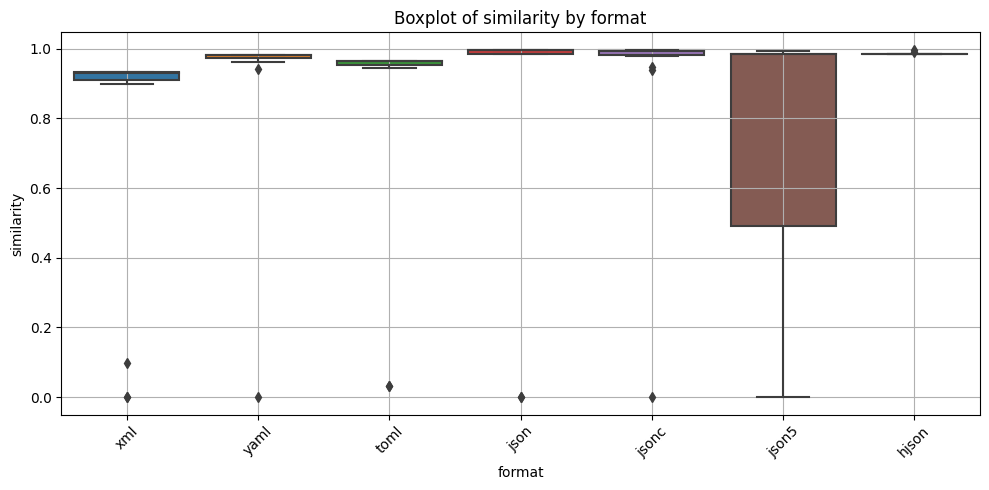

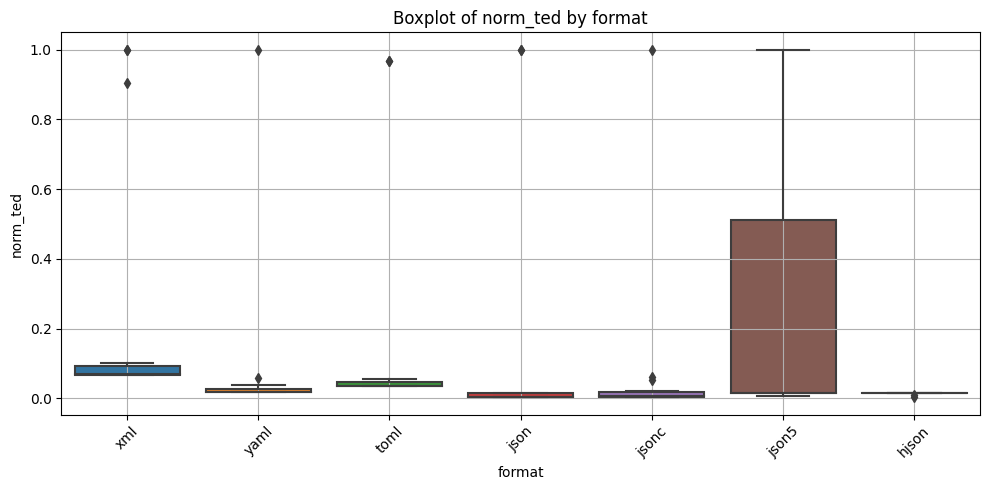

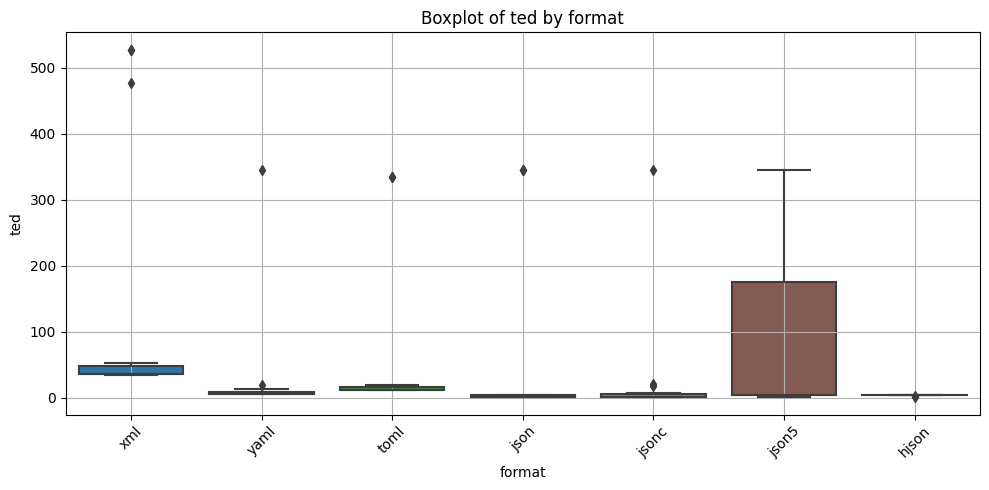

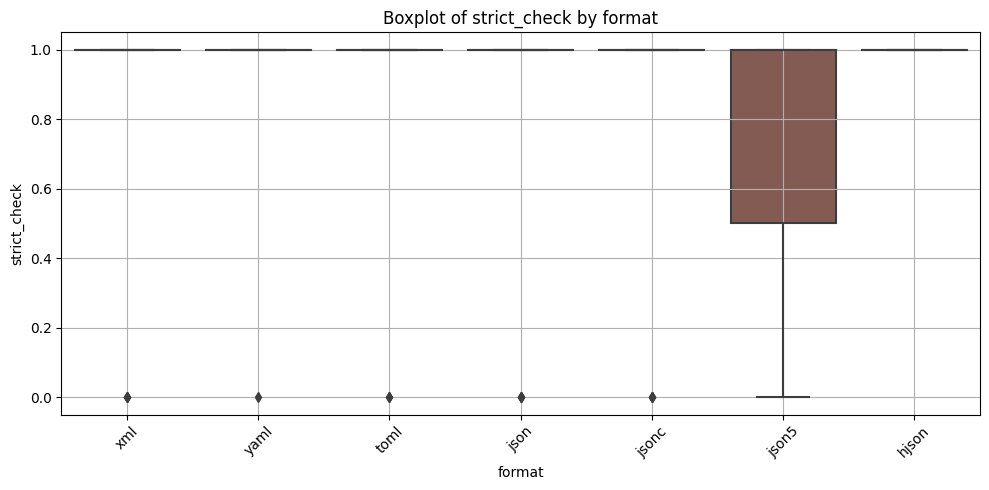

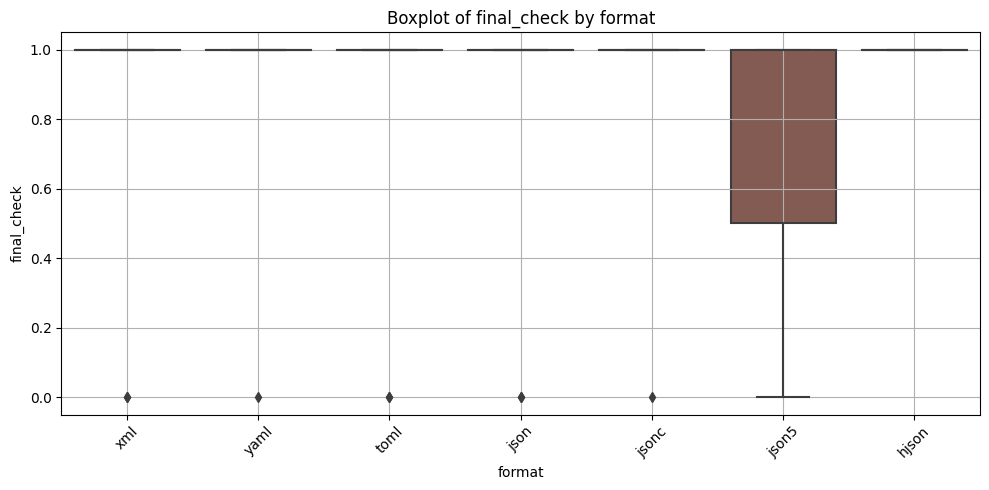

,metric,homogeneity_p,test,test_p,significant,posthoc
0,similarity,0.365612,ANOVA,0.229641,False,[]
1,norm_ted,0.365612,ANOVA,0.229641,False,[]
2,ted,0.270933,ANOVA,0.075546,False,[]
3,strict_check,0.469000,ANOVA,0.469000,False,[]
4,final_check,0.406154,ANOVA,0.406154,False,[]


In [69]:
combined_df_m_1, anova_result_m = compare_and_plot_metrics_across_formats(
    xml_m_result_1, yaml_m_result_1,toml_m_result_1,json_m_result_1,jsonc_m_result_1,json5_m_result_1,hjson_m_result_1
)
combined_df_m_1['task_id'] = 1
summary_df_m_1 = generate_statistical_summary(combined_df_m_1)
summary_df_m_1

In [86]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print(summary_df_m_1.to_string())

         metric  homogeneity_p   test    test_p  significant posthoc
0    similarity       0.365612  ANOVA  0.229641        False      []
1      norm_ted       0.365612  ANOVA  0.229641        False      []
2           ted       0.270933  ANOVA  0.075546        False      []
3  strict_check       0.469000  ANOVA  0.469000        False      []
4   final_check       0.406154  ANOVA  0.406154        False      []


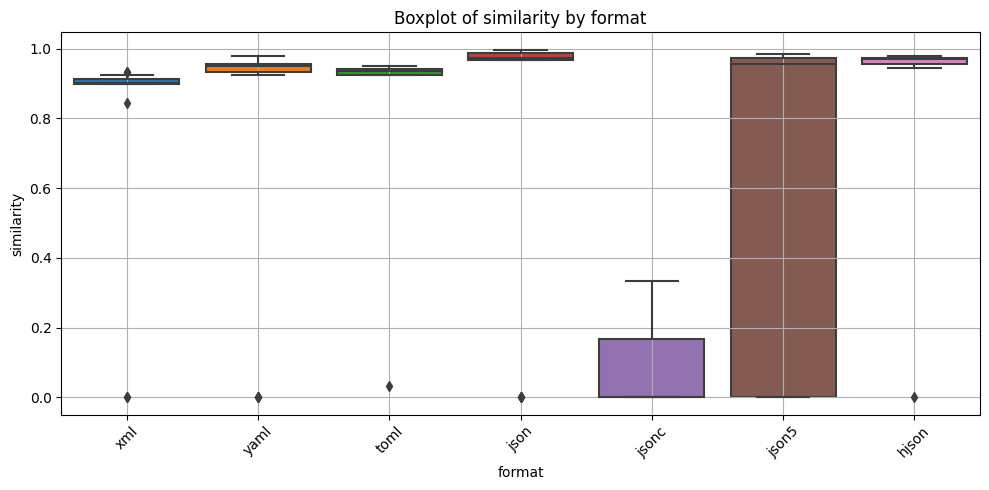

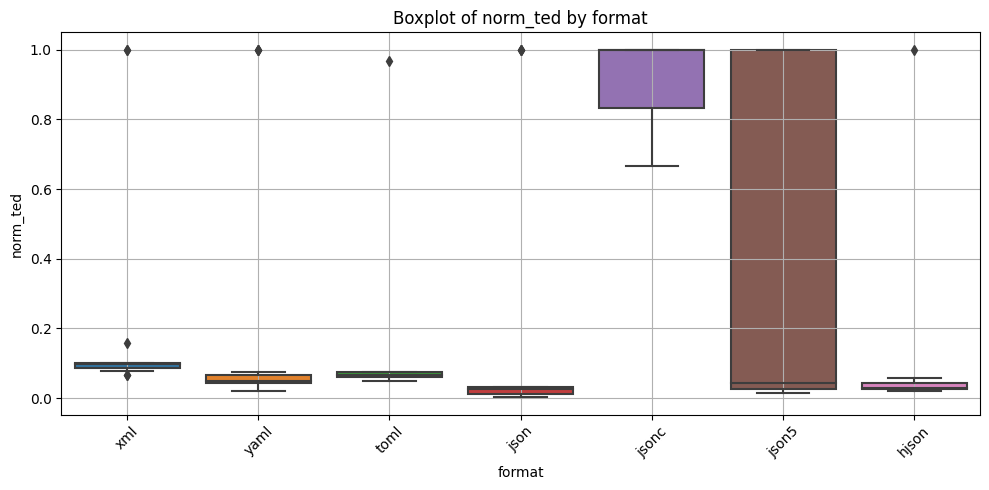

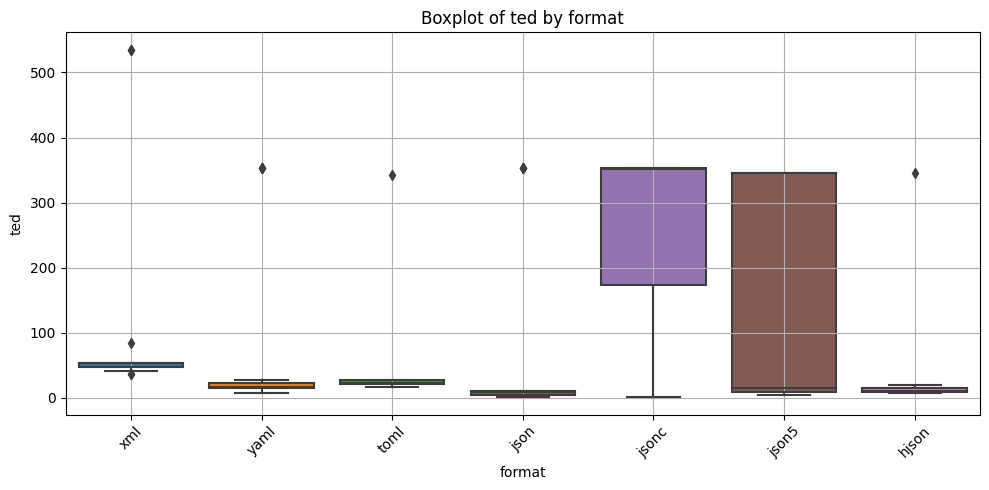

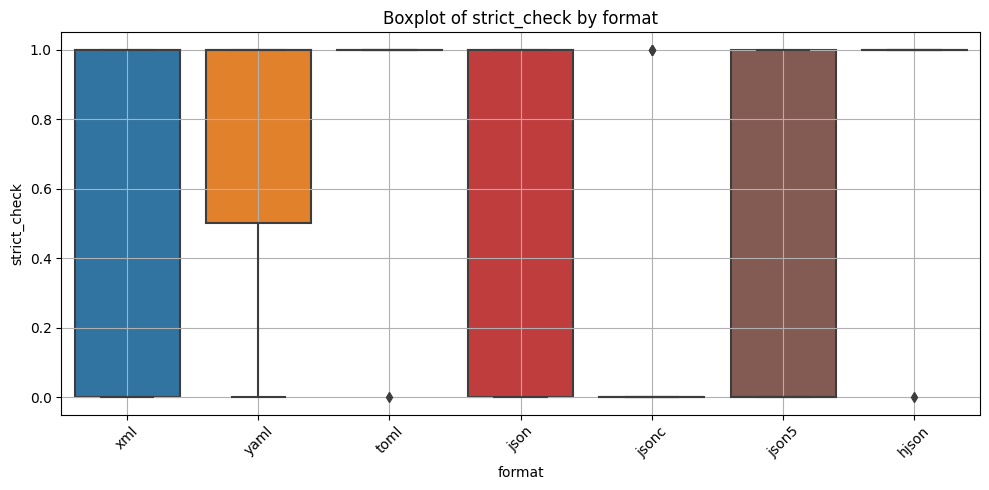

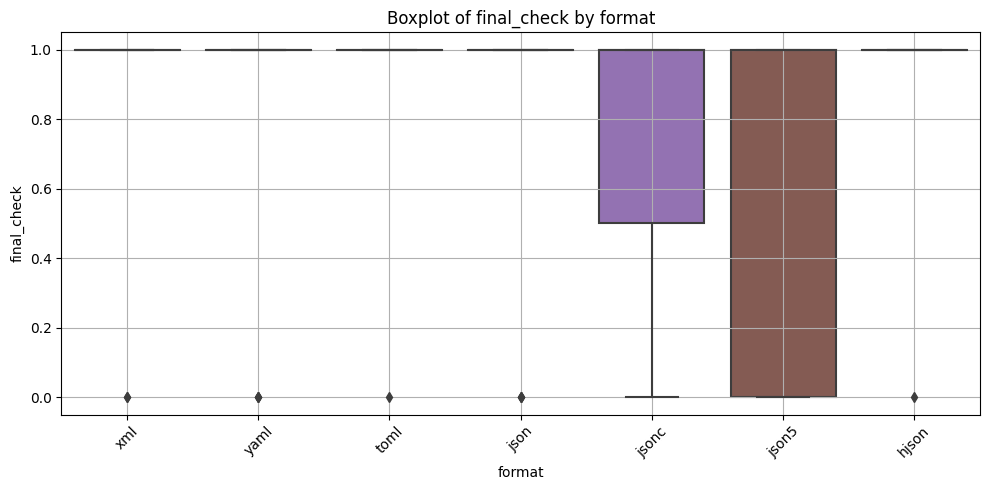

,metric,homogeneity_p,test,test_p,significant,posthoc
0,similarity,0.332433,ANOVA,5.820046e-09,True,"[[hjson, jsonc], [json, jsonc], [json5, jsonc], [jsonc, toml], [jsonc, xml], [jsonc, yaml]]"
1,norm_ted,0.332433,ANOVA,5.820046e-09,True,"[[hjson, jsonc], [json, jsonc], [json5, jsonc], [jsonc, toml], [jsonc, xml], [jsonc, yaml]]"
2,ted,0.541795,ANOVA,5.208959e-04,True,"[[hjson, jsonc], [json, jsonc], [jsonc, toml], [jsonc, yaml]]"
3,strict_check,0.097707,ANOVA,9.670089e-06,True,"[[hjson, json5], [hjson, jsonc], [json5, toml], [jsonc, toml], [jsonc, yaml]]"
4,final_check,0.452841,ANOVA,4.528411e-01,False,[]


In [70]:
combined_df_m_2, anova_result_m = compare_and_plot_metrics_across_formats(
    xml_m_result_2, yaml_m_result_2,toml_m_result_2,json_m_result_2,jsonc_m_result_2,json5_m_result_2,hjson_m_result_2
)
combined_df_m_2['task_id'] = 2
summary_df_m_2 = generate_statistical_summary(combined_df_m_2)
summary_df_m_2

In [87]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print(summary_df_m_2.to_string())

         metric  homogeneity_p   test        test_p  significant                                                                                      posthoc
0    similarity       0.332433  ANOVA  5.820046e-09         True  [[hjson, jsonc], [json, jsonc], [json5, jsonc], [jsonc, toml], [jsonc, xml], [jsonc, yaml]]
1      norm_ted       0.332433  ANOVA  5.820046e-09         True  [[hjson, jsonc], [json, jsonc], [json5, jsonc], [jsonc, toml], [jsonc, xml], [jsonc, yaml]]
2           ted       0.541795  ANOVA  5.208959e-04         True                                [[hjson, jsonc], [json, jsonc], [jsonc, toml], [jsonc, yaml]]
3  strict_check       0.097707  ANOVA  9.670089e-06         True                [[hjson, json5], [hjson, jsonc], [json5, toml], [jsonc, toml], [jsonc, yaml]]
4   final_check       0.452841  ANOVA  4.528411e-01        False                                                                                           []


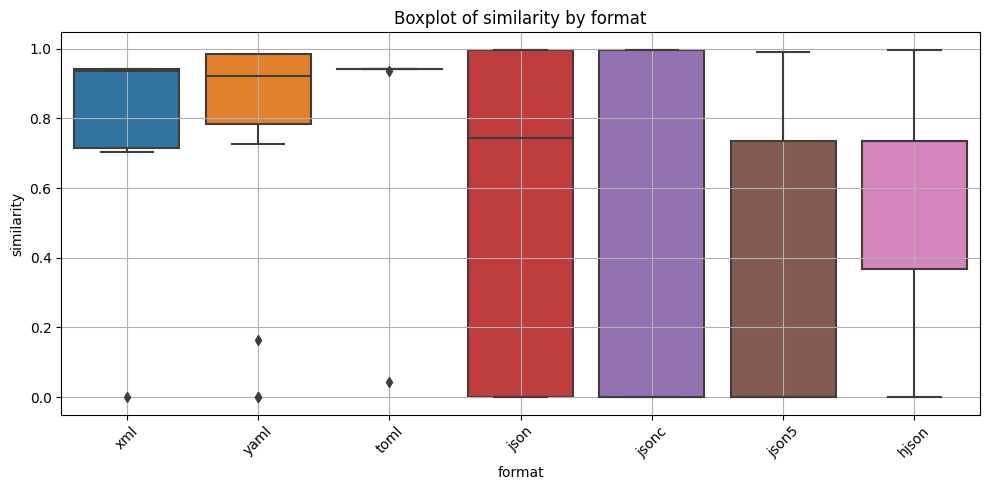

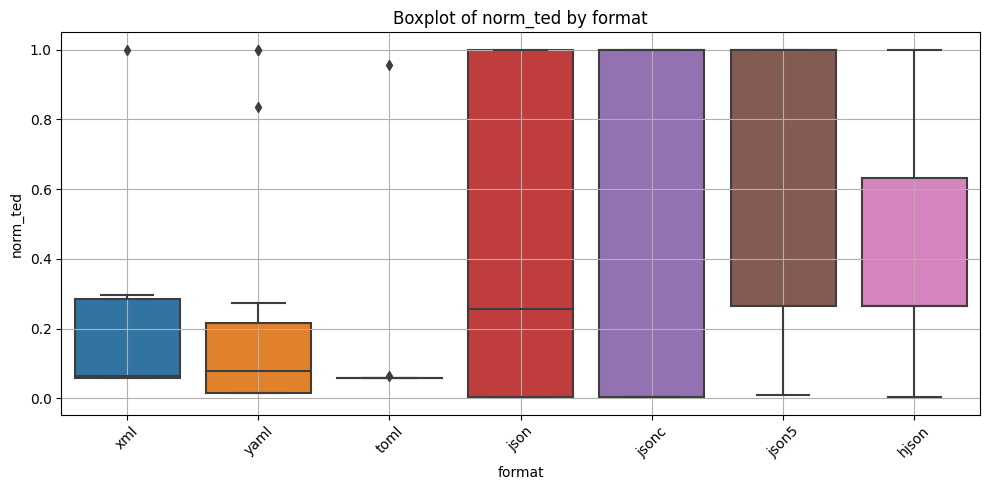

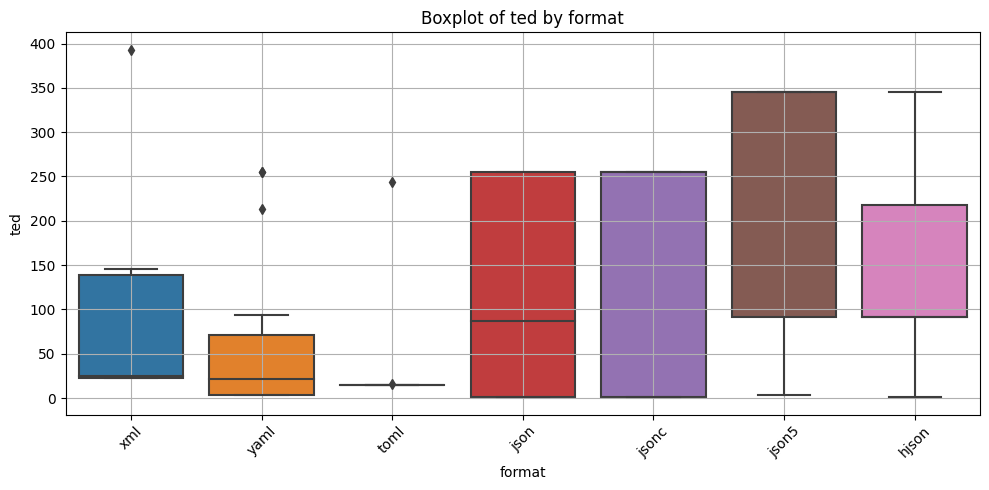

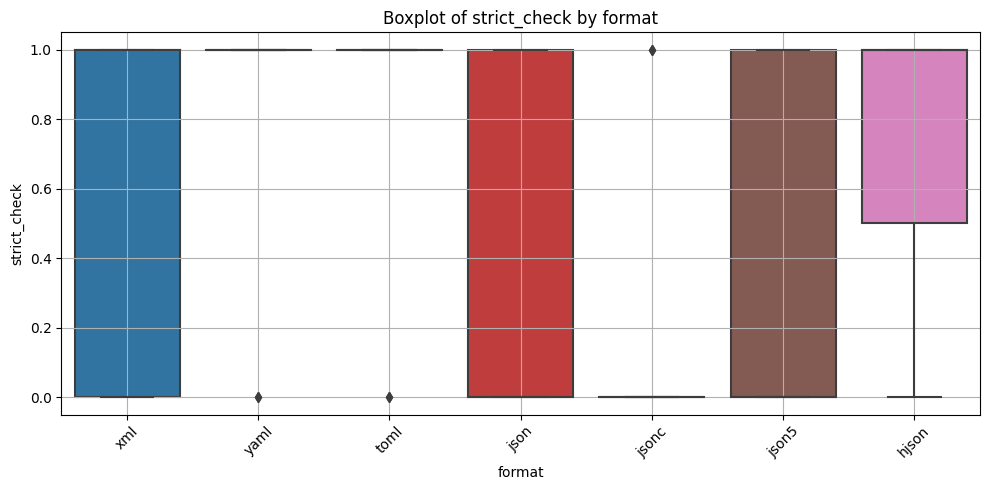

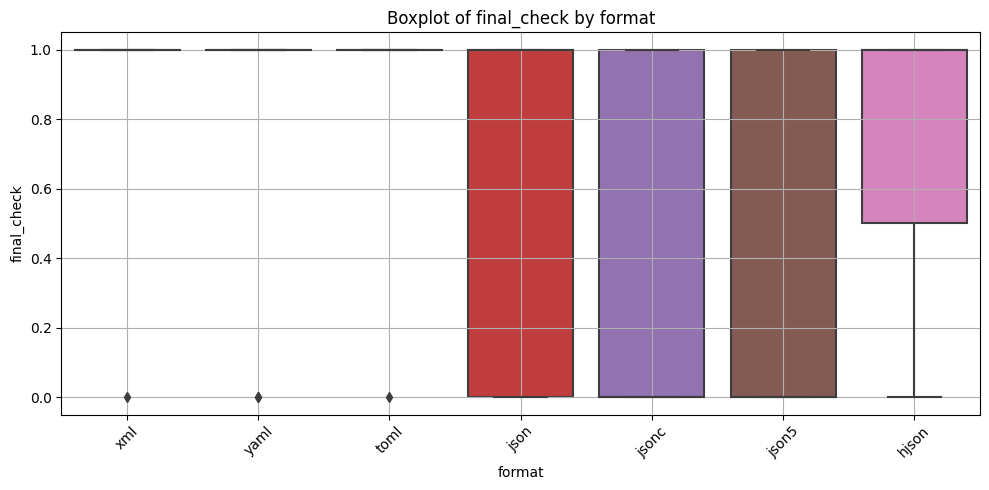

,metric,homogeneity_p,test,test_p,significant,posthoc
0,similarity,0.048746,ANOVA,0.000327,True,"[[json5, toml], [json5, xml], [json5, yaml], [jsonc, toml], [jsonc, xml]]"
1,norm_ted,0.048746,ANOVA,0.000327,True,"[[json5, toml], [json5, xml], [json5, yaml], [jsonc, toml], [jsonc, xml]]"
2,ted,0.150539,ANOVA,0.000058,True,"[[json, json5], [json5, toml], [json5, xml], [json5, yaml], [jsonc, toml]]"
3,strict_check,0.090456,ANOVA,0.000085,True,"[[hjson, jsonc], [jsonc, toml], [jsonc, yaml]]"
4,final_check,0.059313,ANOVA,0.000440,True,"[[json5, toml], [json5, xml], [json5, yaml], [jsonc, toml], [jsonc, xml], [jsonc, yaml]]"


In [71]:
combined_df_m_3, anova_result_m = compare_and_plot_metrics_across_formats(
    xmlm_result_3, yaml_m_result_3,toml_m_result_3,json_m_result_3,jsonc_m_result_3,json5_m_result_3,hjson_m_result_3
)
combined_df_m_3['task_id'] = 3
summary_df_m_3 = generate_statistical_summary(combined_df_m_3)
summary_df_m_3

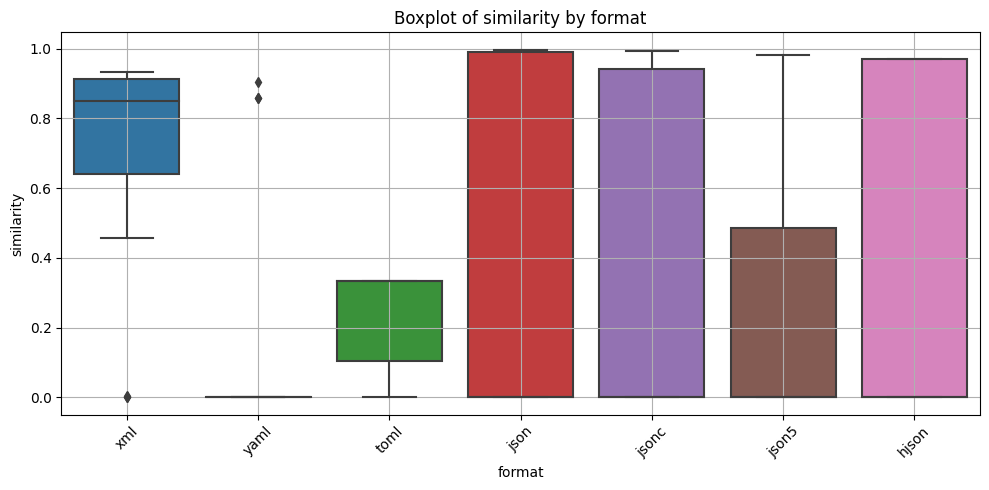

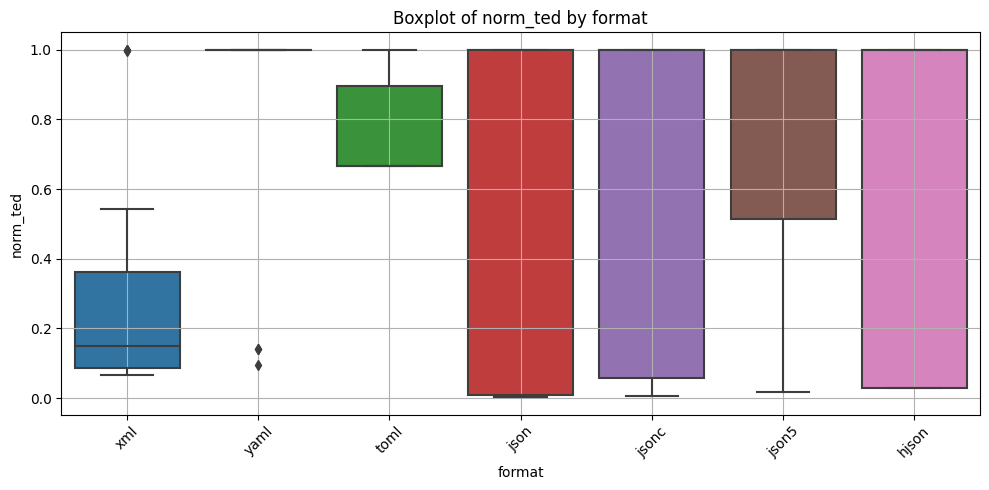

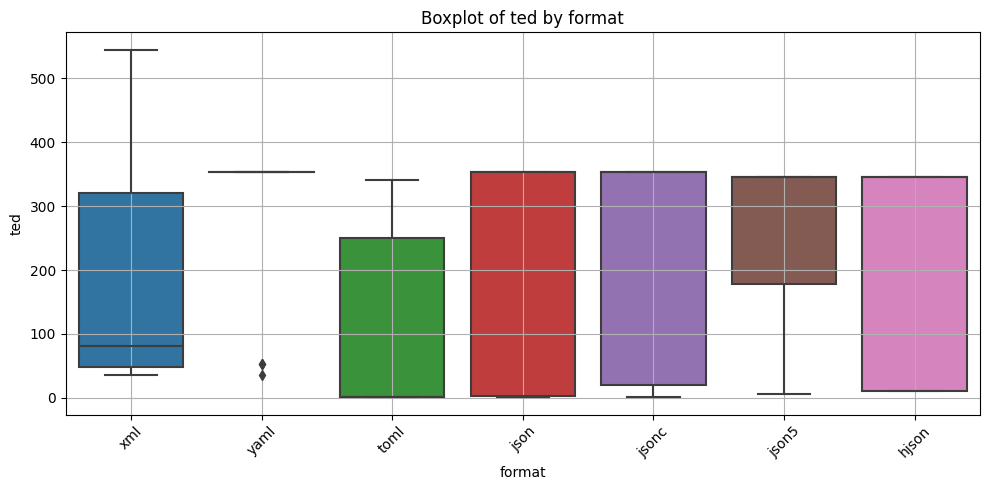

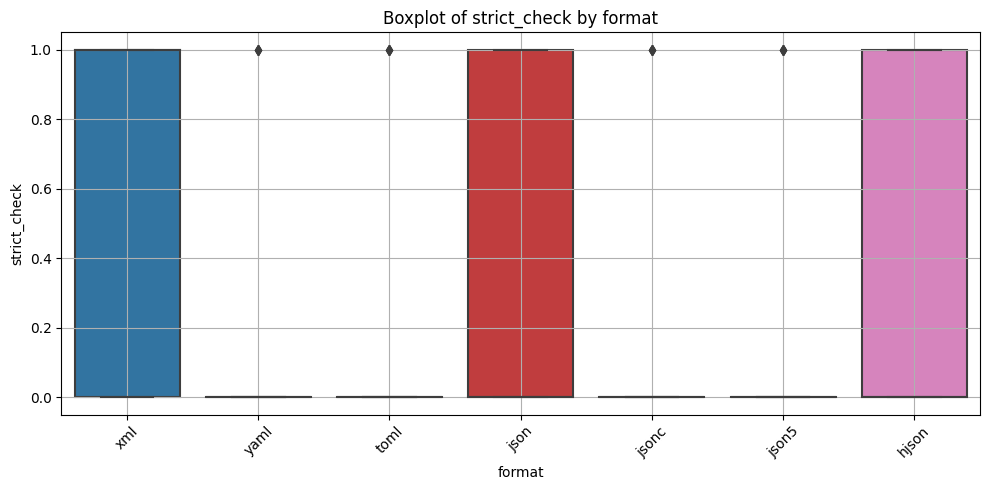

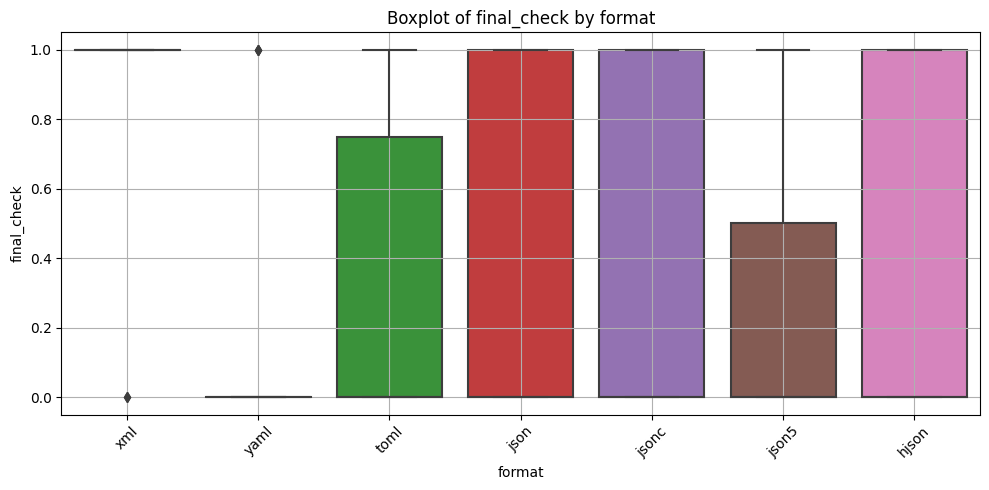

,metric,homogeneity_p,test,test_p,significant,posthoc
0,similarity,0.265512,ANOVA,0.026041,True,"[[xml, yaml]]"
1,norm_ted,0.265512,ANOVA,0.026041,True,"[[xml, yaml]]"
2,ted,0.726017,ANOVA,0.069824,False,[]
3,strict_check,0.362922,ANOVA,0.209215,False,[]
4,final_check,0.356399,ANOVA,0.002540,True,"[[json, xml], [json5, xml], [toml, xml], [xml, yaml]]"


In [72]:
combined_df_m_4, anova_result_m = compare_and_plot_metrics_across_formats(
    xml_m_result_4, yaml_m_result_4,toml_m_result_4,json_m_result_4,jsonc_m_result_4,json5_m_result_4,hjson_m_result_4
)
combined_df_m_4['task_id'] = 4
summary_df_m_4 = generate_statistical_summary(combined_df_m_4)
summary_df_m_4

In [88]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print(summary_df_m_4.to_string())

         metric  homogeneity_p   test    test_p  significant                                                posthoc
0    similarity       0.265512  ANOVA  0.026041         True                                          [[xml, yaml]]
1      norm_ted       0.265512  ANOVA  0.026041         True                                          [[xml, yaml]]
2           ted       0.726017  ANOVA  0.069824        False                                                     []
3  strict_check       0.362922  ANOVA  0.209215        False                                                     []
4   final_check       0.356399  ANOVA  0.002540         True  [[json, xml], [json5, xml], [toml, xml], [xml, yaml]]


In [74]:
all_m_dfs = [combined_df_m_1, combined_df_m_2, combined_df_m_3, combined_df_m_4]
combined_m = pd.concat(all_m_dfs, ignore_index=True)
combined_with_overall = add_overall_rows(combined_m)
combined_df_m_overall_only = combined_with_overall[
    combined_with_overall['task_id'] == 'overall'
].reset_index(drop=True)
combined_df_m_overall_only


,participantId,format,strict_check,loose_check,final_check,ted,norm_ted,similarity,task_id
0,669b961e1c9cf30a26bb57d2,xml,1,NaN,1,42.0,0.079696,0.920304,1
1,60721c2da01b3a616edba9a7,xml,1,NaN,1,36.0,0.068311,0.931689,1
2,67d95269b47464c18da766ca,xml,1,NaN,1,53.0,0.100569,0.899431,1
3,6740ae39809389d7da9de209,xml,0,1.0,1,476.0,0.903226,0.096774,1
4,62fd14d7b1e0729dc8aadb79,xml,1,NaN,1,35.0,0.066414,0.933586,1
...,...,...,...,...,...,...,...,...,...
419,6577a27da9f5297d49f38e6f,hjson,1,NaN,1,10.0,0.028249,0.971751,4
420,67d9788747176969d8d0fa1d,hjson,0,0.0,0,345.0,1.000000,0.000000,4
421,67d71acca9143c53ef722a5c,hjson,0,0.0,0,345.0,1.000000,0.000000,4
422,67adb27bd5f5776fcb16da62,hjson,0,0.0,0,345.0,1.000000,0.000000,4


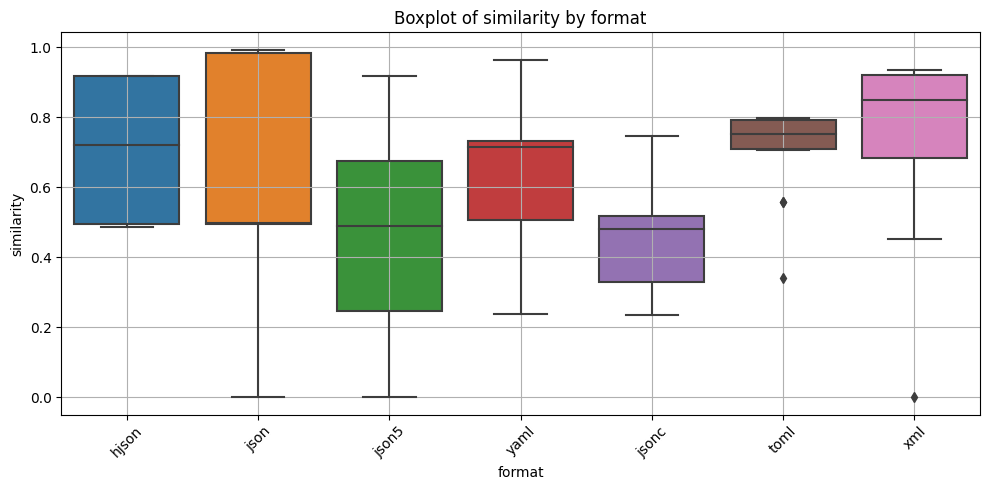

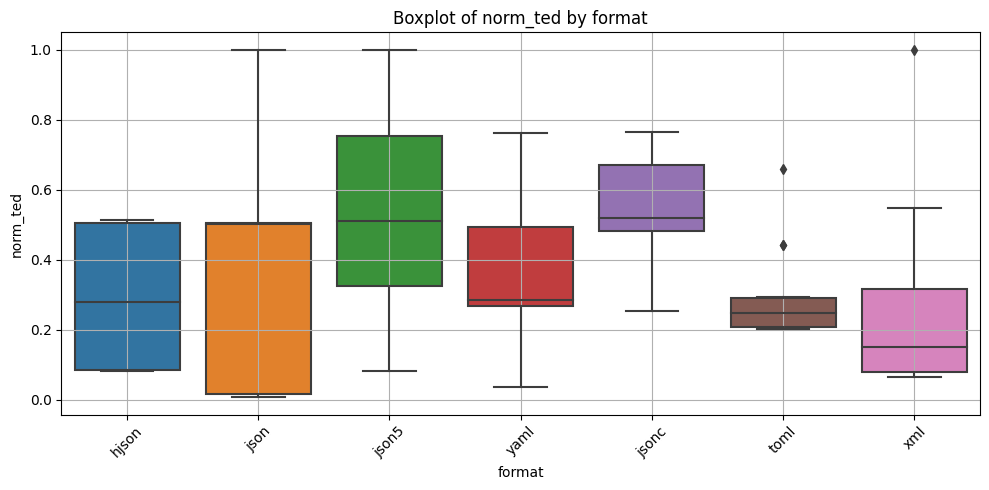

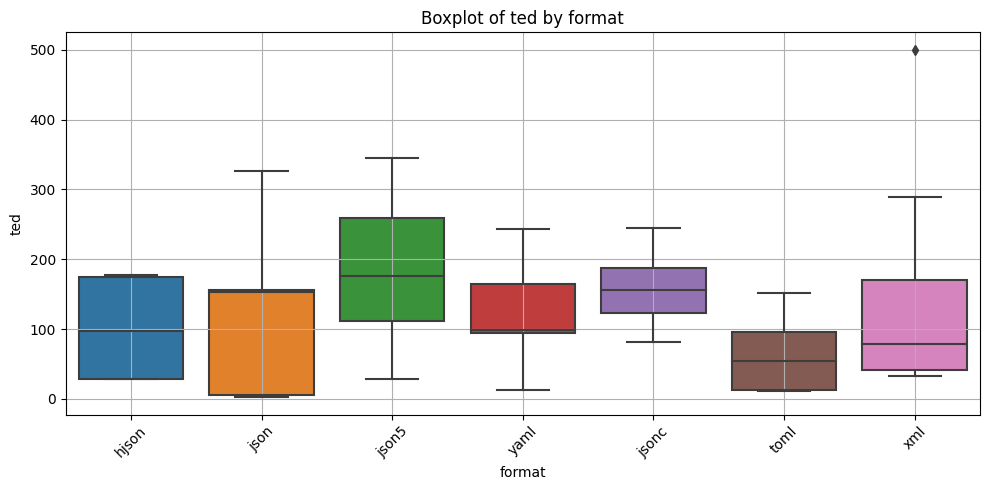

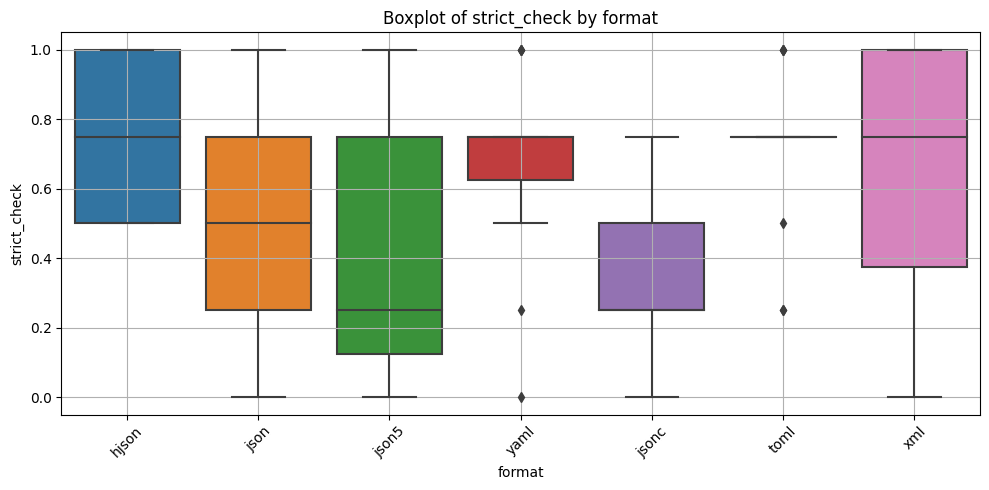

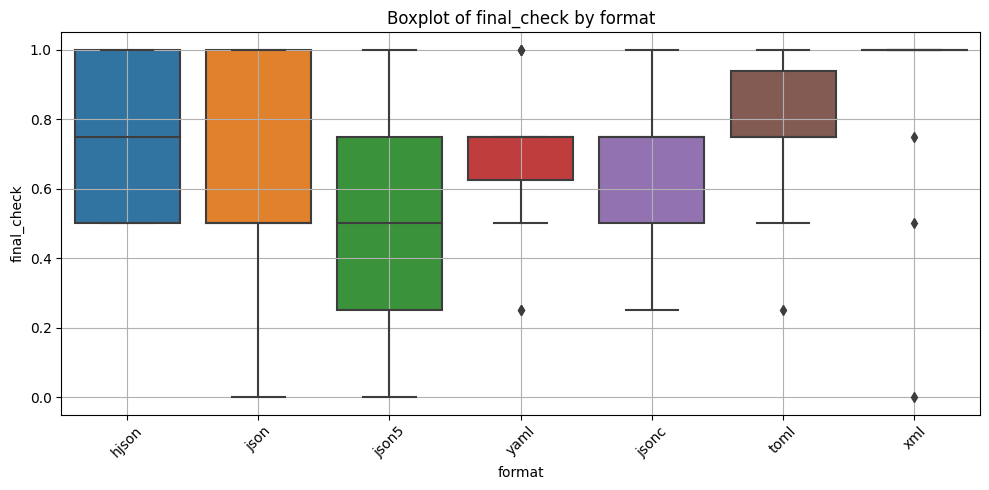

,metric,homogeneity_p,test,test_p,significant,posthoc
0,similarity,0.214653,ANOVA,0.001654,True,"[[hjson, jsonc], [json5, xml], [jsonc, xml]]"
1,norm_ted,0.214653,ANOVA,0.001654,True,"[[hjson, jsonc], [json5, xml], [jsonc, xml]]"
2,ted,0.350317,ANOVA,0.006903,True,"[[json5, toml], [jsonc, toml]]"
3,strict_check,0.065253,ANOVA,0.000345,True,"[[hjson, json5], [hjson, jsonc], [jsonc, toml], [jsonc, yaml]]"
4,final_check,0.453435,ANOVA,0.008555,True,"[[json5, xml]]"


In [85]:
combined_df_m, anova_result_m = compare_and_plot_metrics_across_formats(
    combined_df_m_overall_only
)

summary_df_m = generate_statistical_summary(combined_df_m)
summary_df_m

In [89]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print(summary_df_m.to_string())

         metric  homogeneity_p   test    test_p  significant                                                         posthoc
0    similarity       0.214653  ANOVA  0.001654         True                    [[hjson, jsonc], [json5, xml], [jsonc, xml]]
1      norm_ted       0.214653  ANOVA  0.001654         True                    [[hjson, jsonc], [json5, xml], [jsonc, xml]]
2           ted       0.350317  ANOVA  0.006903         True                                  [[json5, toml], [jsonc, toml]]
3  strict_check       0.065253  ANOVA  0.000345         True  [[hjson, json5], [hjson, jsonc], [jsonc, toml], [jsonc, yaml]]
4   final_check       0.453435  ANOVA  0.008555         True                                                  [[json5, xml]]
